In [ ]:
!pip install git+https://github.com/rcmalli/keras-vggface.git

  Cloning https://github.com/rcmalli/keras-vggface.git to /tmp/pip-req-build-t_c5f69v
  Running command git clone -q https://github.com/rcmalli/keras-vggface.git /tmp/pip-req-build-t_c5f69v
  Created wheel for keras-vggface: filename=keras_vggface-0.6-cp36-none-any.whl size=8310 sha256=60ff58b61b8bf390b53783af20cf2fd566e4c40ff64b8841f9d10ebac85d8e9d
  Stored in directory: /tmp/pip-ephem-wheel-cache-9t6b9ekh/wheels/36/07/46/06c25ce8e9cd396dabe151ea1d8a2bc28dafcb11321c1f3a6d
Successfully built keras-vggface


In [ ]:
!pip install mtcnn

In [ ]:
!pip install keras_applications

In [56]:
import tensorflow as tf
import tensorflow.keras 
from tensorflow.keras.models import load_model
from tensorflow.keras.models import model_from_json
from os import listdir
from collections import defaultdict 
import matplotlib.pyplot as plt
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import Dense, BatchNormalization, GlobalAveragePooling2D, Input, Dropout, ZeroPadding2D, Convolution2D, MaxPooling2D, Flatten, Activation
from tensorflow.keras.models import Model, Sequential
import numpy as np
from keras.applications.vgg16 import preprocess_input
import mtcnn


gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
  except RuntimeError as e:
      # Memory growth must be set before GPUs have been initialized
      print(e)

In [54]:
from PIL import Image
def get_image(path, size=(160, 160)):
    #get image
    image = Image.open(path)
    #convert to RGB:
    image = image.convert('RGB')
    #resize image:
    image = image.resize(size)
    #turn into array:
    image = np.asarray(image)
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    return image




from numpy import asarray
def face_detector(face_dataset):
    output_dataset = list()
    face_dimensions = face_dataset[0].shape[:-1]
    detector = mtcnn.MTCNN()
    for i in range(0, face_dataset.shape[0]):
        image = face_dataset[i][1:]
        results = detector.detect_faces(image)
        if len(results)==0:
           print(i)
           detector = mtcnn.MTCNN()
           results = detector.detect_faces(image)
           
        x1, y1, width, height = results[0]['box']
        x1 = abs(x1)
        y1 = abs(y1)
        x2, y2 = x1 + width, y1+height
        image = image[y1:y2, x1:x2]
        image = Image.fromarray(image)
        image = image.resize((face_dimensions[0], face_dimensions[1]))
        image = np.expand_dims(asarray(image), 0)
        output_dataset.append(image)
    output_dataset = np.vstack(output_dataset)
    return output_dataset

In [2]:
vgg_model = Sequential()
vgg_model.add(ZeroPadding2D((1,1),input_shape=(224,224, 3)))
vgg_model.add(Convolution2D(64, (3, 3), activation='relu'))
vgg_model.add(ZeroPadding2D((1,1)))
vgg_model.add(Convolution2D(64, (3, 3), activation='relu'))
vgg_model.add(MaxPooling2D((2,2), strides=(2,2)))
 
vgg_model.add(ZeroPadding2D((1,1)))
vgg_model.add(Convolution2D(128, (3, 3), activation='relu'))
vgg_model.add(ZeroPadding2D((1,1)))
vgg_model.add(Convolution2D(128, (3, 3), activation='relu'))
vgg_model.add(MaxPooling2D((2,2), strides=(2,2)))
 
vgg_model.add(ZeroPadding2D((1,1)))
vgg_model.add(Convolution2D(256, (3, 3), activation='relu'))
vgg_model.add(ZeroPadding2D((1,1)))
vgg_model.add(Convolution2D(256, (3, 3), activation='relu'))
vgg_model.add(ZeroPadding2D((1,1)))
vgg_model.add(Convolution2D(256, (3, 3), activation='relu'))
vgg_model.add(MaxPooling2D((2,2), strides=(2,2)))
 
vgg_model.add(ZeroPadding2D((1,1)))
vgg_model.add(Convolution2D(512, (3, 3), activation='relu'))
vgg_model.add(ZeroPadding2D((1,1)))
vgg_model.add(Convolution2D(512, (3, 3), activation='relu'))
vgg_model.add(ZeroPadding2D((1,1)))
vgg_model.add(Convolution2D(512, (3, 3), activation='relu'))
vgg_model.add(MaxPooling2D((2,2), strides=(2,2)))
 
vgg_model.add(ZeroPadding2D((1,1)))
vgg_model.add(Convolution2D(512, (3, 3), activation='relu'))
vgg_model.add(ZeroPadding2D((1,1)))
vgg_model.add(Convolution2D(512, (3, 3), activation='relu'))
vgg_model.add(ZeroPadding2D((1,1)))
vgg_model.add(Convolution2D(512, (3, 3), activation='relu'))
vgg_model.add(MaxPooling2D((2,2), strides=(2,2)))
 
vgg_model.add(Convolution2D(4096, (7, 7), activation='relu'))
vgg_model.add(Dropout(0.5))
vgg_model.add(Convolution2D(4096, (1, 1), activation='relu'))
vgg_model.add(Dropout(0.5))
vgg_model.add(Convolution2D(2622, (1, 1)))
vgg_model.add(Flatten())
vgg_model.add(Activation('softmax'))


In [3]:
vgg_model.load_weights('vgg_face_weights.h5')

In [4]:
base_model = Model(inputs=vgg_model.layers[0].input, outputs=vgg_model.layers[-2].output)
for layer in base_model.layers:
        layer.trainable = False

In [85]:
data = np.load('vgg_face_data.npz')
reference = data['train_reference']
query = data['train_query']
labels = data['train_labels']
val_reference = data['validation_reference']
val_query = data['validation_query']
val_labels = data['validation_lables']

In [86]:
data = np.load('vgg_face_data_testing.npz')
test_reference = data['test_reference']
test_query = data['test_query']
test_labels = data['test_labels']

In [87]:
print(reference.shape)
print(query.shape)
print(labels.shape)
print(val_reference.shape)
print(val_query.shape)
print(val_labels.shape)

(3760, 2622)
(3760, 2622)
(3760,)
(100, 2622)
(100, 2622)
(100,)


In [40]:
def siamise_nn(X):
    query = X[0]
    reference = X[1]
    
    # add a global spatial average pooling layer
    D0 = Dense(1000, activation='relu',kernel_regularizer='l1')
    D1 = Dense(200, use_bias=True, kernel_regularizer='l2')
    Dp = Dropout(0.2)
    D2 = Dense(1, activation='sigmoid')

    x_q = Input(query)
    x_r = Input(reference)

    #X_q = GlobalAveragePooling2D()(X_q)
    # let's add a fully-connected layer
    X_q = D1(D0(Dp(x_q)))


    #reference: 
    #X_r = GlobalAveragePooling2D()(X_r)
    # let's add a fully-connected layer
    X_r = D1(Dp(D0(x_r)))
    sub = X_r-X_q

    out = tf.math.abs(sub)
    output = D2(out)

    # this is the model we will train
    model = Model(inputs=[x_q, x_r], outputs=output)

    # first: train only the top layers (which were randomly initialized)
    # i.e. freeze all convolutional InceptionV3 layers
    return model


In [41]:
permutation = np.random.permutation(range(query.shape[0]))
query = query[permutation]
reference = reference[permutation]
labels= labels[permutation]

In [42]:
model = siamise_nn([query.shape[1:], reference.shape[1:]])

In [47]:
optimizers = tf.keras.optimizers.Adam(1e-5)
model.compile(optimizer=optimizers, loss=tf.keras.losses.BinaryCrossentropy(), metrics = ['accuracy'])

In [48]:
x_val = [val_query, val_reference]
y_val = val_labels
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='age_face_best_weights_23_12_post_train2.h5',
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

fitter = model.fit(x=[query, reference], y=labels, batch_size= 128,validation_data=((x_val, y_val)),epochs=10000, callbacks=[model_checkpoint_callback])

Train on 3560 samples, validate on 300 samples
Epoch 1/10000
3560/3560 [==============================] - 1s 230us/sample - loss: 0.4535 - accuracy: 0.9511 - val_loss: 0.6204 - val_accuracy: 0.8633
Epoch 2/10000
3560/3560 [==============================] - 0s 62us/sample - loss: 0.3877 - accuracy: 0.9573 - val_loss: 0.5999 - val_accuracy: 0.8600
Epoch 3/10000
3560/3560 [==============================] - 0s 63us/sample - loss: 0.3799 - accuracy: 0.9522 - val_loss: 0.5804 - val_accuracy: 0.8567
Epoch 4/10000
3560/3560 [==============================] - 0s 68us/sample - loss: 0.3711 - accuracy: 0.9534 - val_loss: 0.5772 - val_accuracy: 0.8667
Epoch 5/10000
3560/3560 [==============================] - 0s 68us/sample - loss: 0.3631 - accuracy: 0.9567 - val_loss: 0.5695 - val_accuracy: 0.8700
Epoch 6/10000
3560/3560 [==============================] - 0s 62us/sample - loss: 0.3547 - accuracy: 0.9601 - val_loss: 0.5677 - val_accuracy: 0.8667
Epoch 7/10000
3560/3560 [===========================

Epoch 55/10000
3560/3560 [==============================] - 0s 78us/sample - loss: 0.3191 - accuracy: 0.9612 - val_loss: 0.5372 - val_accuracy: 0.8633
Epoch 56/10000
3560/3560 [==============================] - 0s 75us/sample - loss: 0.3234 - accuracy: 0.9548 - val_loss: 0.5319 - val_accuracy: 0.8633
Epoch 57/10000
3560/3560 [==============================] - 0s 63us/sample - loss: 0.3165 - accuracy: 0.9590 - val_loss: 0.5368 - val_accuracy: 0.8600
Epoch 58/10000
3560/3560 [==============================] - 0s 59us/sample - loss: 0.3178 - accuracy: 0.9587 - val_loss: 0.5355 - val_accuracy: 0.8633
Epoch 59/10000
3560/3560 [==============================] - 0s 64us/sample - loss: 0.3227 - accuracy: 0.9576 - val_loss: 0.5348 - val_accuracy: 0.8567
Epoch 60/10000
3560/3560 [==============================] - 0s 61us/sample - loss: 0.3218 - accuracy: 0.9565 - val_loss: 0.5357 - val_accuracy: 0.8600
Epoch 61/10000
3560/3560 [==============================] - 0s 68us/sample - loss: 0.3232 - ac

3560/3560 [==============================] - 0s 62us/sample - loss: 0.3134 - accuracy: 0.9610 - val_loss: 0.5286 - val_accuracy: 0.8633
Epoch 110/10000
3560/3560 [==============================] - 0s 62us/sample - loss: 0.3146 - accuracy: 0.9562 - val_loss: 0.5280 - val_accuracy: 0.8667
Epoch 111/10000
3560/3560 [==============================] - 0s 61us/sample - loss: 0.3101 - accuracy: 0.9610 - val_loss: 0.5258 - val_accuracy: 0.8567
Epoch 112/10000
3560/3560 [==============================] - 0s 60us/sample - loss: 0.3169 - accuracy: 0.9573 - val_loss: 0.5305 - val_accuracy: 0.8600
Epoch 113/10000
3560/3560 [==============================] - 0s 60us/sample - loss: 0.3173 - accuracy: 0.9565 - val_loss: 0.5291 - val_accuracy: 0.8733
Epoch 114/10000
3560/3560 [==============================] - 0s 61us/sample - loss: 0.3121 - accuracy: 0.9576 - val_loss: 0.5243 - val_accuracy: 0.8667
Epoch 115/10000
3560/3560 [==============================] - 0s 63us/sample - loss: 0.3151 - accuracy: 0

3560/3560 [==============================] - 0s 62us/sample - loss: 0.3064 - accuracy: 0.9607 - val_loss: 0.5216 - val_accuracy: 0.8633
Epoch 164/10000
3560/3560 [==============================] - 0s 63us/sample - loss: 0.3129 - accuracy: 0.9567 - val_loss: 0.5119 - val_accuracy: 0.8667
Epoch 165/10000
3560/3560 [==============================] - 0s 62us/sample - loss: 0.3132 - accuracy: 0.9573 - val_loss: 0.5130 - val_accuracy: 0.8700
Epoch 166/10000
3560/3560 [==============================] - 0s 60us/sample - loss: 0.3142 - accuracy: 0.9553 - val_loss: 0.5174 - val_accuracy: 0.8667
Epoch 167/10000
3560/3560 [==============================] - 0s 62us/sample - loss: 0.3075 - accuracy: 0.9632 - val_loss: 0.5200 - val_accuracy: 0.8633
Epoch 168/10000
3560/3560 [==============================] - 0s 63us/sample - loss: 0.3160 - accuracy: 0.9601 - val_loss: 0.5160 - val_accuracy: 0.8700
Epoch 169/10000
3560/3560 [==============================] - 0s 62us/sample - loss: 0.3152 - accuracy: 0

3560/3560 [==============================] - 0s 60us/sample - loss: 0.3047 - accuracy: 0.9626 - val_loss: 0.5160 - val_accuracy: 0.8533
Epoch 218/10000
3560/3560 [==============================] - 0s 59us/sample - loss: 0.3057 - accuracy: 0.9593 - val_loss: 0.5018 - val_accuracy: 0.8633
Epoch 219/10000
3560/3560 [==============================] - 0s 60us/sample - loss: 0.3124 - accuracy: 0.9553 - val_loss: 0.5153 - val_accuracy: 0.8667
Epoch 220/10000
3560/3560 [==============================] - 0s 69us/sample - loss: 0.3059 - accuracy: 0.9604 - val_loss: 0.5080 - val_accuracy: 0.8600
Epoch 221/10000
3560/3560 [==============================] - 0s 65us/sample - loss: 0.3163 - accuracy: 0.9553 - val_loss: 0.5053 - val_accuracy: 0.8633
Epoch 222/10000
3560/3560 [==============================] - 0s 74us/sample - loss: 0.3043 - accuracy: 0.9640 - val_loss: 0.5128 - val_accuracy: 0.8633
Epoch 223/10000
3560/3560 [==============================] - 0s 68us/sample - loss: 0.3037 - accuracy: 0

3560/3560 [==============================] - 0s 62us/sample - loss: 0.3057 - accuracy: 0.9567 - val_loss: 0.5097 - val_accuracy: 0.8767
Epoch 272/10000
3560/3560 [==============================] - 0s 61us/sample - loss: 0.3052 - accuracy: 0.9618 - val_loss: 0.5099 - val_accuracy: 0.8700
Epoch 273/10000
3560/3560 [==============================] - 0s 60us/sample - loss: 0.3053 - accuracy: 0.9539 - val_loss: 0.5013 - val_accuracy: 0.8667
Epoch 274/10000
3560/3560 [==============================] - 0s 61us/sample - loss: 0.3054 - accuracy: 0.9587 - val_loss: 0.5032 - val_accuracy: 0.8667
Epoch 275/10000
3560/3560 [==============================] - 0s 62us/sample - loss: 0.3029 - accuracy: 0.9587 - val_loss: 0.4987 - val_accuracy: 0.8733
Epoch 276/10000
3560/3560 [==============================] - 0s 62us/sample - loss: 0.3037 - accuracy: 0.9615 - val_loss: 0.5092 - val_accuracy: 0.8667
Epoch 277/10000
3560/3560 [==============================] - 0s 63us/sample - loss: 0.3062 - accuracy: 0

3560/3560 [==============================] - 0s 62us/sample - loss: 0.3096 - accuracy: 0.9545 - val_loss: 0.5186 - val_accuracy: 0.8700
Epoch 326/10000
3560/3560 [==============================] - 0s 61us/sample - loss: 0.3025 - accuracy: 0.9618 - val_loss: 0.5008 - val_accuracy: 0.8733
Epoch 327/10000
3560/3560 [==============================] - 0s 63us/sample - loss: 0.3109 - accuracy: 0.9531 - val_loss: 0.4980 - val_accuracy: 0.8633
Epoch 328/10000
3560/3560 [==============================] - 0s 68us/sample - loss: 0.3015 - accuracy: 0.9598 - val_loss: 0.5120 - val_accuracy: 0.8767
Epoch 329/10000
3560/3560 [==============================] - 0s 67us/sample - loss: 0.3146 - accuracy: 0.9556 - val_loss: 0.5057 - val_accuracy: 0.8700
Epoch 330/10000
3560/3560 [==============================] - 0s 64us/sample - loss: 0.3054 - accuracy: 0.9612 - val_loss: 0.5115 - val_accuracy: 0.8633
Epoch 331/10000
3560/3560 [==============================] - 0s 64us/sample - loss: 0.2997 - accuracy: 0

3560/3560 [==============================] - 0s 62us/sample - loss: 0.3042 - accuracy: 0.9598 - val_loss: 0.5126 - val_accuracy: 0.8633
Epoch 380/10000
3560/3560 [==============================] - 0s 62us/sample - loss: 0.3100 - accuracy: 0.9584 - val_loss: 0.5018 - val_accuracy: 0.8667
Epoch 381/10000
3560/3560 [==============================] - 0s 62us/sample - loss: 0.3131 - accuracy: 0.9553 - val_loss: 0.5026 - val_accuracy: 0.8667
Epoch 382/10000
3560/3560 [==============================] - 0s 62us/sample - loss: 0.2947 - accuracy: 0.9697 - val_loss: 0.5324 - val_accuracy: 0.8533
Epoch 383/10000
3560/3560 [==============================] - 0s 65us/sample - loss: 0.3003 - accuracy: 0.9643 - val_loss: 0.5043 - val_accuracy: 0.8600
Epoch 384/10000
3560/3560 [==============================] - 0s 66us/sample - loss: 0.2950 - accuracy: 0.9638 - val_loss: 0.5122 - val_accuracy: 0.8633
Epoch 385/10000
3560/3560 [==============================] - 0s 63us/sample - loss: 0.3054 - accuracy: 0

3560/3560 [==============================] - 0s 61us/sample - loss: 0.3004 - accuracy: 0.9587 - val_loss: 0.5072 - val_accuracy: 0.8700
Epoch 434/10000
3560/3560 [==============================] - 0s 62us/sample - loss: 0.3006 - accuracy: 0.9643 - val_loss: 0.4988 - val_accuracy: 0.8700
Epoch 435/10000
3560/3560 [==============================] - 0s 63us/sample - loss: 0.3037 - accuracy: 0.9596 - val_loss: 0.5041 - val_accuracy: 0.8733
Epoch 436/10000
3560/3560 [==============================] - 0s 64us/sample - loss: 0.2971 - accuracy: 0.9618 - val_loss: 0.5058 - val_accuracy: 0.8667
Epoch 437/10000
3560/3560 [==============================] - 0s 63us/sample - loss: 0.3072 - accuracy: 0.9590 - val_loss: 0.5044 - val_accuracy: 0.8633
Epoch 438/10000
3560/3560 [==============================] - 0s 62us/sample - loss: 0.3057 - accuracy: 0.9567 - val_loss: 0.4937 - val_accuracy: 0.8667
Epoch 439/10000
3560/3560 [==============================] - 0s 65us/sample - loss: 0.3003 - accuracy: 0

3560/3560 [==============================] - 0s 63us/sample - loss: 0.2956 - accuracy: 0.9652 - val_loss: 0.5081 - val_accuracy: 0.8633
Epoch 488/10000
3560/3560 [==============================] - 0s 64us/sample - loss: 0.3037 - accuracy: 0.9576 - val_loss: 0.4968 - val_accuracy: 0.8700
Epoch 489/10000
3560/3560 [==============================] - 0s 65us/sample - loss: 0.3019 - accuracy: 0.9590 - val_loss: 0.4872 - val_accuracy: 0.8700
Epoch 490/10000
3560/3560 [==============================] - 0s 62us/sample - loss: 0.2997 - accuracy: 0.9607 - val_loss: 0.4946 - val_accuracy: 0.8667
Epoch 491/10000
3560/3560 [==============================] - 0s 61us/sample - loss: 0.3098 - accuracy: 0.9551 - val_loss: 0.5025 - val_accuracy: 0.8600
Epoch 492/10000
3560/3560 [==============================] - 0s 62us/sample - loss: 0.3010 - accuracy: 0.9615 - val_loss: 0.4950 - val_accuracy: 0.8667
Epoch 493/10000
3560/3560 [==============================] - 0s 63us/sample - loss: 0.3059 - accuracy: 0

3560/3560 [==============================] - 0s 63us/sample - loss: 0.2973 - accuracy: 0.9629 - val_loss: 0.4914 - val_accuracy: 0.8833
Epoch 542/10000
3560/3560 [==============================] - 0s 63us/sample - loss: 0.2949 - accuracy: 0.9612 - val_loss: 0.4932 - val_accuracy: 0.8800
Epoch 543/10000
3560/3560 [==============================] - 0s 62us/sample - loss: 0.2962 - accuracy: 0.9621 - val_loss: 0.5041 - val_accuracy: 0.8767
Epoch 544/10000
3560/3560 [==============================] - 0s 62us/sample - loss: 0.3003 - accuracy: 0.9598 - val_loss: 0.5061 - val_accuracy: 0.8633
Epoch 545/10000
3560/3560 [==============================] - 0s 62us/sample - loss: 0.3007 - accuracy: 0.9567 - val_loss: 0.4829 - val_accuracy: 0.8767
Epoch 546/10000
3560/3560 [==============================] - 0s 63us/sample - loss: 0.3014 - accuracy: 0.9587 - val_loss: 0.4971 - val_accuracy: 0.8700
Epoch 547/10000
3560/3560 [==============================] - 0s 63us/sample - loss: 0.3014 - accuracy: 0

3560/3560 [==============================] - 0s 63us/sample - loss: 0.3005 - accuracy: 0.9576 - val_loss: 0.5086 - val_accuracy: 0.8733
Epoch 596/10000
3560/3560 [==============================] - 0s 61us/sample - loss: 0.2967 - accuracy: 0.9590 - val_loss: 0.4953 - val_accuracy: 0.8700
Epoch 597/10000
3560/3560 [==============================] - 0s 62us/sample - loss: 0.3004 - accuracy: 0.9598 - val_loss: 0.4918 - val_accuracy: 0.8733
Epoch 598/10000
3560/3560 [==============================] - 0s 64us/sample - loss: 0.3049 - accuracy: 0.9581 - val_loss: 0.5010 - val_accuracy: 0.8733
Epoch 599/10000
3560/3560 [==============================] - 0s 64us/sample - loss: 0.2964 - accuracy: 0.9621 - val_loss: 0.4970 - val_accuracy: 0.8767
Epoch 600/10000
3560/3560 [==============================] - 0s 63us/sample - loss: 0.2968 - accuracy: 0.9596 - val_loss: 0.4794 - val_accuracy: 0.8700
Epoch 601/10000
3560/3560 [==============================] - 0s 64us/sample - loss: 0.2958 - accuracy: 0

3560/3560 [==============================] - 0s 63us/sample - loss: 0.2934 - accuracy: 0.9671 - val_loss: 0.4985 - val_accuracy: 0.8700
Epoch 650/10000
3560/3560 [==============================] - 0s 63us/sample - loss: 0.2915 - accuracy: 0.9677 - val_loss: 0.5042 - val_accuracy: 0.8767
Epoch 651/10000
3560/3560 [==============================] - 0s 62us/sample - loss: 0.3022 - accuracy: 0.9548 - val_loss: 0.4870 - val_accuracy: 0.8800
Epoch 652/10000
3560/3560 [==============================] - 0s 64us/sample - loss: 0.2863 - accuracy: 0.9669 - val_loss: 0.5038 - val_accuracy: 0.8733
Epoch 653/10000
3560/3560 [==============================] - 0s 63us/sample - loss: 0.2964 - accuracy: 0.9654 - val_loss: 0.5004 - val_accuracy: 0.8700
Epoch 654/10000
3560/3560 [==============================] - 0s 62us/sample - loss: 0.2977 - accuracy: 0.9607 - val_loss: 0.5019 - val_accuracy: 0.8633
Epoch 655/10000
3560/3560 [==============================] - 0s 61us/sample - loss: 0.2939 - accuracy: 0

3560/3560 [==============================] - 0s 63us/sample - loss: 0.3009 - accuracy: 0.9615 - val_loss: 0.5003 - val_accuracy: 0.8633
Epoch 704/10000
3560/3560 [==============================] - 0s 64us/sample - loss: 0.2969 - accuracy: 0.9643 - val_loss: 0.4965 - val_accuracy: 0.8633
Epoch 705/10000
3560/3560 [==============================] - 0s 63us/sample - loss: 0.2939 - accuracy: 0.9652 - val_loss: 0.5014 - val_accuracy: 0.8633
Epoch 706/10000
3560/3560 [==============================] - 0s 63us/sample - loss: 0.2987 - accuracy: 0.9584 - val_loss: 0.5085 - val_accuracy: 0.8667
Epoch 707/10000
3560/3560 [==============================] - 0s 63us/sample - loss: 0.3048 - accuracy: 0.9559 - val_loss: 0.4993 - val_accuracy: 0.8633
Epoch 708/10000
3560/3560 [==============================] - 0s 63us/sample - loss: 0.2957 - accuracy: 0.9649 - val_loss: 0.5032 - val_accuracy: 0.8667
Epoch 709/10000
3560/3560 [==============================] - 0s 62us/sample - loss: 0.2963 - accuracy: 0

3560/3560 [==============================] - 0s 61us/sample - loss: 0.3008 - accuracy: 0.9587 - val_loss: 0.4980 - val_accuracy: 0.8667
Epoch 758/10000
3560/3560 [==============================] - 0s 61us/sample - loss: 0.2966 - accuracy: 0.9612 - val_loss: 0.4939 - val_accuracy: 0.8700
Epoch 759/10000
3560/3560 [==============================] - 0s 62us/sample - loss: 0.2968 - accuracy: 0.9654 - val_loss: 0.4886 - val_accuracy: 0.8733
Epoch 760/10000
3560/3560 [==============================] - 0s 61us/sample - loss: 0.2972 - accuracy: 0.9615 - val_loss: 0.4992 - val_accuracy: 0.8733
Epoch 761/10000
3560/3560 [==============================] - 0s 62us/sample - loss: 0.2870 - accuracy: 0.9680 - val_loss: 0.4995 - val_accuracy: 0.8567
Epoch 762/10000
3560/3560 [==============================] - 0s 60us/sample - loss: 0.3007 - accuracy: 0.9593 - val_loss: 0.5114 - val_accuracy: 0.8600
Epoch 763/10000
3560/3560 [==============================] - 0s 61us/sample - loss: 0.3016 - accuracy: 0

3560/3560 [==============================] - 0s 62us/sample - loss: 0.2990 - accuracy: 0.9573 - val_loss: 0.4798 - val_accuracy: 0.8767
Epoch 812/10000
3560/3560 [==============================] - 0s 64us/sample - loss: 0.2987 - accuracy: 0.9621 - val_loss: 0.4977 - val_accuracy: 0.8700
Epoch 813/10000
3560/3560 [==============================] - 0s 62us/sample - loss: 0.2925 - accuracy: 0.9632 - val_loss: 0.4930 - val_accuracy: 0.8800
Epoch 814/10000
3560/3560 [==============================] - 0s 63us/sample - loss: 0.2963 - accuracy: 0.9649 - val_loss: 0.4973 - val_accuracy: 0.8767
Epoch 815/10000
3560/3560 [==============================] - 0s 67us/sample - loss: 0.2920 - accuracy: 0.9612 - val_loss: 0.4976 - val_accuracy: 0.8700
Epoch 816/10000
3560/3560 [==============================] - 0s 62us/sample - loss: 0.2978 - accuracy: 0.9598 - val_loss: 0.4851 - val_accuracy: 0.8667
Epoch 817/10000
3560/3560 [==============================] - 0s 64us/sample - loss: 0.2942 - accuracy: 0

3560/3560 [==============================] - 0s 62us/sample - loss: 0.3019 - accuracy: 0.9593 - val_loss: 0.5012 - val_accuracy: 0.8667
Epoch 866/10000
3560/3560 [==============================] - 0s 63us/sample - loss: 0.2935 - accuracy: 0.9640 - val_loss: 0.4976 - val_accuracy: 0.8600
Epoch 867/10000
3560/3560 [==============================] - 0s 62us/sample - loss: 0.2929 - accuracy: 0.9629 - val_loss: 0.4880 - val_accuracy: 0.8567
Epoch 868/10000
3560/3560 [==============================] - 0s 63us/sample - loss: 0.2897 - accuracy: 0.9677 - val_loss: 0.4944 - val_accuracy: 0.8667
Epoch 869/10000
3560/3560 [==============================] - 0s 63us/sample - loss: 0.2923 - accuracy: 0.9638 - val_loss: 0.4926 - val_accuracy: 0.8633
Epoch 870/10000
3560/3560 [==============================] - 0s 62us/sample - loss: 0.2887 - accuracy: 0.9683 - val_loss: 0.4970 - val_accuracy: 0.8733
Epoch 871/10000
3560/3560 [==============================] - 0s 61us/sample - loss: 0.2980 - accuracy: 0

3560/3560 [==============================] - 0s 66us/sample - loss: 0.2960 - accuracy: 0.9629 - val_loss: 0.4865 - val_accuracy: 0.8667
Epoch 920/10000
3560/3560 [==============================] - 0s 67us/sample - loss: 0.3003 - accuracy: 0.9581 - val_loss: 0.4967 - val_accuracy: 0.8700
Epoch 921/10000
3560/3560 [==============================] - 0s 64us/sample - loss: 0.3003 - accuracy: 0.9626 - val_loss: 0.4880 - val_accuracy: 0.8700
Epoch 922/10000
3560/3560 [==============================] - 0s 64us/sample - loss: 0.2965 - accuracy: 0.9598 - val_loss: 0.4992 - val_accuracy: 0.8700
Epoch 923/10000
3560/3560 [==============================] - 0s 65us/sample - loss: 0.2926 - accuracy: 0.9632 - val_loss: 0.4907 - val_accuracy: 0.8667
Epoch 924/10000
3560/3560 [==============================] - 0s 64us/sample - loss: 0.3014 - accuracy: 0.9615 - val_loss: 0.4874 - val_accuracy: 0.8733
Epoch 925/10000
3560/3560 [==============================] - 0s 64us/sample - loss: 0.2984 - accuracy: 0

3560/3560 [==============================] - 0s 61us/sample - loss: 0.3012 - accuracy: 0.9618 - val_loss: 0.4863 - val_accuracy: 0.8700
Epoch 974/10000
3560/3560 [==============================] - 0s 61us/sample - loss: 0.2945 - accuracy: 0.9624 - val_loss: 0.4963 - val_accuracy: 0.8800
Epoch 975/10000
3560/3560 [==============================] - 0s 63us/sample - loss: 0.2931 - accuracy: 0.9638 - val_loss: 0.4829 - val_accuracy: 0.8800
Epoch 976/10000
3560/3560 [==============================] - 0s 66us/sample - loss: 0.2964 - accuracy: 0.9618 - val_loss: 0.4951 - val_accuracy: 0.8733
Epoch 977/10000
3560/3560 [==============================] - 0s 60us/sample - loss: 0.2914 - accuracy: 0.9660 - val_loss: 0.4915 - val_accuracy: 0.8700
Epoch 978/10000
3560/3560 [==============================] - 0s 63us/sample - loss: 0.2949 - accuracy: 0.9626 - val_loss: 0.4936 - val_accuracy: 0.8733
Epoch 979/10000
3560/3560 [==============================] - 0s 62us/sample - loss: 0.2971 - accuracy: 0

Epoch 1027/10000
3560/3560 [==============================] - 0s 61us/sample - loss: 0.2917 - accuracy: 0.9632 - val_loss: 0.5089 - val_accuracy: 0.8767
Epoch 1028/10000
3560/3560 [==============================] - 0s 62us/sample - loss: 0.2985 - accuracy: 0.9610 - val_loss: 0.4907 - val_accuracy: 0.8667
Epoch 1029/10000
3560/3560 [==============================] - 0s 64us/sample - loss: 0.2981 - accuracy: 0.9607 - val_loss: 0.4929 - val_accuracy: 0.8700
Epoch 1030/10000
3560/3560 [==============================] - 0s 63us/sample - loss: 0.2937 - accuracy: 0.9626 - val_loss: 0.4987 - val_accuracy: 0.8733
Epoch 1031/10000
3560/3560 [==============================] - 0s 62us/sample - loss: 0.2951 - accuracy: 0.9638 - val_loss: 0.4917 - val_accuracy: 0.8733
Epoch 1032/10000
3560/3560 [==============================] - 0s 63us/sample - loss: 0.2961 - accuracy: 0.9621 - val_loss: 0.4910 - val_accuracy: 0.8733
Epoch 1033/10000
3560/3560 [==============================] - 0s 64us/sample - los

3560/3560 [==============================] - 0s 63us/sample - loss: 0.2904 - accuracy: 0.9685 - val_loss: 0.4971 - val_accuracy: 0.8733
Epoch 1081/10000
3560/3560 [==============================] - 0s 61us/sample - loss: 0.2967 - accuracy: 0.9610 - val_loss: 0.4968 - val_accuracy: 0.8667
Epoch 1082/10000
3560/3560 [==============================] - 0s 63us/sample - loss: 0.2925 - accuracy: 0.9640 - val_loss: 0.5037 - val_accuracy: 0.8667
Epoch 1083/10000
3560/3560 [==============================] - 0s 63us/sample - loss: 0.2913 - accuracy: 0.9632 - val_loss: 0.5021 - val_accuracy: 0.8733
Epoch 1084/10000
3560/3560 [==============================] - 0s 63us/sample - loss: 0.2918 - accuracy: 0.9652 - val_loss: 0.4952 - val_accuracy: 0.8733
Epoch 1085/10000
3560/3560 [==============================] - 0s 62us/sample - loss: 0.2941 - accuracy: 0.9657 - val_loss: 0.4901 - val_accuracy: 0.8767
Epoch 1086/10000
3560/3560 [==============================] - 0s 64us/sample - loss: 0.2911 - accur

3560/3560 [==============================] - 0s 64us/sample - loss: 0.2871 - accuracy: 0.9680 - val_loss: 0.4907 - val_accuracy: 0.8700
Epoch 1134/10000
3560/3560 [==============================] - 0s 63us/sample - loss: 0.2901 - accuracy: 0.9643 - val_loss: 0.4885 - val_accuracy: 0.8667
Epoch 1135/10000
3560/3560 [==============================] - 0s 62us/sample - loss: 0.2851 - accuracy: 0.9697 - val_loss: 0.4978 - val_accuracy: 0.8733
Epoch 1136/10000
3560/3560 [==============================] - 0s 61us/sample - loss: 0.2970 - accuracy: 0.9629 - val_loss: 0.5000 - val_accuracy: 0.8700
Epoch 1137/10000
3560/3560 [==============================] - 0s 61us/sample - loss: 0.2896 - accuracy: 0.9632 - val_loss: 0.4968 - val_accuracy: 0.8667
Epoch 1138/10000
3560/3560 [==============================] - 0s 62us/sample - loss: 0.2919 - accuracy: 0.9635 - val_loss: 0.4890 - val_accuracy: 0.8733
Epoch 1139/10000
3560/3560 [==============================] - 0s 64us/sample - loss: 0.2956 - accur

3560/3560 [==============================] - 0s 62us/sample - loss: 0.2905 - accuracy: 0.9618 - val_loss: 0.4899 - val_accuracy: 0.8633
Epoch 1187/10000
3560/3560 [==============================] - 0s 63us/sample - loss: 0.2941 - accuracy: 0.9612 - val_loss: 0.4871 - val_accuracy: 0.8767
Epoch 1188/10000
3560/3560 [==============================] - 0s 61us/sample - loss: 0.3010 - accuracy: 0.9596 - val_loss: 0.4871 - val_accuracy: 0.8700
Epoch 1189/10000
3560/3560 [==============================] - 0s 62us/sample - loss: 0.2923 - accuracy: 0.9652 - val_loss: 0.4933 - val_accuracy: 0.8667
Epoch 1190/10000
3560/3560 [==============================] - 0s 63us/sample - loss: 0.2929 - accuracy: 0.9643 - val_loss: 0.4903 - val_accuracy: 0.8767
Epoch 1191/10000
3560/3560 [==============================] - 0s 62us/sample - loss: 0.2990 - accuracy: 0.9587 - val_loss: 0.4786 - val_accuracy: 0.8767
Epoch 1192/10000
3560/3560 [==============================] - 0s 64us/sample - loss: 0.2944 - accur

3560/3560 [==============================] - 0s 63us/sample - loss: 0.2941 - accuracy: 0.9604 - val_loss: 0.4821 - val_accuracy: 0.8767
Epoch 1240/10000
3560/3560 [==============================] - 0s 61us/sample - loss: 0.2940 - accuracy: 0.9621 - val_loss: 0.4966 - val_accuracy: 0.8733
Epoch 1241/10000
3560/3560 [==============================] - 0s 63us/sample - loss: 0.2947 - accuracy: 0.9643 - val_loss: 0.4869 - val_accuracy: 0.8700
Epoch 1242/10000
3560/3560 [==============================] - 0s 64us/sample - loss: 0.2985 - accuracy: 0.9612 - val_loss: 0.4813 - val_accuracy: 0.8733
Epoch 1243/10000
3560/3560 [==============================] - 0s 64us/sample - loss: 0.2920 - accuracy: 0.9671 - val_loss: 0.4836 - val_accuracy: 0.8800
Epoch 1244/10000
3560/3560 [==============================] - 0s 63us/sample - loss: 0.2926 - accuracy: 0.9649 - val_loss: 0.4871 - val_accuracy: 0.8700
Epoch 1245/10000
3560/3560 [==============================] - 0s 65us/sample - loss: 0.2951 - accur

3560/3560 [==============================] - 0s 63us/sample - loss: 0.2909 - accuracy: 0.9626 - val_loss: 0.4827 - val_accuracy: 0.8800
Epoch 1293/10000
3560/3560 [==============================] - 0s 64us/sample - loss: 0.2959 - accuracy: 0.9598 - val_loss: 0.4801 - val_accuracy: 0.8700
Epoch 1294/10000
3560/3560 [==============================] - 0s 64us/sample - loss: 0.2910 - accuracy: 0.9646 - val_loss: 0.4866 - val_accuracy: 0.8833
Epoch 1295/10000
3560/3560 [==============================] - 0s 64us/sample - loss: 0.2902 - accuracy: 0.9624 - val_loss: 0.4939 - val_accuracy: 0.8700
Epoch 1296/10000
3560/3560 [==============================] - 0s 62us/sample - loss: 0.3018 - accuracy: 0.9607 - val_loss: 0.4841 - val_accuracy: 0.8800
Epoch 1297/10000
3560/3560 [==============================] - 0s 63us/sample - loss: 0.2857 - accuracy: 0.9671 - val_loss: 0.5085 - val_accuracy: 0.8667
Epoch 1298/10000
3560/3560 [==============================] - 0s 64us/sample - loss: 0.2944 - accur

3560/3560 [==============================] - 0s 63us/sample - loss: 0.2939 - accuracy: 0.9643 - val_loss: 0.4880 - val_accuracy: 0.8767
Epoch 1346/10000
3560/3560 [==============================] - 0s 70us/sample - loss: 0.2952 - accuracy: 0.9638 - val_loss: 0.4636 - val_accuracy: 0.8900
Epoch 1347/10000
3560/3560 [==============================] - 0s 63us/sample - loss: 0.2931 - accuracy: 0.9640 - val_loss: 0.4818 - val_accuracy: 0.8767
Epoch 1348/10000
3560/3560 [==============================] - 0s 63us/sample - loss: 0.2943 - accuracy: 0.9615 - val_loss: 0.4835 - val_accuracy: 0.8733
Epoch 1349/10000
3560/3560 [==============================] - 0s 65us/sample - loss: 0.2986 - accuracy: 0.9635 - val_loss: 0.4967 - val_accuracy: 0.8800
Epoch 1350/10000
3560/3560 [==============================] - 0s 63us/sample - loss: 0.2964 - accuracy: 0.9598 - val_loss: 0.4831 - val_accuracy: 0.8633
Epoch 1351/10000
3560/3560 [==============================] - 0s 63us/sample - loss: 0.2910 - accur

3560/3560 [==============================] - 0s 63us/sample - loss: 0.2926 - accuracy: 0.9643 - val_loss: 0.4805 - val_accuracy: 0.8667
Epoch 1399/10000
3560/3560 [==============================] - 0s 64us/sample - loss: 0.2904 - accuracy: 0.9660 - val_loss: 0.5103 - val_accuracy: 0.8633
Epoch 1400/10000
3560/3560 [==============================] - 0s 64us/sample - loss: 0.2932 - accuracy: 0.9621 - val_loss: 0.4813 - val_accuracy: 0.8633
Epoch 1401/10000
3560/3560 [==============================] - 0s 63us/sample - loss: 0.2902 - accuracy: 0.9640 - val_loss: 0.4787 - val_accuracy: 0.8767
Epoch 1402/10000
3560/3560 [==============================] - 0s 63us/sample - loss: 0.2976 - accuracy: 0.9565 - val_loss: 0.4963 - val_accuracy: 0.8733
Epoch 1403/10000
3560/3560 [==============================] - 0s 64us/sample - loss: 0.2824 - accuracy: 0.9694 - val_loss: 0.4885 - val_accuracy: 0.8700
Epoch 1404/10000
3560/3560 [==============================] - 0s 63us/sample - loss: 0.2856 - accur

3560/3560 [==============================] - 0s 64us/sample - loss: 0.2935 - accuracy: 0.9652 - val_loss: 0.4855 - val_accuracy: 0.8667
Epoch 1452/10000
3560/3560 [==============================] - 0s 64us/sample - loss: 0.2906 - accuracy: 0.9626 - val_loss: 0.4920 - val_accuracy: 0.8667
Epoch 1453/10000
3560/3560 [==============================] - 0s 64us/sample - loss: 0.2933 - accuracy: 0.9635 - val_loss: 0.4963 - val_accuracy: 0.8733
Epoch 1454/10000
3560/3560 [==============================] - 0s 64us/sample - loss: 0.2959 - accuracy: 0.9596 - val_loss: 0.4881 - val_accuracy: 0.8733
Epoch 1455/10000
3560/3560 [==============================] - 0s 62us/sample - loss: 0.2911 - accuracy: 0.9649 - val_loss: 0.4902 - val_accuracy: 0.8733
Epoch 1456/10000
3560/3560 [==============================] - 0s 63us/sample - loss: 0.2881 - accuracy: 0.9660 - val_loss: 0.4854 - val_accuracy: 0.8767
Epoch 1457/10000
3560/3560 [==============================] - 0s 63us/sample - loss: 0.2917 - accur

3560/3560 [==============================] - 0s 61us/sample - loss: 0.2900 - accuracy: 0.9674 - val_loss: 0.4924 - val_accuracy: 0.8767
Epoch 1505/10000
3560/3560 [==============================] - 0s 62us/sample - loss: 0.2895 - accuracy: 0.9652 - val_loss: 0.4804 - val_accuracy: 0.8733
Epoch 1506/10000
3560/3560 [==============================] - 0s 62us/sample - loss: 0.2843 - accuracy: 0.9685 - val_loss: 0.4790 - val_accuracy: 0.8733
Epoch 1507/10000
3560/3560 [==============================] - 0s 62us/sample - loss: 0.2896 - accuracy: 0.9663 - val_loss: 0.4858 - val_accuracy: 0.8767
Epoch 1508/10000
3560/3560 [==============================] - 0s 65us/sample - loss: 0.2883 - accuracy: 0.9626 - val_loss: 0.4828 - val_accuracy: 0.8733
Epoch 1509/10000
3560/3560 [==============================] - 0s 64us/sample - loss: 0.2957 - accuracy: 0.9629 - val_loss: 0.4734 - val_accuracy: 0.8733
Epoch 1510/10000
3560/3560 [==============================] - 0s 65us/sample - loss: 0.2889 - accur

3560/3560 [==============================] - 0s 64us/sample - loss: 0.2943 - accuracy: 0.9590 - val_loss: 0.4902 - val_accuracy: 0.8733
Epoch 1558/10000
3560/3560 [==============================] - 0s 64us/sample - loss: 0.2971 - accuracy: 0.9635 - val_loss: 0.4849 - val_accuracy: 0.8833
Epoch 1559/10000
3560/3560 [==============================] - 0s 63us/sample - loss: 0.2906 - accuracy: 0.9643 - val_loss: 0.5014 - val_accuracy: 0.8767
Epoch 1560/10000
3560/3560 [==============================] - 0s 63us/sample - loss: 0.2964 - accuracy: 0.9567 - val_loss: 0.4851 - val_accuracy: 0.8633
Epoch 1561/10000
3560/3560 [==============================] - 0s 63us/sample - loss: 0.2873 - accuracy: 0.9683 - val_loss: 0.4997 - val_accuracy: 0.8667
Epoch 1562/10000
3560/3560 [==============================] - 0s 64us/sample - loss: 0.2942 - accuracy: 0.9621 - val_loss: 0.4848 - val_accuracy: 0.8767
Epoch 1563/10000
3560/3560 [==============================] - 0s 63us/sample - loss: 0.2916 - accur

3560/3560 [==============================] - 0s 64us/sample - loss: 0.2909 - accuracy: 0.9632 - val_loss: 0.4918 - val_accuracy: 0.8700
Epoch 1611/10000
3560/3560 [==============================] - 0s 63us/sample - loss: 0.2900 - accuracy: 0.9671 - val_loss: 0.4801 - val_accuracy: 0.8733
Epoch 1612/10000
3560/3560 [==============================] - 0s 64us/sample - loss: 0.2927 - accuracy: 0.9615 - val_loss: 0.5007 - val_accuracy: 0.8700
Epoch 1613/10000
3560/3560 [==============================] - 0s 65us/sample - loss: 0.2896 - accuracy: 0.9629 - val_loss: 0.4763 - val_accuracy: 0.8733
Epoch 1614/10000
3560/3560 [==============================] - 0s 63us/sample - loss: 0.2939 - accuracy: 0.9624 - val_loss: 0.4795 - val_accuracy: 0.8633
Epoch 1615/10000
3560/3560 [==============================] - 0s 64us/sample - loss: 0.2941 - accuracy: 0.9610 - val_loss: 0.4901 - val_accuracy: 0.8667
Epoch 1616/10000
3560/3560 [==============================] - 0s 64us/sample - loss: 0.2919 - accur

3560/3560 [==============================] - 0s 65us/sample - loss: 0.2915 - accuracy: 0.9624 - val_loss: 0.4876 - val_accuracy: 0.8767
Epoch 1664/10000
3560/3560 [==============================] - 0s 64us/sample - loss: 0.2880 - accuracy: 0.9615 - val_loss: 0.4840 - val_accuracy: 0.8667
Epoch 1665/10000
3560/3560 [==============================] - 0s 63us/sample - loss: 0.2871 - accuracy: 0.9663 - val_loss: 0.4965 - val_accuracy: 0.8700
Epoch 1666/10000
3560/3560 [==============================] - 0s 65us/sample - loss: 0.2886 - accuracy: 0.9657 - val_loss: 0.4830 - val_accuracy: 0.8600
Epoch 1667/10000
3560/3560 [==============================] - 0s 64us/sample - loss: 0.2896 - accuracy: 0.9649 - val_loss: 0.4977 - val_accuracy: 0.8600
Epoch 1668/10000
3560/3560 [==============================] - 0s 64us/sample - loss: 0.2801 - accuracy: 0.9694 - val_loss: 0.4889 - val_accuracy: 0.8600
Epoch 1669/10000
3560/3560 [==============================] - 0s 63us/sample - loss: 0.2885 - accur

3560/3560 [==============================] - 0s 61us/sample - loss: 0.2856 - accuracy: 0.9669 - val_loss: 0.4993 - val_accuracy: 0.8600
Epoch 1717/10000
3560/3560 [==============================] - 0s 62us/sample - loss: 0.2884 - accuracy: 0.9683 - val_loss: 0.5028 - val_accuracy: 0.8733
Epoch 1718/10000
3560/3560 [==============================] - 0s 61us/sample - loss: 0.2846 - accuracy: 0.9697 - val_loss: 0.4908 - val_accuracy: 0.8700
Epoch 1719/10000
3560/3560 [==============================] - 0s 62us/sample - loss: 0.2912 - accuracy: 0.9640 - val_loss: 0.4857 - val_accuracy: 0.8633
Epoch 1720/10000
3560/3560 [==============================] - 0s 61us/sample - loss: 0.2905 - accuracy: 0.9632 - val_loss: 0.4874 - val_accuracy: 0.8733
Epoch 1721/10000
3560/3560 [==============================] - 0s 60us/sample - loss: 0.2872 - accuracy: 0.9660 - val_loss: 0.4770 - val_accuracy: 0.8667
Epoch 1722/10000
3560/3560 [==============================] - 0s 62us/sample - loss: 0.2911 - accur

3560/3560 [==============================] - 0s 63us/sample - loss: 0.2889 - accuracy: 0.9671 - val_loss: 0.4876 - val_accuracy: 0.8700
Epoch 1770/10000
3560/3560 [==============================] - 0s 66us/sample - loss: 0.2904 - accuracy: 0.9649 - val_loss: 0.4968 - val_accuracy: 0.8700
Epoch 1771/10000
3560/3560 [==============================] - 0s 64us/sample - loss: 0.2864 - accuracy: 0.9640 - val_loss: 0.4984 - val_accuracy: 0.8633
Epoch 1772/10000
3560/3560 [==============================] - 0s 65us/sample - loss: 0.2845 - accuracy: 0.9691 - val_loss: 0.4888 - val_accuracy: 0.8667
Epoch 1773/10000
3560/3560 [==============================] - 0s 65us/sample - loss: 0.2939 - accuracy: 0.9624 - val_loss: 0.4888 - val_accuracy: 0.8767
Epoch 1774/10000
3560/3560 [==============================] - 0s 66us/sample - loss: 0.2961 - accuracy: 0.9593 - val_loss: 0.4788 - val_accuracy: 0.8700
Epoch 1775/10000
3560/3560 [==============================] - 0s 65us/sample - loss: 0.2937 - accur

3560/3560 [==============================] - 0s 62us/sample - loss: 0.2887 - accuracy: 0.9643 - val_loss: 0.4854 - val_accuracy: 0.8700
Epoch 1823/10000
3560/3560 [==============================] - 0s 61us/sample - loss: 0.2902 - accuracy: 0.9638 - val_loss: 0.4780 - val_accuracy: 0.8867
Epoch 1824/10000
3560/3560 [==============================] - 0s 62us/sample - loss: 0.2898 - accuracy: 0.9638 - val_loss: 0.4848 - val_accuracy: 0.8767
Epoch 1825/10000
3560/3560 [==============================] - 0s 64us/sample - loss: 0.2895 - accuracy: 0.9618 - val_loss: 0.4902 - val_accuracy: 0.8733
Epoch 1826/10000
3560/3560 [==============================] - 0s 62us/sample - loss: 0.2863 - accuracy: 0.9649 - val_loss: 0.4827 - val_accuracy: 0.8700
Epoch 1827/10000
3560/3560 [==============================] - 0s 60us/sample - loss: 0.2929 - accuracy: 0.9643 - val_loss: 0.4910 - val_accuracy: 0.8767
Epoch 1828/10000
3560/3560 [==============================] - 0s 63us/sample - loss: 0.2861 - accur

3560/3560 [==============================] - 0s 66us/sample - loss: 0.2933 - accuracy: 0.9604 - val_loss: 0.4817 - val_accuracy: 0.8767
Epoch 1876/10000
3560/3560 [==============================] - 0s 62us/sample - loss: 0.2931 - accuracy: 0.9618 - val_loss: 0.4965 - val_accuracy: 0.8633
Epoch 1877/10000
3560/3560 [==============================] - 0s 65us/sample - loss: 0.2887 - accuracy: 0.9635 - val_loss: 0.4738 - val_accuracy: 0.8700
Epoch 1878/10000
3560/3560 [==============================] - 0s 64us/sample - loss: 0.2917 - accuracy: 0.9624 - val_loss: 0.4807 - val_accuracy: 0.8867
Epoch 1879/10000
3560/3560 [==============================] - 0s 69us/sample - loss: 0.2880 - accuracy: 0.9649 - val_loss: 0.4888 - val_accuracy: 0.8800
Epoch 1880/10000
3560/3560 [==============================] - 0s 62us/sample - loss: 0.2882 - accuracy: 0.9646 - val_loss: 0.4805 - val_accuracy: 0.8800
Epoch 1881/10000
3560/3560 [==============================] - 0s 63us/sample - loss: 0.2895 - accur

3560/3560 [==============================] - 0s 67us/sample - loss: 0.2922 - accuracy: 0.9638 - val_loss: 0.4861 - val_accuracy: 0.8767
Epoch 1929/10000
3560/3560 [==============================] - 0s 62us/sample - loss: 0.2843 - accuracy: 0.9694 - val_loss: 0.4799 - val_accuracy: 0.8700
Epoch 1930/10000
3560/3560 [==============================] - 0s 61us/sample - loss: 0.2882 - accuracy: 0.9654 - val_loss: 0.5024 - val_accuracy: 0.8633
Epoch 1931/10000
3560/3560 [==============================] - 0s 61us/sample - loss: 0.2919 - accuracy: 0.9654 - val_loss: 0.4913 - val_accuracy: 0.8733
Epoch 1932/10000
3560/3560 [==============================] - 0s 62us/sample - loss: 0.2869 - accuracy: 0.9654 - val_loss: 0.4820 - val_accuracy: 0.8767
Epoch 1933/10000
3560/3560 [==============================] - 0s 62us/sample - loss: 0.2880 - accuracy: 0.9612 - val_loss: 0.4870 - val_accuracy: 0.8733
Epoch 1934/10000
3560/3560 [==============================] - 0s 62us/sample - loss: 0.2814 - accur

3560/3560 [==============================] - 0s 62us/sample - loss: 0.2940 - accuracy: 0.9626 - val_loss: 0.4837 - val_accuracy: 0.8800
Epoch 1982/10000
3560/3560 [==============================] - 0s 63us/sample - loss: 0.2874 - accuracy: 0.9666 - val_loss: 0.4766 - val_accuracy: 0.8800
Epoch 1983/10000
3560/3560 [==============================] - 0s 62us/sample - loss: 0.2862 - accuracy: 0.9685 - val_loss: 0.4817 - val_accuracy: 0.8800
Epoch 1984/10000
3560/3560 [==============================] - 0s 61us/sample - loss: 0.2946 - accuracy: 0.9652 - val_loss: 0.4847 - val_accuracy: 0.8633
Epoch 1985/10000
3560/3560 [==============================] - 0s 63us/sample - loss: 0.2943 - accuracy: 0.9624 - val_loss: 0.4915 - val_accuracy: 0.8767
Epoch 1986/10000
3560/3560 [==============================] - 0s 62us/sample - loss: 0.2937 - accuracy: 0.9626 - val_loss: 0.5108 - val_accuracy: 0.8733
Epoch 1987/10000
3560/3560 [==============================] - 0s 64us/sample - loss: 0.2914 - accur

3560/3560 [==============================] - 0s 62us/sample - loss: 0.2960 - accuracy: 0.9618 - val_loss: 0.4802 - val_accuracy: 0.8800
Epoch 2035/10000
3560/3560 [==============================] - 0s 64us/sample - loss: 0.2889 - accuracy: 0.9663 - val_loss: 0.5023 - val_accuracy: 0.8733
Epoch 2036/10000
3560/3560 [==============================] - 0s 62us/sample - loss: 0.2864 - accuracy: 0.9643 - val_loss: 0.4763 - val_accuracy: 0.8667
Epoch 2037/10000
3560/3560 [==============================] - 0s 64us/sample - loss: 0.2918 - accuracy: 0.9632 - val_loss: 0.4872 - val_accuracy: 0.8767
Epoch 2038/10000
3560/3560 [==============================] - 0s 63us/sample - loss: 0.2924 - accuracy: 0.9638 - val_loss: 0.5012 - val_accuracy: 0.8733
Epoch 2039/10000
3560/3560 [==============================] - 0s 64us/sample - loss: 0.2943 - accuracy: 0.9635 - val_loss: 0.4875 - val_accuracy: 0.8700
Epoch 2040/10000
3560/3560 [==============================] - 0s 61us/sample - loss: 0.2924 - accur

3560/3560 [==============================] - 0s 63us/sample - loss: 0.2839 - accuracy: 0.9680 - val_loss: 0.4754 - val_accuracy: 0.8667
Epoch 2088/10000
3560/3560 [==============================] - 0s 62us/sample - loss: 0.2928 - accuracy: 0.9615 - val_loss: 0.5034 - val_accuracy: 0.8700
Epoch 2089/10000
3560/3560 [==============================] - 0s 62us/sample - loss: 0.2867 - accuracy: 0.9685 - val_loss: 0.5001 - val_accuracy: 0.8667
Epoch 2090/10000
3560/3560 [==============================] - 0s 62us/sample - loss: 0.2886 - accuracy: 0.9657 - val_loss: 0.4942 - val_accuracy: 0.8700
Epoch 2091/10000
3560/3560 [==============================] - 0s 63us/sample - loss: 0.2926 - accuracy: 0.9646 - val_loss: 0.4860 - val_accuracy: 0.8667
Epoch 2092/10000
3560/3560 [==============================] - 0s 62us/sample - loss: 0.2884 - accuracy: 0.9635 - val_loss: 0.4783 - val_accuracy: 0.8667
Epoch 2093/10000
3560/3560 [==============================] - 0s 62us/sample - loss: 0.2864 - accur

3560/3560 [==============================] - 0s 64us/sample - loss: 0.2917 - accuracy: 0.9629 - val_loss: 0.4906 - val_accuracy: 0.8733
Epoch 2141/10000
3560/3560 [==============================] - 0s 64us/sample - loss: 0.2914 - accuracy: 0.9635 - val_loss: 0.4867 - val_accuracy: 0.8800
Epoch 2142/10000
3560/3560 [==============================] - 0s 62us/sample - loss: 0.2897 - accuracy: 0.9677 - val_loss: 0.4854 - val_accuracy: 0.8867
Epoch 2143/10000
3560/3560 [==============================] - 0s 63us/sample - loss: 0.2895 - accuracy: 0.9618 - val_loss: 0.4908 - val_accuracy: 0.8800
Epoch 2144/10000
3560/3560 [==============================] - 0s 63us/sample - loss: 0.2911 - accuracy: 0.9635 - val_loss: 0.4897 - val_accuracy: 0.8667
Epoch 2145/10000
3560/3560 [==============================] - 0s 63us/sample - loss: 0.2914 - accuracy: 0.9654 - val_loss: 0.4820 - val_accuracy: 0.8600
Epoch 2146/10000
3560/3560 [==============================] - 0s 62us/sample - loss: 0.2959 - accur

3560/3560 [==============================] - 0s 61us/sample - loss: 0.2842 - accuracy: 0.9677 - val_loss: 0.4792 - val_accuracy: 0.8767
Epoch 2194/10000
3560/3560 [==============================] - 0s 65us/sample - loss: 0.2875 - accuracy: 0.9683 - val_loss: 0.4838 - val_accuracy: 0.8633
Epoch 2195/10000
3560/3560 [==============================] - 0s 64us/sample - loss: 0.2931 - accuracy: 0.9626 - val_loss: 0.4910 - val_accuracy: 0.8700
Epoch 2196/10000
3560/3560 [==============================] - 0s 63us/sample - loss: 0.2898 - accuracy: 0.9638 - val_loss: 0.4818 - val_accuracy: 0.8667
Epoch 2197/10000
3560/3560 [==============================] - 0s 62us/sample - loss: 0.2885 - accuracy: 0.9669 - val_loss: 0.4975 - val_accuracy: 0.8667
Epoch 2198/10000
3560/3560 [==============================] - 0s 65us/sample - loss: 0.2891 - accuracy: 0.9691 - val_loss: 0.5006 - val_accuracy: 0.8733
Epoch 2199/10000
3560/3560 [==============================] - 0s 63us/sample - loss: 0.2895 - accur

3560/3560 [==============================] - 0s 62us/sample - loss: 0.2823 - accuracy: 0.9705 - val_loss: 0.4794 - val_accuracy: 0.8700
Epoch 2247/10000
3560/3560 [==============================] - 0s 64us/sample - loss: 0.2867 - accuracy: 0.9669 - val_loss: 0.4759 - val_accuracy: 0.8700
Epoch 2248/10000
3560/3560 [==============================] - 0s 63us/sample - loss: 0.2850 - accuracy: 0.9694 - val_loss: 0.4971 - val_accuracy: 0.8700
Epoch 2249/10000
3560/3560 [==============================] - 0s 64us/sample - loss: 0.2939 - accuracy: 0.9624 - val_loss: 0.4966 - val_accuracy: 0.8667
Epoch 2250/10000
3560/3560 [==============================] - 0s 62us/sample - loss: 0.2800 - accuracy: 0.9697 - val_loss: 0.4757 - val_accuracy: 0.8800
Epoch 2251/10000
3560/3560 [==============================] - 0s 65us/sample - loss: 0.2928 - accuracy: 0.9604 - val_loss: 0.4888 - val_accuracy: 0.8767
Epoch 2252/10000
3560/3560 [==============================] - 0s 64us/sample - loss: 0.2985 - accur

3560/3560 [==============================] - 0s 64us/sample - loss: 0.2867 - accuracy: 0.9643 - val_loss: 0.4906 - val_accuracy: 0.8733
Epoch 2300/10000
3560/3560 [==============================] - 0s 63us/sample - loss: 0.2857 - accuracy: 0.9685 - val_loss: 0.4727 - val_accuracy: 0.8867
Epoch 2301/10000
3560/3560 [==============================] - 0s 63us/sample - loss: 0.2906 - accuracy: 0.9629 - val_loss: 0.4777 - val_accuracy: 0.8767
Epoch 2302/10000
3560/3560 [==============================] - 0s 64us/sample - loss: 0.2849 - accuracy: 0.9674 - val_loss: 0.4882 - val_accuracy: 0.8833
Epoch 2303/10000
3560/3560 [==============================] - 0s 63us/sample - loss: 0.2830 - accuracy: 0.9671 - val_loss: 0.4880 - val_accuracy: 0.8800
Epoch 2304/10000
3560/3560 [==============================] - 0s 62us/sample - loss: 0.2847 - accuracy: 0.9666 - val_loss: 0.4801 - val_accuracy: 0.8700
Epoch 2305/10000
3560/3560 [==============================] - 0s 64us/sample - loss: 0.2776 - accur

3560/3560 [==============================] - 0s 62us/sample - loss: 0.2895 - accuracy: 0.9635 - val_loss: 0.4908 - val_accuracy: 0.8767
Epoch 2353/10000
3560/3560 [==============================] - 0s 61us/sample - loss: 0.2906 - accuracy: 0.9640 - val_loss: 0.4960 - val_accuracy: 0.8633
Epoch 2354/10000
3560/3560 [==============================] - 0s 62us/sample - loss: 0.2879 - accuracy: 0.9674 - val_loss: 0.5015 - val_accuracy: 0.8667
Epoch 2355/10000
3560/3560 [==============================] - 0s 61us/sample - loss: 0.2958 - accuracy: 0.9593 - val_loss: 0.4984 - val_accuracy: 0.8667
Epoch 2356/10000
3560/3560 [==============================] - 0s 63us/sample - loss: 0.2882 - accuracy: 0.9663 - val_loss: 0.5014 - val_accuracy: 0.8700
Epoch 2357/10000
3560/3560 [==============================] - 0s 60us/sample - loss: 0.2905 - accuracy: 0.9643 - val_loss: 0.4908 - val_accuracy: 0.8667
Epoch 2358/10000
3560/3560 [==============================] - 0s 62us/sample - loss: 0.2864 - accur

3560/3560 [==============================] - 0s 63us/sample - loss: 0.2968 - accuracy: 0.9573 - val_loss: 0.5022 - val_accuracy: 0.8667
Epoch 2406/10000
3560/3560 [==============================] - 0s 60us/sample - loss: 0.2912 - accuracy: 0.9601 - val_loss: 0.4799 - val_accuracy: 0.8767
Epoch 2407/10000
3560/3560 [==============================] - 0s 63us/sample - loss: 0.2914 - accuracy: 0.9632 - val_loss: 0.4945 - val_accuracy: 0.8633
Epoch 2408/10000
3560/3560 [==============================] - 0s 62us/sample - loss: 0.2882 - accuracy: 0.9654 - val_loss: 0.4924 - val_accuracy: 0.8700
Epoch 2409/10000
3560/3560 [==============================] - 0s 62us/sample - loss: 0.2940 - accuracy: 0.9626 - val_loss: 0.4972 - val_accuracy: 0.8700
Epoch 2410/10000
3560/3560 [==============================] - 0s 60us/sample - loss: 0.2794 - accuracy: 0.9697 - val_loss: 0.4941 - val_accuracy: 0.8700
Epoch 2411/10000
3560/3560 [==============================] - 0s 61us/sample - loss: 0.2855 - accur

3560/3560 [==============================] - 0s 62us/sample - loss: 0.2851 - accuracy: 0.9694 - val_loss: 0.4907 - val_accuracy: 0.8833
Epoch 2459/10000
3560/3560 [==============================] - 0s 62us/sample - loss: 0.2882 - accuracy: 0.9646 - val_loss: 0.5029 - val_accuracy: 0.8600
Epoch 2460/10000
3560/3560 [==============================] - 0s 61us/sample - loss: 0.2953 - accuracy: 0.9604 - val_loss: 0.4844 - val_accuracy: 0.8700
Epoch 2461/10000
3560/3560 [==============================] - 0s 63us/sample - loss: 0.2832 - accuracy: 0.9702 - val_loss: 0.4907 - val_accuracy: 0.8700
Epoch 2462/10000
3560/3560 [==============================] - 0s 64us/sample - loss: 0.2876 - accuracy: 0.9640 - val_loss: 0.4932 - val_accuracy: 0.8667
Epoch 2463/10000
3560/3560 [==============================] - 0s 63us/sample - loss: 0.2847 - accuracy: 0.9702 - val_loss: 0.4935 - val_accuracy: 0.8700
Epoch 2464/10000
3560/3560 [==============================] - 0s 61us/sample - loss: 0.2909 - accur

3560/3560 [==============================] - 0s 63us/sample - loss: 0.2922 - accuracy: 0.9640 - val_loss: 0.5002 - val_accuracy: 0.8600
Epoch 2512/10000
3560/3560 [==============================] - 0s 62us/sample - loss: 0.2931 - accuracy: 0.9643 - val_loss: 0.5134 - val_accuracy: 0.8733
Epoch 2513/10000
3560/3560 [==============================] - 0s 62us/sample - loss: 0.2914 - accuracy: 0.9635 - val_loss: 0.5109 - val_accuracy: 0.8733
Epoch 2514/10000
3560/3560 [==============================] - 0s 63us/sample - loss: 0.2901 - accuracy: 0.9610 - val_loss: 0.5030 - val_accuracy: 0.8700
Epoch 2515/10000
3560/3560 [==============================] - 0s 62us/sample - loss: 0.2871 - accuracy: 0.9694 - val_loss: 0.5159 - val_accuracy: 0.8600
Epoch 2516/10000
3560/3560 [==============================] - 0s 63us/sample - loss: 0.2889 - accuracy: 0.9643 - val_loss: 0.4992 - val_accuracy: 0.8633
Epoch 2517/10000
3560/3560 [==============================] - 0s 63us/sample - loss: 0.2843 - accur

3560/3560 [==============================] - 0s 68us/sample - loss: 0.2912 - accuracy: 0.9657 - val_loss: 0.4892 - val_accuracy: 0.8767
Epoch 2565/10000
3560/3560 [==============================] - 0s 64us/sample - loss: 0.2856 - accuracy: 0.9688 - val_loss: 0.4950 - val_accuracy: 0.8733
Epoch 2566/10000
3560/3560 [==============================] - 0s 63us/sample - loss: 0.2836 - accuracy: 0.9666 - val_loss: 0.4820 - val_accuracy: 0.8567
Epoch 2567/10000
3560/3560 [==============================] - 0s 62us/sample - loss: 0.2837 - accuracy: 0.9711 - val_loss: 0.4860 - val_accuracy: 0.8700
Epoch 2568/10000
3560/3560 [==============================] - 0s 75us/sample - loss: 0.2913 - accuracy: 0.9635 - val_loss: 0.4953 - val_accuracy: 0.8767
Epoch 2569/10000
3560/3560 [==============================] - 0s 73us/sample - loss: 0.2878 - accuracy: 0.9671 - val_loss: 0.4982 - val_accuracy: 0.8633
Epoch 2570/10000
3560/3560 [==============================] - 0s 61us/sample - loss: 0.2825 - accur

3560/3560 [==============================] - 0s 61us/sample - loss: 0.2925 - accuracy: 0.9632 - val_loss: 0.5000 - val_accuracy: 0.8767
Epoch 2618/10000
3560/3560 [==============================] - 0s 65us/sample - loss: 0.2901 - accuracy: 0.9615 - val_loss: 0.5084 - val_accuracy: 0.8700
Epoch 2619/10000
3560/3560 [==============================] - 0s 61us/sample - loss: 0.2881 - accuracy: 0.9621 - val_loss: 0.5001 - val_accuracy: 0.8633
Epoch 2620/10000
3560/3560 [==============================] - 0s 62us/sample - loss: 0.2890 - accuracy: 0.9629 - val_loss: 0.4842 - val_accuracy: 0.8800
Epoch 2621/10000
3560/3560 [==============================] - 0s 64us/sample - loss: 0.2874 - accuracy: 0.9640 - val_loss: 0.4822 - val_accuracy: 0.8767
Epoch 2622/10000
3560/3560 [==============================] - 0s 64us/sample - loss: 0.2879 - accuracy: 0.9674 - val_loss: 0.4833 - val_accuracy: 0.8733
Epoch 2623/10000
3560/3560 [==============================] - 0s 65us/sample - loss: 0.2816 - accur

3560/3560 [==============================] - 0s 63us/sample - loss: 0.2892 - accuracy: 0.9624 - val_loss: 0.4950 - val_accuracy: 0.8633
Epoch 2671/10000
3560/3560 [==============================] - 0s 65us/sample - loss: 0.2945 - accuracy: 0.9649 - val_loss: 0.4983 - val_accuracy: 0.8733
Epoch 2672/10000
3560/3560 [==============================] - 0s 63us/sample - loss: 0.2911 - accuracy: 0.9643 - val_loss: 0.4810 - val_accuracy: 0.8700
Epoch 2673/10000
3560/3560 [==============================] - 0s 64us/sample - loss: 0.2889 - accuracy: 0.9674 - val_loss: 0.4828 - val_accuracy: 0.8767
Epoch 2674/10000
3560/3560 [==============================] - 0s 63us/sample - loss: 0.2915 - accuracy: 0.9654 - val_loss: 0.4849 - val_accuracy: 0.8700
Epoch 2675/10000
3560/3560 [==============================] - 0s 62us/sample - loss: 0.2812 - accuracy: 0.9697 - val_loss: 0.4906 - val_accuracy: 0.8733
Epoch 2676/10000
3560/3560 [==============================] - 0s 62us/sample - loss: 0.2752 - accur

3560/3560 [==============================] - 0s 63us/sample - loss: 0.2929 - accuracy: 0.9624 - val_loss: 0.4952 - val_accuracy: 0.8567
Epoch 2724/10000
3560/3560 [==============================] - 0s 64us/sample - loss: 0.2923 - accuracy: 0.9615 - val_loss: 0.4772 - val_accuracy: 0.8767
Epoch 2725/10000
3560/3560 [==============================] - 0s 66us/sample - loss: 0.2851 - accuracy: 0.9638 - val_loss: 0.5034 - val_accuracy: 0.8633
Epoch 2726/10000
3560/3560 [==============================] - 0s 66us/sample - loss: 0.2817 - accuracy: 0.9657 - val_loss: 0.4915 - val_accuracy: 0.8733
Epoch 2727/10000
3560/3560 [==============================] - 0s 66us/sample - loss: 0.2839 - accuracy: 0.9677 - val_loss: 0.4992 - val_accuracy: 0.8667
Epoch 2728/10000
3560/3560 [==============================] - 0s 65us/sample - loss: 0.2875 - accuracy: 0.9674 - val_loss: 0.5082 - val_accuracy: 0.8700
Epoch 2729/10000
3560/3560 [==============================] - 0s 67us/sample - loss: 0.2906 - accur

3560/3560 [==============================] - 0s 60us/sample - loss: 0.2864 - accuracy: 0.9660 - val_loss: 0.4867 - val_accuracy: 0.8700
Epoch 2777/10000
3560/3560 [==============================] - 0s 66us/sample - loss: 0.2866 - accuracy: 0.9688 - val_loss: 0.4912 - val_accuracy: 0.8733
Epoch 2778/10000
3560/3560 [==============================] - 0s 63us/sample - loss: 0.2869 - accuracy: 0.9663 - val_loss: 0.4937 - val_accuracy: 0.8700
Epoch 2779/10000
3560/3560 [==============================] - 0s 62us/sample - loss: 0.2783 - accuracy: 0.9688 - val_loss: 0.4900 - val_accuracy: 0.8767
Epoch 2780/10000
3560/3560 [==============================] - 0s 62us/sample - loss: 0.2852 - accuracy: 0.9669 - val_loss: 0.4810 - val_accuracy: 0.8733
Epoch 2781/10000
3560/3560 [==============================] - 0s 64us/sample - loss: 0.2930 - accuracy: 0.9621 - val_loss: 0.4824 - val_accuracy: 0.8567
Epoch 2782/10000
3560/3560 [==============================] - 0s 62us/sample - loss: 0.2876 - accur

3560/3560 [==============================] - 0s 63us/sample - loss: 0.2863 - accuracy: 0.9652 - val_loss: 0.4791 - val_accuracy: 0.8700
Epoch 2830/10000
3560/3560 [==============================] - 0s 64us/sample - loss: 0.2855 - accuracy: 0.9669 - val_loss: 0.4895 - val_accuracy: 0.8767
Epoch 2831/10000
3560/3560 [==============================] - 0s 61us/sample - loss: 0.2867 - accuracy: 0.9629 - val_loss: 0.4885 - val_accuracy: 0.8633
Epoch 2832/10000
3560/3560 [==============================] - 0s 64us/sample - loss: 0.2838 - accuracy: 0.9677 - val_loss: 0.5073 - val_accuracy: 0.8633
Epoch 2833/10000
3560/3560 [==============================] - 0s 63us/sample - loss: 0.2860 - accuracy: 0.9663 - val_loss: 0.5011 - val_accuracy: 0.8533
Epoch 2834/10000
3560/3560 [==============================] - 0s 64us/sample - loss: 0.2809 - accuracy: 0.9702 - val_loss: 0.4841 - val_accuracy: 0.8633
Epoch 2835/10000
3560/3560 [==============================] - 0s 65us/sample - loss: 0.2948 - accur

3560/3560 [==============================] - 0s 62us/sample - loss: 0.2851 - accuracy: 0.9666 - val_loss: 0.4963 - val_accuracy: 0.8633
Epoch 2883/10000
3560/3560 [==============================] - 0s 63us/sample - loss: 0.2910 - accuracy: 0.9646 - val_loss: 0.4955 - val_accuracy: 0.8667
Epoch 2884/10000
3560/3560 [==============================] - 0s 63us/sample - loss: 0.2837 - accuracy: 0.9677 - val_loss: 0.4907 - val_accuracy: 0.8667
Epoch 2885/10000
3560/3560 [==============================] - 0s 62us/sample - loss: 0.2874 - accuracy: 0.9646 - val_loss: 0.4907 - val_accuracy: 0.8633
Epoch 2886/10000
3560/3560 [==============================] - 0s 60us/sample - loss: 0.2908 - accuracy: 0.9643 - val_loss: 0.5102 - val_accuracy: 0.8633
Epoch 2887/10000
3560/3560 [==============================] - 0s 61us/sample - loss: 0.2905 - accuracy: 0.9638 - val_loss: 0.4927 - val_accuracy: 0.8600
Epoch 2888/10000
3560/3560 [==============================] - 0s 63us/sample - loss: 0.2880 - accur

3560/3560 [==============================] - 0s 61us/sample - loss: 0.2903 - accuracy: 0.9601 - val_loss: 0.4951 - val_accuracy: 0.8733
Epoch 2936/10000
3560/3560 [==============================] - 0s 62us/sample - loss: 0.2873 - accuracy: 0.9657 - val_loss: 0.4895 - val_accuracy: 0.8600
Epoch 2937/10000
3560/3560 [==============================] - 0s 62us/sample - loss: 0.2848 - accuracy: 0.9660 - val_loss: 0.5031 - val_accuracy: 0.8700
Epoch 2938/10000
3560/3560 [==============================] - 0s 62us/sample - loss: 0.2822 - accuracy: 0.9663 - val_loss: 0.4924 - val_accuracy: 0.8700
Epoch 2939/10000
3560/3560 [==============================] - 0s 61us/sample - loss: 0.2802 - accuracy: 0.9702 - val_loss: 0.4832 - val_accuracy: 0.8667
Epoch 2940/10000
3560/3560 [==============================] - 0s 62us/sample - loss: 0.2892 - accuracy: 0.9652 - val_loss: 0.4943 - val_accuracy: 0.8700
Epoch 2941/10000
3560/3560 [==============================] - 0s 61us/sample - loss: 0.2869 - accur

3560/3560 [==============================] - 0s 61us/sample - loss: 0.2823 - accuracy: 0.9669 - val_loss: 0.4835 - val_accuracy: 0.8767
Epoch 2989/10000
3560/3560 [==============================] - 0s 62us/sample - loss: 0.2779 - accuracy: 0.9716 - val_loss: 0.4861 - val_accuracy: 0.8800
Epoch 2990/10000
3560/3560 [==============================] - 0s 61us/sample - loss: 0.2778 - accuracy: 0.9702 - val_loss: 0.4788 - val_accuracy: 0.8800
Epoch 2991/10000
3560/3560 [==============================] - 0s 62us/sample - loss: 0.2915 - accuracy: 0.9601 - val_loss: 0.5039 - val_accuracy: 0.8667
Epoch 2992/10000
3560/3560 [==============================] - 0s 61us/sample - loss: 0.2872 - accuracy: 0.9671 - val_loss: 0.4846 - val_accuracy: 0.8700
Epoch 2993/10000
3560/3560 [==============================] - 0s 61us/sample - loss: 0.2843 - accuracy: 0.9685 - val_loss: 0.4784 - val_accuracy: 0.8733
Epoch 2994/10000
3560/3560 [==============================] - 0s 61us/sample - loss: 0.2781 - accur

3560/3560 [==============================] - 0s 64us/sample - loss: 0.2906 - accuracy: 0.9646 - val_loss: 0.4989 - val_accuracy: 0.8767
Epoch 3042/10000
3560/3560 [==============================] - 0s 63us/sample - loss: 0.2923 - accuracy: 0.9629 - val_loss: 0.4790 - val_accuracy: 0.8633
Epoch 3043/10000
3560/3560 [==============================] - 0s 62us/sample - loss: 0.2810 - accuracy: 0.9677 - val_loss: 0.4938 - val_accuracy: 0.8733
Epoch 3044/10000
3560/3560 [==============================] - 0s 63us/sample - loss: 0.2829 - accuracy: 0.9660 - val_loss: 0.4863 - val_accuracy: 0.8700
Epoch 3045/10000
3560/3560 [==============================] - 0s 64us/sample - loss: 0.2796 - accuracy: 0.9730 - val_loss: 0.4797 - val_accuracy: 0.8733
Epoch 3046/10000
3560/3560 [==============================] - 0s 63us/sample - loss: 0.2832 - accuracy: 0.9688 - val_loss: 0.4778 - val_accuracy: 0.8700
Epoch 3047/10000
3560/3560 [==============================] - 0s 64us/sample - loss: 0.2829 - accur

3560/3560 [==============================] - 0s 65us/sample - loss: 0.2757 - accuracy: 0.9713 - val_loss: 0.4981 - val_accuracy: 0.8633
Epoch 3095/10000
3560/3560 [==============================] - 0s 64us/sample - loss: 0.2858 - accuracy: 0.9685 - val_loss: 0.4873 - val_accuracy: 0.8700
Epoch 3096/10000
3560/3560 [==============================] - 0s 64us/sample - loss: 0.2881 - accuracy: 0.9652 - val_loss: 0.4910 - val_accuracy: 0.8633
Epoch 3097/10000
3560/3560 [==============================] - 0s 63us/sample - loss: 0.2792 - accuracy: 0.9683 - val_loss: 0.4985 - val_accuracy: 0.8667
Epoch 3098/10000
3560/3560 [==============================] - 0s 64us/sample - loss: 0.2840 - accuracy: 0.9654 - val_loss: 0.4967 - val_accuracy: 0.8600
Epoch 3099/10000
3560/3560 [==============================] - 0s 66us/sample - loss: 0.2857 - accuracy: 0.9654 - val_loss: 0.4935 - val_accuracy: 0.8700
Epoch 3100/10000
3560/3560 [==============================] - 0s 61us/sample - loss: 0.2868 - accur

3560/3560 [==============================] - 0s 61us/sample - loss: 0.2847 - accuracy: 0.9671 - val_loss: 0.5027 - val_accuracy: 0.8667
Epoch 3148/10000
3560/3560 [==============================] - 0s 62us/sample - loss: 0.2834 - accuracy: 0.9640 - val_loss: 0.5201 - val_accuracy: 0.8700
Epoch 3149/10000
3560/3560 [==============================] - 0s 63us/sample - loss: 0.2831 - accuracy: 0.9671 - val_loss: 0.4880 - val_accuracy: 0.8733
Epoch 3150/10000
3560/3560 [==============================] - 0s 64us/sample - loss: 0.2809 - accuracy: 0.9669 - val_loss: 0.4962 - val_accuracy: 0.8667
Epoch 3151/10000
3560/3560 [==============================] - 0s 63us/sample - loss: 0.2779 - accuracy: 0.9691 - val_loss: 0.4930 - val_accuracy: 0.8700
Epoch 3152/10000
3560/3560 [==============================] - 0s 63us/sample - loss: 0.2831 - accuracy: 0.9654 - val_loss: 0.4929 - val_accuracy: 0.8700
Epoch 3153/10000
3560/3560 [==============================] - 0s 62us/sample - loss: 0.2797 - accur

3560/3560 [==============================] - 0s 61us/sample - loss: 0.2898 - accuracy: 0.9646 - val_loss: 0.4869 - val_accuracy: 0.8700
Epoch 3201/10000
3560/3560 [==============================] - 0s 61us/sample - loss: 0.2875 - accuracy: 0.9649 - val_loss: 0.5003 - val_accuracy: 0.8733
Epoch 3202/10000
3560/3560 [==============================] - 0s 61us/sample - loss: 0.2850 - accuracy: 0.9643 - val_loss: 0.5060 - val_accuracy: 0.8767
Epoch 3203/10000
3560/3560 [==============================] - 0s 63us/sample - loss: 0.2864 - accuracy: 0.9671 - val_loss: 0.4906 - val_accuracy: 0.8733
Epoch 3204/10000
3560/3560 [==============================] - 0s 62us/sample - loss: 0.2786 - accuracy: 0.9708 - val_loss: 0.4934 - val_accuracy: 0.8667
Epoch 3205/10000
3560/3560 [==============================] - 0s 62us/sample - loss: 0.2896 - accuracy: 0.9624 - val_loss: 0.5019 - val_accuracy: 0.8667
Epoch 3206/10000
3560/3560 [==============================] - 0s 62us/sample - loss: 0.2869 - accur

3560/3560 [==============================] - 0s 62us/sample - loss: 0.2882 - accuracy: 0.9624 - val_loss: 0.5044 - val_accuracy: 0.8667
Epoch 3254/10000
3560/3560 [==============================] - 0s 62us/sample - loss: 0.2893 - accuracy: 0.9621 - val_loss: 0.4892 - val_accuracy: 0.8767
Epoch 3255/10000
3560/3560 [==============================] - 0s 62us/sample - loss: 0.2805 - accuracy: 0.9669 - val_loss: 0.4903 - val_accuracy: 0.8600
Epoch 3256/10000
3560/3560 [==============================] - 0s 61us/sample - loss: 0.2801 - accuracy: 0.9691 - val_loss: 0.5006 - val_accuracy: 0.8667
Epoch 3257/10000
3560/3560 [==============================] - 0s 63us/sample - loss: 0.2852 - accuracy: 0.9671 - val_loss: 0.4872 - val_accuracy: 0.8567
Epoch 3258/10000
3560/3560 [==============================] - 0s 62us/sample - loss: 0.2841 - accuracy: 0.9640 - val_loss: 0.4978 - val_accuracy: 0.8633
Epoch 3259/10000
3560/3560 [==============================] - 0s 61us/sample - loss: 0.2826 - accur

3560/3560 [==============================] - 0s 66us/sample - loss: 0.2838 - accuracy: 0.9632 - val_loss: 0.4859 - val_accuracy: 0.8733
Epoch 3307/10000
3560/3560 [==============================] - 0s 60us/sample - loss: 0.2838 - accuracy: 0.9646 - val_loss: 0.4917 - val_accuracy: 0.8733
Epoch 3308/10000
3560/3560 [==============================] - 0s 62us/sample - loss: 0.2888 - accuracy: 0.9666 - val_loss: 0.4902 - val_accuracy: 0.8733
Epoch 3309/10000
3560/3560 [==============================] - 0s 64us/sample - loss: 0.2797 - accuracy: 0.9691 - val_loss: 0.5081 - val_accuracy: 0.8667
Epoch 3310/10000
3560/3560 [==============================] - 0s 63us/sample - loss: 0.2879 - accuracy: 0.9635 - val_loss: 0.5053 - val_accuracy: 0.8667
Epoch 3311/10000
3560/3560 [==============================] - 0s 60us/sample - loss: 0.2861 - accuracy: 0.9657 - val_loss: 0.5031 - val_accuracy: 0.8700
Epoch 3312/10000
3560/3560 [==============================] - 0s 61us/sample - loss: 0.2837 - accur

3560/3560 [==============================] - 0s 61us/sample - loss: 0.2923 - accuracy: 0.9624 - val_loss: 0.5051 - val_accuracy: 0.8700
Epoch 3360/10000
3560/3560 [==============================] - 0s 62us/sample - loss: 0.2862 - accuracy: 0.9654 - val_loss: 0.4942 - val_accuracy: 0.8667
Epoch 3361/10000
3560/3560 [==============================] - 0s 62us/sample - loss: 0.2833 - accuracy: 0.9671 - val_loss: 0.4996 - val_accuracy: 0.8700
Epoch 3362/10000
3560/3560 [==============================] - 0s 62us/sample - loss: 0.2853 - accuracy: 0.9654 - val_loss: 0.4948 - val_accuracy: 0.8633
Epoch 3363/10000
3560/3560 [==============================] - 0s 61us/sample - loss: 0.2796 - accuracy: 0.9694 - val_loss: 0.4935 - val_accuracy: 0.8733
Epoch 3364/10000
3560/3560 [==============================] - 0s 62us/sample - loss: 0.2863 - accuracy: 0.9646 - val_loss: 0.4974 - val_accuracy: 0.8667
Epoch 3365/10000
3560/3560 [==============================] - 0s 61us/sample - loss: 0.2858 - accur

3560/3560 [==============================] - 0s 62us/sample - loss: 0.2797 - accuracy: 0.9711 - val_loss: 0.5014 - val_accuracy: 0.8667
Epoch 3413/10000
3560/3560 [==============================] - 0s 62us/sample - loss: 0.2878 - accuracy: 0.9632 - val_loss: 0.5059 - val_accuracy: 0.8667
Epoch 3414/10000
3560/3560 [==============================] - 0s 61us/sample - loss: 0.2890 - accuracy: 0.9640 - val_loss: 0.4912 - val_accuracy: 0.8667
Epoch 3415/10000
3560/3560 [==============================] - 0s 60us/sample - loss: 0.2834 - accuracy: 0.9669 - val_loss: 0.5109 - val_accuracy: 0.8600
Epoch 3416/10000
3560/3560 [==============================] - 0s 61us/sample - loss: 0.2843 - accuracy: 0.9671 - val_loss: 0.4924 - val_accuracy: 0.8600
Epoch 3417/10000
3560/3560 [==============================] - 0s 61us/sample - loss: 0.2836 - accuracy: 0.9663 - val_loss: 0.4928 - val_accuracy: 0.8667
Epoch 3418/10000
3560/3560 [==============================] - 0s 62us/sample - loss: 0.2784 - accur

3560/3560 [==============================] - 0s 63us/sample - loss: 0.2917 - accuracy: 0.9590 - val_loss: 0.4926 - val_accuracy: 0.8733
Epoch 3466/10000
3560/3560 [==============================] - 0s 64us/sample - loss: 0.2828 - accuracy: 0.9677 - val_loss: 0.4913 - val_accuracy: 0.8700
Epoch 3467/10000
3560/3560 [==============================] - 0s 65us/sample - loss: 0.2829 - accuracy: 0.9674 - val_loss: 0.5147 - val_accuracy: 0.8700
Epoch 3468/10000
3560/3560 [==============================] - 0s 62us/sample - loss: 0.2802 - accuracy: 0.9699 - val_loss: 0.4938 - val_accuracy: 0.8667
Epoch 3469/10000
3560/3560 [==============================] - 0s 62us/sample - loss: 0.2781 - accuracy: 0.9697 - val_loss: 0.5085 - val_accuracy: 0.8600
Epoch 3470/10000
3560/3560 [==============================] - 0s 62us/sample - loss: 0.2776 - accuracy: 0.9728 - val_loss: 0.4952 - val_accuracy: 0.8567
Epoch 3471/10000
3560/3560 [==============================] - 0s 64us/sample - loss: 0.2849 - accur

3560/3560 [==============================] - 0s 59us/sample - loss: 0.2885 - accuracy: 0.9632 - val_loss: 0.5171 - val_accuracy: 0.8567
Epoch 3519/10000
3560/3560 [==============================] - 0s 60us/sample - loss: 0.2801 - accuracy: 0.9691 - val_loss: 0.4856 - val_accuracy: 0.8733
Epoch 3520/10000
3560/3560 [==============================] - 0s 68us/sample - loss: 0.2830 - accuracy: 0.9654 - val_loss: 0.5072 - val_accuracy: 0.8600
Epoch 3521/10000
3560/3560 [==============================] - 0s 65us/sample - loss: 0.2819 - accuracy: 0.9663 - val_loss: 0.4886 - val_accuracy: 0.8633
Epoch 3522/10000
3560/3560 [==============================] - 0s 64us/sample - loss: 0.2842 - accuracy: 0.9646 - val_loss: 0.4949 - val_accuracy: 0.8667
Epoch 3523/10000
3560/3560 [==============================] - 0s 64us/sample - loss: 0.2819 - accuracy: 0.9669 - val_loss: 0.5092 - val_accuracy: 0.8667
Epoch 3524/10000
3560/3560 [==============================] - 0s 66us/sample - loss: 0.2863 - accur

3560/3560 [==============================] - 0s 62us/sample - loss: 0.2847 - accuracy: 0.9654 - val_loss: 0.5010 - val_accuracy: 0.8600
Epoch 3572/10000
3560/3560 [==============================] - 0s 70us/sample - loss: 0.2814 - accuracy: 0.9697 - val_loss: 0.4928 - val_accuracy: 0.8633
Epoch 3573/10000
3560/3560 [==============================] - 0s 62us/sample - loss: 0.2842 - accuracy: 0.9646 - val_loss: 0.5099 - val_accuracy: 0.8633
Epoch 3574/10000
3560/3560 [==============================] - 0s 60us/sample - loss: 0.2809 - accuracy: 0.9657 - val_loss: 0.4938 - val_accuracy: 0.8700
Epoch 3575/10000
3560/3560 [==============================] - 0s 64us/sample - loss: 0.2839 - accuracy: 0.9640 - val_loss: 0.4888 - val_accuracy: 0.8667
Epoch 3576/10000
3560/3560 [==============================] - 0s 64us/sample - loss: 0.2878 - accuracy: 0.9615 - val_loss: 0.4914 - val_accuracy: 0.8700
Epoch 3577/10000
3560/3560 [==============================] - 0s 63us/sample - loss: 0.2852 - accur

3560/3560 [==============================] - 0s 63us/sample - loss: 0.2862 - accuracy: 0.9638 - val_loss: 0.5081 - val_accuracy: 0.8567
Epoch 3625/10000
3560/3560 [==============================] - 0s 64us/sample - loss: 0.2837 - accuracy: 0.9657 - val_loss: 0.5136 - val_accuracy: 0.8667
Epoch 3626/10000
3560/3560 [==============================] - 0s 64us/sample - loss: 0.2841 - accuracy: 0.9666 - val_loss: 0.5084 - val_accuracy: 0.8667
Epoch 3627/10000
3560/3560 [==============================] - 0s 63us/sample - loss: 0.2839 - accuracy: 0.9654 - val_loss: 0.4864 - val_accuracy: 0.8733
Epoch 3628/10000
3560/3560 [==============================] - 0s 62us/sample - loss: 0.2819 - accuracy: 0.9702 - val_loss: 0.4936 - val_accuracy: 0.8733
Epoch 3629/10000
3560/3560 [==============================] - 0s 64us/sample - loss: 0.2833 - accuracy: 0.9657 - val_loss: 0.4955 - val_accuracy: 0.8600
Epoch 3630/10000
3560/3560 [==============================] - 0s 62us/sample - loss: 0.2777 - accur

3560/3560 [==============================] - 0s 61us/sample - loss: 0.2927 - accuracy: 0.9632 - val_loss: 0.4919 - val_accuracy: 0.8667
Epoch 3678/10000
3560/3560 [==============================] - 0s 62us/sample - loss: 0.2828 - accuracy: 0.9666 - val_loss: 0.4830 - val_accuracy: 0.8700
Epoch 3679/10000
3560/3560 [==============================] - 0s 63us/sample - loss: 0.2832 - accuracy: 0.9697 - val_loss: 0.4918 - val_accuracy: 0.8633
Epoch 3680/10000
3560/3560 [==============================] - 0s 62us/sample - loss: 0.2955 - accuracy: 0.9626 - val_loss: 0.4887 - val_accuracy: 0.8667
Epoch 3681/10000
3560/3560 [==============================] - 0s 63us/sample - loss: 0.2792 - accuracy: 0.9680 - val_loss: 0.4977 - val_accuracy: 0.8667
Epoch 3682/10000
3560/3560 [==============================] - 0s 62us/sample - loss: 0.2806 - accuracy: 0.9705 - val_loss: 0.5046 - val_accuracy: 0.8533
Epoch 3683/10000
3560/3560 [==============================] - 0s 62us/sample - loss: 0.2818 - accur

3560/3560 [==============================] - 0s 61us/sample - loss: 0.2841 - accuracy: 0.9688 - val_loss: 0.4979 - val_accuracy: 0.8767
Epoch 3731/10000
3560/3560 [==============================] - 0s 60us/sample - loss: 0.2930 - accuracy: 0.9635 - val_loss: 0.5045 - val_accuracy: 0.8600
Epoch 3732/10000
3560/3560 [==============================] - 0s 63us/sample - loss: 0.2908 - accuracy: 0.9621 - val_loss: 0.5078 - val_accuracy: 0.8700
Epoch 3733/10000
3560/3560 [==============================] - 0s 65us/sample - loss: 0.2780 - accuracy: 0.9697 - val_loss: 0.4940 - val_accuracy: 0.8600
Epoch 3734/10000
3560/3560 [==============================] - 0s 61us/sample - loss: 0.2821 - accuracy: 0.9685 - val_loss: 0.5104 - val_accuracy: 0.8633
Epoch 3735/10000
3560/3560 [==============================] - 0s 63us/sample - loss: 0.2834 - accuracy: 0.9666 - val_loss: 0.5003 - val_accuracy: 0.8633
Epoch 3736/10000
3560/3560 [==============================] - 0s 63us/sample - loss: 0.2839 - accur

3560/3560 [==============================] - 0s 62us/sample - loss: 0.2851 - accuracy: 0.9635 - val_loss: 0.5035 - val_accuracy: 0.8667
Epoch 3784/10000
3560/3560 [==============================] - 0s 63us/sample - loss: 0.2826 - accuracy: 0.9654 - val_loss: 0.5026 - val_accuracy: 0.8667
Epoch 3785/10000
3560/3560 [==============================] - 0s 61us/sample - loss: 0.2815 - accuracy: 0.9680 - val_loss: 0.4982 - val_accuracy: 0.8633
Epoch 3786/10000
3560/3560 [==============================] - 0s 64us/sample - loss: 0.2834 - accuracy: 0.9654 - val_loss: 0.4887 - val_accuracy: 0.8733
Epoch 3787/10000
3560/3560 [==============================] - 0s 61us/sample - loss: 0.2803 - accuracy: 0.9702 - val_loss: 0.5228 - val_accuracy: 0.8533
Epoch 3788/10000
3560/3560 [==============================] - 0s 61us/sample - loss: 0.2823 - accuracy: 0.9685 - val_loss: 0.4920 - val_accuracy: 0.8700
Epoch 3789/10000
3560/3560 [==============================] - 0s 62us/sample - loss: 0.2798 - accur

3560/3560 [==============================] - 0s 64us/sample - loss: 0.2835 - accuracy: 0.9657 - val_loss: 0.4937 - val_accuracy: 0.8733
Epoch 3837/10000
3560/3560 [==============================] - 0s 62us/sample - loss: 0.2821 - accuracy: 0.9654 - val_loss: 0.5002 - val_accuracy: 0.8700
Epoch 3838/10000
3560/3560 [==============================] - 0s 62us/sample - loss: 0.2814 - accuracy: 0.9663 - val_loss: 0.5043 - val_accuracy: 0.8700
Epoch 3839/10000
3560/3560 [==============================] - 0s 62us/sample - loss: 0.2814 - accuracy: 0.9674 - val_loss: 0.5030 - val_accuracy: 0.8733
Epoch 3840/10000
3560/3560 [==============================] - 0s 64us/sample - loss: 0.2832 - accuracy: 0.9660 - val_loss: 0.4923 - val_accuracy: 0.8567
Epoch 3841/10000
3560/3560 [==============================] - 0s 63us/sample - loss: 0.2862 - accuracy: 0.9643 - val_loss: 0.4957 - val_accuracy: 0.8833
Epoch 3842/10000
3560/3560 [==============================] - 0s 62us/sample - loss: 0.2816 - accur

3560/3560 [==============================] - 0s 62us/sample - loss: 0.2897 - accuracy: 0.9621 - val_loss: 0.4993 - val_accuracy: 0.8600
Epoch 3890/10000
3560/3560 [==============================] - 0s 61us/sample - loss: 0.2868 - accuracy: 0.9660 - val_loss: 0.5045 - val_accuracy: 0.8500
Epoch 3891/10000
3560/3560 [==============================] - 0s 62us/sample - loss: 0.2764 - accuracy: 0.9713 - val_loss: 0.4984 - val_accuracy: 0.8667
Epoch 3892/10000
3560/3560 [==============================] - 0s 62us/sample - loss: 0.2882 - accuracy: 0.9604 - val_loss: 0.5169 - val_accuracy: 0.8567
Epoch 3893/10000
3560/3560 [==============================] - 0s 63us/sample - loss: 0.2759 - accuracy: 0.9722 - val_loss: 0.5030 - val_accuracy: 0.8633
Epoch 3894/10000
3560/3560 [==============================] - 0s 63us/sample - loss: 0.2831 - accuracy: 0.9697 - val_loss: 0.4932 - val_accuracy: 0.8633
Epoch 3895/10000
3560/3560 [==============================] - 0s 62us/sample - loss: 0.2769 - accur

3560/3560 [==============================] - 0s 63us/sample - loss: 0.2830 - accuracy: 0.9680 - val_loss: 0.4939 - val_accuracy: 0.8733
Epoch 3943/10000
3560/3560 [==============================] - 0s 64us/sample - loss: 0.2876 - accuracy: 0.9640 - val_loss: 0.5140 - val_accuracy: 0.8667
Epoch 3944/10000
3560/3560 [==============================] - 0s 64us/sample - loss: 0.2846 - accuracy: 0.9671 - val_loss: 0.5194 - val_accuracy: 0.8633
Epoch 3945/10000
3560/3560 [==============================] - 0s 63us/sample - loss: 0.2797 - accuracy: 0.9674 - val_loss: 0.5045 - val_accuracy: 0.8600
Epoch 3946/10000
3560/3560 [==============================] - 0s 63us/sample - loss: 0.2832 - accuracy: 0.9663 - val_loss: 0.5163 - val_accuracy: 0.8667
Epoch 3947/10000
3560/3560 [==============================] - 0s 63us/sample - loss: 0.2893 - accuracy: 0.9643 - val_loss: 0.4996 - val_accuracy: 0.8667
Epoch 3948/10000
3560/3560 [==============================] - 0s 63us/sample - loss: 0.2825 - accur

3560/3560 [==============================] - 0s 62us/sample - loss: 0.2824 - accuracy: 0.9660 - val_loss: 0.4928 - val_accuracy: 0.8700
Epoch 3996/10000
3560/3560 [==============================] - 0s 62us/sample - loss: 0.2819 - accuracy: 0.9638 - val_loss: 0.5090 - val_accuracy: 0.8667
Epoch 3997/10000
3560/3560 [==============================] - 0s 62us/sample - loss: 0.2817 - accuracy: 0.9680 - val_loss: 0.5044 - val_accuracy: 0.8633
Epoch 3998/10000
3560/3560 [==============================] - 0s 63us/sample - loss: 0.2827 - accuracy: 0.9649 - val_loss: 0.5045 - val_accuracy: 0.8633
Epoch 3999/10000
3560/3560 [==============================] - 0s 63us/sample - loss: 0.2821 - accuracy: 0.9654 - val_loss: 0.5071 - val_accuracy: 0.8733
Epoch 4000/10000
3560/3560 [==============================] - 0s 63us/sample - loss: 0.2829 - accuracy: 0.9654 - val_loss: 0.5126 - val_accuracy: 0.8600
Epoch 4001/10000
3560/3560 [==============================] - 0s 64us/sample - loss: 0.2884 - accur

3560/3560 [==============================] - 0s 64us/sample - loss: 0.2821 - accuracy: 0.9660 - val_loss: 0.4970 - val_accuracy: 0.8667
Epoch 4049/10000
3560/3560 [==============================] - 0s 62us/sample - loss: 0.2788 - accuracy: 0.9694 - val_loss: 0.4963 - val_accuracy: 0.8700
Epoch 4050/10000
3560/3560 [==============================] - 0s 62us/sample - loss: 0.2803 - accuracy: 0.9677 - val_loss: 0.5153 - val_accuracy: 0.8633
Epoch 4051/10000
3560/3560 [==============================] - 0s 63us/sample - loss: 0.2806 - accuracy: 0.9683 - val_loss: 0.5022 - val_accuracy: 0.8600
Epoch 4052/10000
3560/3560 [==============================] - 0s 62us/sample - loss: 0.2798 - accuracy: 0.9685 - val_loss: 0.5015 - val_accuracy: 0.8600
Epoch 4053/10000
3560/3560 [==============================] - 0s 64us/sample - loss: 0.2908 - accuracy: 0.9610 - val_loss: 0.4870 - val_accuracy: 0.8633
Epoch 4054/10000
3560/3560 [==============================] - 0s 64us/sample - loss: 0.2840 - accur

3560/3560 [==============================] - 0s 63us/sample - loss: 0.2812 - accuracy: 0.9688 - val_loss: 0.5193 - val_accuracy: 0.8633
Epoch 4102/10000
3560/3560 [==============================] - 0s 64us/sample - loss: 0.2832 - accuracy: 0.9649 - val_loss: 0.5052 - val_accuracy: 0.8600
Epoch 4103/10000
3560/3560 [==============================] - 0s 67us/sample - loss: 0.2775 - accuracy: 0.9694 - val_loss: 0.4969 - val_accuracy: 0.8633
Epoch 4104/10000
3560/3560 [==============================] - 0s 64us/sample - loss: 0.2893 - accuracy: 0.9626 - val_loss: 0.5135 - val_accuracy: 0.8600
Epoch 4105/10000
3560/3560 [==============================] - 0s 63us/sample - loss: 0.2834 - accuracy: 0.9680 - val_loss: 0.5208 - val_accuracy: 0.8633
Epoch 4106/10000
3560/3560 [==============================] - 0s 63us/sample - loss: 0.2811 - accuracy: 0.9699 - val_loss: 0.5041 - val_accuracy: 0.8633
Epoch 4107/10000
3560/3560 [==============================] - 0s 62us/sample - loss: 0.2836 - accur

3560/3560 [==============================] - 0s 63us/sample - loss: 0.2786 - accuracy: 0.9691 - val_loss: 0.4993 - val_accuracy: 0.8667
Epoch 4155/10000
3560/3560 [==============================] - 0s 63us/sample - loss: 0.2922 - accuracy: 0.9607 - val_loss: 0.5161 - val_accuracy: 0.8633
Epoch 4156/10000
3560/3560 [==============================] - 0s 63us/sample - loss: 0.2816 - accuracy: 0.9640 - val_loss: 0.5079 - val_accuracy: 0.8567
Epoch 4157/10000
3560/3560 [==============================] - 0s 64us/sample - loss: 0.2846 - accuracy: 0.9660 - val_loss: 0.5017 - val_accuracy: 0.8700
Epoch 4158/10000
3560/3560 [==============================] - 0s 61us/sample - loss: 0.2830 - accuracy: 0.9674 - val_loss: 0.5203 - val_accuracy: 0.8567
Epoch 4159/10000
3560/3560 [==============================] - 0s 61us/sample - loss: 0.2860 - accuracy: 0.9652 - val_loss: 0.4959 - val_accuracy: 0.8700
Epoch 4160/10000
3560/3560 [==============================] - 0s 66us/sample - loss: 0.2847 - accur

3560/3560 [==============================] - 0s 65us/sample - loss: 0.2763 - accuracy: 0.9697 - val_loss: 0.5115 - val_accuracy: 0.8700
Epoch 4208/10000
3560/3560 [==============================] - 0s 65us/sample - loss: 0.2787 - accuracy: 0.9666 - val_loss: 0.5103 - val_accuracy: 0.8633
Epoch 4209/10000
3560/3560 [==============================] - 0s 63us/sample - loss: 0.2863 - accuracy: 0.9587 - val_loss: 0.4901 - val_accuracy: 0.8667
Epoch 4210/10000
3560/3560 [==============================] - 0s 66us/sample - loss: 0.2822 - accuracy: 0.9669 - val_loss: 0.4913 - val_accuracy: 0.8567
Epoch 4211/10000
3560/3560 [==============================] - 0s 62us/sample - loss: 0.2783 - accuracy: 0.9683 - val_loss: 0.4928 - val_accuracy: 0.8700
Epoch 4212/10000
3560/3560 [==============================] - 0s 62us/sample - loss: 0.2873 - accuracy: 0.9671 - val_loss: 0.4915 - val_accuracy: 0.8700
Epoch 4213/10000
3560/3560 [==============================] - 0s 64us/sample - loss: 0.2856 - accur

3560/3560 [==============================] - 0s 63us/sample - loss: 0.2816 - accuracy: 0.9657 - val_loss: 0.4902 - val_accuracy: 0.8767
Epoch 4261/10000
3560/3560 [==============================] - 0s 62us/sample - loss: 0.2858 - accuracy: 0.9640 - val_loss: 0.5099 - val_accuracy: 0.8567
Epoch 4262/10000
3560/3560 [==============================] - 0s 63us/sample - loss: 0.2759 - accuracy: 0.9660 - val_loss: 0.5014 - val_accuracy: 0.8667
Epoch 4263/10000
3560/3560 [==============================] - 0s 63us/sample - loss: 0.2871 - accuracy: 0.9652 - val_loss: 0.5062 - val_accuracy: 0.8633
Epoch 4264/10000
3560/3560 [==============================] - 0s 64us/sample - loss: 0.2832 - accuracy: 0.9669 - val_loss: 0.5075 - val_accuracy: 0.8700
Epoch 4265/10000
3560/3560 [==============================] - 0s 64us/sample - loss: 0.2853 - accuracy: 0.9697 - val_loss: 0.5119 - val_accuracy: 0.8667
Epoch 4266/10000
3560/3560 [==============================] - 0s 62us/sample - loss: 0.2828 - accur

3560/3560 [==============================] - 0s 61us/sample - loss: 0.2898 - accuracy: 0.9643 - val_loss: 0.5098 - val_accuracy: 0.8600
Epoch 4314/10000
3560/3560 [==============================] - 0s 62us/sample - loss: 0.2792 - accuracy: 0.9697 - val_loss: 0.5004 - val_accuracy: 0.8600
Epoch 4315/10000
3560/3560 [==============================] - 0s 61us/sample - loss: 0.2892 - accuracy: 0.9683 - val_loss: 0.5129 - val_accuracy: 0.8667
Epoch 4316/10000
3560/3560 [==============================] - 0s 61us/sample - loss: 0.2829 - accuracy: 0.9669 - val_loss: 0.5148 - val_accuracy: 0.8667
Epoch 4317/10000
3560/3560 [==============================] - 0s 62us/sample - loss: 0.2849 - accuracy: 0.9615 - val_loss: 0.5074 - val_accuracy: 0.8667
Epoch 4318/10000
3560/3560 [==============================] - 0s 61us/sample - loss: 0.2746 - accuracy: 0.9702 - val_loss: 0.4973 - val_accuracy: 0.8667
Epoch 4319/10000
3560/3560 [==============================] - 0s 62us/sample - loss: 0.2820 - accur

3560/3560 [==============================] - 0s 63us/sample - loss: 0.2917 - accuracy: 0.9652 - val_loss: 0.4972 - val_accuracy: 0.8667
Epoch 4367/10000
3560/3560 [==============================] - 0s 63us/sample - loss: 0.2770 - accuracy: 0.9699 - val_loss: 0.5029 - val_accuracy: 0.8733
Epoch 4368/10000
3560/3560 [==============================] - 0s 63us/sample - loss: 0.2827 - accuracy: 0.9629 - val_loss: 0.4967 - val_accuracy: 0.8667
Epoch 4369/10000
3560/3560 [==============================] - 0s 63us/sample - loss: 0.2852 - accuracy: 0.9618 - val_loss: 0.4890 - val_accuracy: 0.8733
Epoch 4370/10000
3560/3560 [==============================] - 0s 63us/sample - loss: 0.2809 - accuracy: 0.9663 - val_loss: 0.5062 - val_accuracy: 0.8667
Epoch 4371/10000
3560/3560 [==============================] - 0s 61us/sample - loss: 0.2885 - accuracy: 0.9604 - val_loss: 0.4982 - val_accuracy: 0.8567
Epoch 4372/10000
3560/3560 [==============================] - 0s 62us/sample - loss: 0.2800 - accur

3560/3560 [==============================] - 0s 63us/sample - loss: 0.2887 - accuracy: 0.9663 - val_loss: 0.4894 - val_accuracy: 0.8667
Epoch 4420/10000
3560/3560 [==============================] - 0s 64us/sample - loss: 0.2853 - accuracy: 0.9660 - val_loss: 0.5001 - val_accuracy: 0.8633
Epoch 4421/10000
3560/3560 [==============================] - 0s 64us/sample - loss: 0.2808 - accuracy: 0.9688 - val_loss: 0.5060 - val_accuracy: 0.8667
Epoch 4422/10000
3560/3560 [==============================] - 0s 62us/sample - loss: 0.2796 - accuracy: 0.9677 - val_loss: 0.5049 - val_accuracy: 0.8700
Epoch 4423/10000
3560/3560 [==============================] - 0s 63us/sample - loss: 0.2702 - accuracy: 0.9761 - val_loss: 0.5036 - val_accuracy: 0.8667
Epoch 4424/10000
3560/3560 [==============================] - 0s 64us/sample - loss: 0.2778 - accuracy: 0.9702 - val_loss: 0.5034 - val_accuracy: 0.8600
Epoch 4425/10000
3560/3560 [==============================] - 0s 64us/sample - loss: 0.2789 - accur

3560/3560 [==============================] - 0s 66us/sample - loss: 0.2801 - accuracy: 0.9680 - val_loss: 0.5087 - val_accuracy: 0.8667
Epoch 4473/10000
3560/3560 [==============================] - 0s 69us/sample - loss: 0.2842 - accuracy: 0.9632 - val_loss: 0.4981 - val_accuracy: 0.8800
Epoch 4474/10000
3560/3560 [==============================] - 0s 65us/sample - loss: 0.2780 - accuracy: 0.9694 - val_loss: 0.4968 - val_accuracy: 0.8733
Epoch 4475/10000
3560/3560 [==============================] - 0s 66us/sample - loss: 0.2854 - accuracy: 0.9638 - val_loss: 0.5076 - val_accuracy: 0.8733
Epoch 4476/10000
3560/3560 [==============================] - 0s 63us/sample - loss: 0.2812 - accuracy: 0.9680 - val_loss: 0.5077 - val_accuracy: 0.8800
Epoch 4477/10000
3560/3560 [==============================] - 0s 64us/sample - loss: 0.2787 - accuracy: 0.9688 - val_loss: 0.4975 - val_accuracy: 0.8633
Epoch 4478/10000
3560/3560 [==============================] - 0s 65us/sample - loss: 0.2825 - accur

3560/3560 [==============================] - 0s 62us/sample - loss: 0.2879 - accuracy: 0.9635 - val_loss: 0.5217 - val_accuracy: 0.8567
Epoch 4526/10000
3560/3560 [==============================] - 0s 64us/sample - loss: 0.2866 - accuracy: 0.9646 - val_loss: 0.5045 - val_accuracy: 0.8667
Epoch 4527/10000
3560/3560 [==============================] - 0s 63us/sample - loss: 0.2812 - accuracy: 0.9671 - val_loss: 0.5010 - val_accuracy: 0.8633
Epoch 4528/10000
3560/3560 [==============================] - 0s 63us/sample - loss: 0.2791 - accuracy: 0.9683 - val_loss: 0.5207 - val_accuracy: 0.8567
Epoch 4529/10000
3560/3560 [==============================] - 0s 63us/sample - loss: 0.2815 - accuracy: 0.9674 - val_loss: 0.5121 - val_accuracy: 0.8600
Epoch 4530/10000
3560/3560 [==============================] - 0s 62us/sample - loss: 0.2757 - accuracy: 0.9683 - val_loss: 0.5076 - val_accuracy: 0.8567
Epoch 4531/10000
3560/3560 [==============================] - 0s 64us/sample - loss: 0.2876 - accur

3560/3560 [==============================] - 0s 63us/sample - loss: 0.2876 - accuracy: 0.9601 - val_loss: 0.4901 - val_accuracy: 0.8600
Epoch 4579/10000
3560/3560 [==============================] - 0s 62us/sample - loss: 0.2849 - accuracy: 0.9621 - val_loss: 0.5088 - val_accuracy: 0.8633
Epoch 4580/10000
3560/3560 [==============================] - 0s 62us/sample - loss: 0.2790 - accuracy: 0.9674 - val_loss: 0.4959 - val_accuracy: 0.8700
Epoch 4581/10000
3560/3560 [==============================] - 0s 62us/sample - loss: 0.2773 - accuracy: 0.9677 - val_loss: 0.4943 - val_accuracy: 0.8800
Epoch 4582/10000
3560/3560 [==============================] - 0s 62us/sample - loss: 0.2755 - accuracy: 0.9705 - val_loss: 0.5128 - val_accuracy: 0.8700
Epoch 4583/10000
3560/3560 [==============================] - 0s 63us/sample - loss: 0.2805 - accuracy: 0.9660 - val_loss: 0.5066 - val_accuracy: 0.8767
Epoch 4584/10000
3560/3560 [==============================] - 0s 60us/sample - loss: 0.2862 - accur

3560/3560 [==============================] - 0s 63us/sample - loss: 0.2826 - accuracy: 0.9674 - val_loss: 0.5017 - val_accuracy: 0.8567
Epoch 4632/10000
3560/3560 [==============================] - 0s 63us/sample - loss: 0.2782 - accuracy: 0.9694 - val_loss: 0.4926 - val_accuracy: 0.8633
Epoch 4633/10000
3560/3560 [==============================] - 0s 63us/sample - loss: 0.2823 - accuracy: 0.9663 - val_loss: 0.5116 - val_accuracy: 0.8633
Epoch 4634/10000
3560/3560 [==============================] - 0s 63us/sample - loss: 0.2794 - accuracy: 0.9694 - val_loss: 0.5106 - val_accuracy: 0.8667
Epoch 4635/10000
3560/3560 [==============================] - 0s 63us/sample - loss: 0.2732 - accuracy: 0.9680 - val_loss: 0.4861 - val_accuracy: 0.8733
Epoch 4636/10000
3560/3560 [==============================] - 0s 63us/sample - loss: 0.2774 - accuracy: 0.9719 - val_loss: 0.5139 - val_accuracy: 0.8567
Epoch 4637/10000
3560/3560 [==============================] - 0s 62us/sample - loss: 0.2777 - accur

3560/3560 [==============================] - 0s 64us/sample - loss: 0.2816 - accuracy: 0.9666 - val_loss: 0.5114 - val_accuracy: 0.8667
Epoch 4685/10000
3560/3560 [==============================] - 0s 65us/sample - loss: 0.2809 - accuracy: 0.9671 - val_loss: 0.5219 - val_accuracy: 0.8433
Epoch 4686/10000
3560/3560 [==============================] - 0s 63us/sample - loss: 0.2797 - accuracy: 0.9677 - val_loss: 0.5021 - val_accuracy: 0.8600
Epoch 4687/10000
3560/3560 [==============================] - 0s 61us/sample - loss: 0.2824 - accuracy: 0.9680 - val_loss: 0.5119 - val_accuracy: 0.8667
Epoch 4688/10000
3560/3560 [==============================] - 0s 63us/sample - loss: 0.2819 - accuracy: 0.9674 - val_loss: 0.4942 - val_accuracy: 0.8600
Epoch 4689/10000
3560/3560 [==============================] - 0s 64us/sample - loss: 0.2755 - accuracy: 0.9705 - val_loss: 0.5112 - val_accuracy: 0.8600
Epoch 4690/10000
3560/3560 [==============================] - 0s 63us/sample - loss: 0.2777 - accur

3560/3560 [==============================] - 0s 62us/sample - loss: 0.2868 - accuracy: 0.9626 - val_loss: 0.5007 - val_accuracy: 0.8733
Epoch 4738/10000
3560/3560 [==============================] - 0s 63us/sample - loss: 0.2831 - accuracy: 0.9638 - val_loss: 0.5110 - val_accuracy: 0.8533
Epoch 4739/10000
3560/3560 [==============================] - 0s 63us/sample - loss: 0.2792 - accuracy: 0.9699 - val_loss: 0.4968 - val_accuracy: 0.8633
Epoch 4740/10000
3560/3560 [==============================] - 0s 63us/sample - loss: 0.2823 - accuracy: 0.9669 - val_loss: 0.5050 - val_accuracy: 0.8767
Epoch 4741/10000
3560/3560 [==============================] - 0s 61us/sample - loss: 0.2788 - accuracy: 0.9683 - val_loss: 0.4941 - val_accuracy: 0.8700
Epoch 4742/10000
3560/3560 [==============================] - 0s 63us/sample - loss: 0.2768 - accuracy: 0.9683 - val_loss: 0.5230 - val_accuracy: 0.8600
Epoch 4743/10000
3560/3560 [==============================] - 0s 63us/sample - loss: 0.2766 - accur

3560/3560 [==============================] - 0s 61us/sample - loss: 0.2839 - accuracy: 0.9660 - val_loss: 0.4965 - val_accuracy: 0.8667
Epoch 4791/10000
3560/3560 [==============================] - 0s 61us/sample - loss: 0.2858 - accuracy: 0.9657 - val_loss: 0.5036 - val_accuracy: 0.8533
Epoch 4792/10000
3560/3560 [==============================] - 0s 66us/sample - loss: 0.2851 - accuracy: 0.9624 - val_loss: 0.5156 - val_accuracy: 0.8700
Epoch 4793/10000
3560/3560 [==============================] - 0s 64us/sample - loss: 0.2834 - accuracy: 0.9643 - val_loss: 0.5014 - val_accuracy: 0.8767
Epoch 4794/10000
3560/3560 [==============================] - 0s 64us/sample - loss: 0.2842 - accuracy: 0.9632 - val_loss: 0.5100 - val_accuracy: 0.8733
Epoch 4795/10000
3560/3560 [==============================] - 0s 63us/sample - loss: 0.2836 - accuracy: 0.9657 - val_loss: 0.5150 - val_accuracy: 0.8633
Epoch 4796/10000
3560/3560 [==============================] - 0s 64us/sample - loss: 0.2794 - accur

3560/3560 [==============================] - 0s 62us/sample - loss: 0.2791 - accuracy: 0.9691 - val_loss: 0.5073 - val_accuracy: 0.8700
Epoch 4844/10000
3560/3560 [==============================] - 0s 63us/sample - loss: 0.2816 - accuracy: 0.9654 - val_loss: 0.5004 - val_accuracy: 0.8633
Epoch 4845/10000
3560/3560 [==============================] - 0s 62us/sample - loss: 0.2775 - accuracy: 0.9654 - val_loss: 0.4893 - val_accuracy: 0.8767
Epoch 4846/10000
3560/3560 [==============================] - 0s 64us/sample - loss: 0.2829 - accuracy: 0.9671 - val_loss: 0.5096 - val_accuracy: 0.8667
Epoch 4847/10000
3560/3560 [==============================] - 0s 66us/sample - loss: 0.2820 - accuracy: 0.9657 - val_loss: 0.5019 - val_accuracy: 0.8633
Epoch 4848/10000
3560/3560 [==============================] - 0s 63us/sample - loss: 0.2767 - accuracy: 0.9688 - val_loss: 0.5086 - val_accuracy: 0.8633
Epoch 4849/10000
3560/3560 [==============================] - 0s 63us/sample - loss: 0.2845 - accur

3560/3560 [==============================] - 0s 63us/sample - loss: 0.2796 - accuracy: 0.9705 - val_loss: 0.5069 - val_accuracy: 0.8533
Epoch 4897/10000
3560/3560 [==============================] - 0s 63us/sample - loss: 0.2812 - accuracy: 0.9680 - val_loss: 0.5211 - val_accuracy: 0.8533
Epoch 4898/10000
3560/3560 [==============================] - 0s 62us/sample - loss: 0.2809 - accuracy: 0.9654 - val_loss: 0.5256 - val_accuracy: 0.8533
Epoch 4899/10000
3560/3560 [==============================] - 0s 66us/sample - loss: 0.2754 - accuracy: 0.9638 - val_loss: 0.5110 - val_accuracy: 0.8567
Epoch 4900/10000
3560/3560 [==============================] - 0s 62us/sample - loss: 0.2818 - accuracy: 0.9671 - val_loss: 0.5043 - val_accuracy: 0.8733
Epoch 4901/10000
3560/3560 [==============================] - 0s 63us/sample - loss: 0.2877 - accuracy: 0.9621 - val_loss: 0.5112 - val_accuracy: 0.8700
Epoch 4902/10000
3560/3560 [==============================] - 0s 63us/sample - loss: 0.2855 - accur

3560/3560 [==============================] - 0s 64us/sample - loss: 0.2810 - accuracy: 0.9666 - val_loss: 0.5173 - val_accuracy: 0.8567
Epoch 4950/10000
3560/3560 [==============================] - 0s 64us/sample - loss: 0.2802 - accuracy: 0.9643 - val_loss: 0.5042 - val_accuracy: 0.8567
Epoch 4951/10000
3560/3560 [==============================] - 0s 64us/sample - loss: 0.2851 - accuracy: 0.9615 - val_loss: 0.5095 - val_accuracy: 0.8600
Epoch 4952/10000
3560/3560 [==============================] - 0s 62us/sample - loss: 0.2814 - accuracy: 0.9652 - val_loss: 0.4981 - val_accuracy: 0.8733
Epoch 4953/10000
3560/3560 [==============================] - 0s 62us/sample - loss: 0.2773 - accuracy: 0.9697 - val_loss: 0.5049 - val_accuracy: 0.8667
Epoch 4954/10000
3560/3560 [==============================] - 0s 62us/sample - loss: 0.2831 - accuracy: 0.9629 - val_loss: 0.5131 - val_accuracy: 0.8567
Epoch 4955/10000
3560/3560 [==============================] - 0s 61us/sample - loss: 0.2821 - accur

3560/3560 [==============================] - 0s 64us/sample - loss: 0.2722 - accuracy: 0.9753 - val_loss: 0.5106 - val_accuracy: 0.8700
Epoch 5003/10000
3560/3560 [==============================] - 0s 63us/sample - loss: 0.2832 - accuracy: 0.9669 - val_loss: 0.4931 - val_accuracy: 0.8633
Epoch 5004/10000
3560/3560 [==============================] - 0s 63us/sample - loss: 0.2797 - accuracy: 0.9671 - val_loss: 0.4966 - val_accuracy: 0.8567
Epoch 5005/10000
3560/3560 [==============================] - 0s 62us/sample - loss: 0.2792 - accuracy: 0.9716 - val_loss: 0.5066 - val_accuracy: 0.8633
Epoch 5006/10000
3560/3560 [==============================] - 0s 65us/sample - loss: 0.2722 - accuracy: 0.9697 - val_loss: 0.5224 - val_accuracy: 0.8633
Epoch 5007/10000
3560/3560 [==============================] - 0s 63us/sample - loss: 0.2741 - accuracy: 0.9685 - val_loss: 0.5080 - val_accuracy: 0.8600
Epoch 5008/10000
3560/3560 [==============================] - 0s 64us/sample - loss: 0.2789 - accur

3560/3560 [==============================] - 0s 65us/sample - loss: 0.2830 - accuracy: 0.9640 - val_loss: 0.5087 - val_accuracy: 0.8633
Epoch 5056/10000
3560/3560 [==============================] - 0s 64us/sample - loss: 0.2840 - accuracy: 0.9660 - val_loss: 0.5038 - val_accuracy: 0.8733
Epoch 5057/10000
3560/3560 [==============================] - 0s 64us/sample - loss: 0.2763 - accuracy: 0.9728 - val_loss: 0.5113 - val_accuracy: 0.8667
Epoch 5058/10000
3560/3560 [==============================] - 0s 63us/sample - loss: 0.2746 - accuracy: 0.9705 - val_loss: 0.5000 - val_accuracy: 0.8700
Epoch 5059/10000
3560/3560 [==============================] - 0s 64us/sample - loss: 0.2843 - accuracy: 0.9635 - val_loss: 0.5075 - val_accuracy: 0.8733
Epoch 5060/10000
3560/3560 [==============================] - 0s 62us/sample - loss: 0.2728 - accuracy: 0.9713 - val_loss: 0.4927 - val_accuracy: 0.8667
Epoch 5061/10000
3560/3560 [==============================] - 0s 63us/sample - loss: 0.2723 - accur

3560/3560 [==============================] - 0s 64us/sample - loss: 0.2798 - accuracy: 0.9643 - val_loss: 0.4885 - val_accuracy: 0.8700
Epoch 5109/10000
3560/3560 [==============================] - 0s 62us/sample - loss: 0.2821 - accuracy: 0.9657 - val_loss: 0.5006 - val_accuracy: 0.8667
Epoch 5110/10000
3560/3560 [==============================] - 0s 61us/sample - loss: 0.2788 - accuracy: 0.9663 - val_loss: 0.5002 - val_accuracy: 0.8700
Epoch 5111/10000
3560/3560 [==============================] - 0s 61us/sample - loss: 0.2817 - accuracy: 0.9660 - val_loss: 0.5059 - val_accuracy: 0.8700
Epoch 5112/10000
3560/3560 [==============================] - 0s 61us/sample - loss: 0.2750 - accuracy: 0.9688 - val_loss: 0.5047 - val_accuracy: 0.8700
Epoch 5113/10000
3560/3560 [==============================] - 0s 63us/sample - loss: 0.2810 - accuracy: 0.9716 - val_loss: 0.5141 - val_accuracy: 0.8667
Epoch 5114/10000
3560/3560 [==============================] - 0s 66us/sample - loss: 0.2774 - accur

3560/3560 [==============================] - 0s 71us/sample - loss: 0.2775 - accuracy: 0.9671 - val_loss: 0.5122 - val_accuracy: 0.8633
Epoch 5162/10000
3560/3560 [==============================] - 0s 66us/sample - loss: 0.2787 - accuracy: 0.9699 - val_loss: 0.5264 - val_accuracy: 0.8567
Epoch 5163/10000
3560/3560 [==============================] - 0s 69us/sample - loss: 0.2845 - accuracy: 0.9663 - val_loss: 0.5124 - val_accuracy: 0.8533
Epoch 5164/10000
3560/3560 [==============================] - 0s 66us/sample - loss: 0.2798 - accuracy: 0.9683 - val_loss: 0.5225 - val_accuracy: 0.8567
Epoch 5165/10000
3560/3560 [==============================] - 0s 63us/sample - loss: 0.2785 - accuracy: 0.9654 - val_loss: 0.5187 - val_accuracy: 0.8600
Epoch 5166/10000
3560/3560 [==============================] - 0s 64us/sample - loss: 0.2791 - accuracy: 0.9716 - val_loss: 0.4987 - val_accuracy: 0.8667
Epoch 5167/10000
3560/3560 [==============================] - 0s 65us/sample - loss: 0.2807 - accur

3560/3560 [==============================] - 0s 62us/sample - loss: 0.2860 - accuracy: 0.9615 - val_loss: 0.5091 - val_accuracy: 0.8700
Epoch 5215/10000
3560/3560 [==============================] - 0s 62us/sample - loss: 0.2855 - accuracy: 0.9657 - val_loss: 0.5082 - val_accuracy: 0.8733
Epoch 5216/10000
3560/3560 [==============================] - 0s 64us/sample - loss: 0.2913 - accuracy: 0.9640 - val_loss: 0.5334 - val_accuracy: 0.8533
Epoch 5217/10000
3560/3560 [==============================] - 0s 64us/sample - loss: 0.2802 - accuracy: 0.9697 - val_loss: 0.4952 - val_accuracy: 0.8667
Epoch 5218/10000
3560/3560 [==============================] - 0s 63us/sample - loss: 0.2823 - accuracy: 0.9635 - val_loss: 0.5120 - val_accuracy: 0.8667
Epoch 5219/10000
3560/3560 [==============================] - 0s 63us/sample - loss: 0.2802 - accuracy: 0.9663 - val_loss: 0.5051 - val_accuracy: 0.8833
Epoch 5220/10000
3560/3560 [==============================] - 0s 64us/sample - loss: 0.2794 - accur

3560/3560 [==============================] - 0s 65us/sample - loss: 0.2766 - accuracy: 0.9657 - val_loss: 0.4959 - val_accuracy: 0.8633
Epoch 5268/10000
3560/3560 [==============================] - 0s 65us/sample - loss: 0.2742 - accuracy: 0.9677 - val_loss: 0.5041 - val_accuracy: 0.8667
Epoch 5269/10000
3560/3560 [==============================] - 0s 65us/sample - loss: 0.2753 - accuracy: 0.9649 - val_loss: 0.5036 - val_accuracy: 0.8700
Epoch 5270/10000
3560/3560 [==============================] - 0s 66us/sample - loss: 0.2741 - accuracy: 0.9702 - val_loss: 0.5011 - val_accuracy: 0.8633
Epoch 5271/10000
3560/3560 [==============================] - 0s 65us/sample - loss: 0.2827 - accuracy: 0.9669 - val_loss: 0.4940 - val_accuracy: 0.8733
Epoch 5272/10000
3560/3560 [==============================] - 0s 65us/sample - loss: 0.2788 - accuracy: 0.9649 - val_loss: 0.5007 - val_accuracy: 0.8733
Epoch 5273/10000
3560/3560 [==============================] - 0s 66us/sample - loss: 0.2778 - accur

3560/3560 [==============================] - 0s 63us/sample - loss: 0.2819 - accuracy: 0.9666 - val_loss: 0.5098 - val_accuracy: 0.8733
Epoch 5321/10000
3560/3560 [==============================] - 0s 64us/sample - loss: 0.2788 - accuracy: 0.9674 - val_loss: 0.5077 - val_accuracy: 0.8700
Epoch 5322/10000
3560/3560 [==============================] - 0s 64us/sample - loss: 0.2814 - accuracy: 0.9649 - val_loss: 0.5054 - val_accuracy: 0.8633
Epoch 5323/10000
3560/3560 [==============================] - 0s 64us/sample - loss: 0.2784 - accuracy: 0.9691 - val_loss: 0.5004 - val_accuracy: 0.8767
Epoch 5324/10000
3560/3560 [==============================] - 0s 64us/sample - loss: 0.2864 - accuracy: 0.9666 - val_loss: 0.5021 - val_accuracy: 0.8667
Epoch 5325/10000
3560/3560 [==============================] - 0s 63us/sample - loss: 0.2800 - accuracy: 0.9666 - val_loss: 0.5121 - val_accuracy: 0.8633
Epoch 5326/10000
3560/3560 [==============================] - 0s 64us/sample - loss: 0.2770 - accur

3560/3560 [==============================] - 0s 63us/sample - loss: 0.2784 - accuracy: 0.9702 - val_loss: 0.5042 - val_accuracy: 0.8733
Epoch 5374/10000
3560/3560 [==============================] - 0s 64us/sample - loss: 0.2785 - accuracy: 0.9660 - val_loss: 0.4999 - val_accuracy: 0.8667
Epoch 5375/10000
3560/3560 [==============================] - 0s 63us/sample - loss: 0.2756 - accuracy: 0.9716 - val_loss: 0.5198 - val_accuracy: 0.8633
Epoch 5376/10000
3560/3560 [==============================] - 0s 65us/sample - loss: 0.2769 - accuracy: 0.9691 - val_loss: 0.5207 - val_accuracy: 0.8733
Epoch 5377/10000
3560/3560 [==============================] - 0s 64us/sample - loss: 0.2765 - accuracy: 0.9708 - val_loss: 0.4975 - val_accuracy: 0.8767
Epoch 5378/10000
3560/3560 [==============================] - 0s 63us/sample - loss: 0.2850 - accuracy: 0.9643 - val_loss: 0.5060 - val_accuracy: 0.8633
Epoch 5379/10000
3560/3560 [==============================] - 0s 64us/sample - loss: 0.2737 - accur

3560/3560 [==============================] - 0s 63us/sample - loss: 0.2765 - accuracy: 0.9694 - val_loss: 0.5240 - val_accuracy: 0.8633
Epoch 5427/10000
3560/3560 [==============================] - 0s 64us/sample - loss: 0.2787 - accuracy: 0.9660 - val_loss: 0.5051 - val_accuracy: 0.8567
Epoch 5428/10000
3560/3560 [==============================] - 0s 64us/sample - loss: 0.2829 - accuracy: 0.9674 - val_loss: 0.5105 - val_accuracy: 0.8633
Epoch 5429/10000
3560/3560 [==============================] - 0s 64us/sample - loss: 0.2841 - accuracy: 0.9635 - val_loss: 0.4916 - val_accuracy: 0.8600
Epoch 5430/10000
3560/3560 [==============================] - 0s 64us/sample - loss: 0.2762 - accuracy: 0.9694 - val_loss: 0.5118 - val_accuracy: 0.8633
Epoch 5431/10000
3560/3560 [==============================] - 0s 64us/sample - loss: 0.2825 - accuracy: 0.9674 - val_loss: 0.4924 - val_accuracy: 0.8700
Epoch 5432/10000
3560/3560 [==============================] - 0s 63us/sample - loss: 0.2785 - accur

3560/3560 [==============================] - 0s 63us/sample - loss: 0.2811 - accuracy: 0.9683 - val_loss: 0.5067 - val_accuracy: 0.8600
Epoch 5480/10000
3560/3560 [==============================] - 0s 63us/sample - loss: 0.2833 - accuracy: 0.9638 - val_loss: 0.5050 - val_accuracy: 0.8633
Epoch 5481/10000
3560/3560 [==============================] - 0s 63us/sample - loss: 0.2901 - accuracy: 0.9618 - val_loss: 0.4895 - val_accuracy: 0.8667
Epoch 5482/10000
3560/3560 [==============================] - 0s 64us/sample - loss: 0.2766 - accuracy: 0.9711 - val_loss: 0.5025 - val_accuracy: 0.8600
Epoch 5483/10000
3560/3560 [==============================] - 0s 62us/sample - loss: 0.2784 - accuracy: 0.9699 - val_loss: 0.5116 - val_accuracy: 0.8600
Epoch 5484/10000
3560/3560 [==============================] - 0s 64us/sample - loss: 0.2777 - accuracy: 0.9666 - val_loss: 0.5082 - val_accuracy: 0.8633
Epoch 5485/10000
3560/3560 [==============================] - 0s 64us/sample - loss: 0.2807 - accur

3560/3560 [==============================] - 0s 63us/sample - loss: 0.2693 - accuracy: 0.9699 - val_loss: 0.4977 - val_accuracy: 0.8667
Epoch 5533/10000
3560/3560 [==============================] - 0s 64us/sample - loss: 0.2765 - accuracy: 0.9697 - val_loss: 0.5031 - val_accuracy: 0.8600
Epoch 5534/10000
3560/3560 [==============================] - 0s 64us/sample - loss: 0.2786 - accuracy: 0.9694 - val_loss: 0.4963 - val_accuracy: 0.8800
Epoch 5535/10000
3560/3560 [==============================] - 0s 65us/sample - loss: 0.2784 - accuracy: 0.9683 - val_loss: 0.4913 - val_accuracy: 0.8767
Epoch 5536/10000
3560/3560 [==============================] - 0s 64us/sample - loss: 0.2781 - accuracy: 0.9680 - val_loss: 0.4999 - val_accuracy: 0.8767
Epoch 5537/10000
3560/3560 [==============================] - 0s 64us/sample - loss: 0.2753 - accuracy: 0.9688 - val_loss: 0.5089 - val_accuracy: 0.8700
Epoch 5538/10000
3560/3560 [==============================] - 0s 64us/sample - loss: 0.2771 - accur

3560/3560 [==============================] - 0s 63us/sample - loss: 0.2792 - accuracy: 0.9683 - val_loss: 0.4999 - val_accuracy: 0.8667
Epoch 5586/10000
3560/3560 [==============================] - 0s 64us/sample - loss: 0.2753 - accuracy: 0.9713 - val_loss: 0.4941 - val_accuracy: 0.8667
Epoch 5587/10000
3560/3560 [==============================] - 0s 62us/sample - loss: 0.2849 - accuracy: 0.9604 - val_loss: 0.5044 - val_accuracy: 0.8667
Epoch 5588/10000
3560/3560 [==============================] - 0s 62us/sample - loss: 0.2820 - accuracy: 0.9652 - val_loss: 0.4931 - val_accuracy: 0.8700
Epoch 5589/10000
3560/3560 [==============================] - 0s 62us/sample - loss: 0.2791 - accuracy: 0.9660 - val_loss: 0.4917 - val_accuracy: 0.8733
Epoch 5590/10000
3560/3560 [==============================] - 0s 62us/sample - loss: 0.2716 - accuracy: 0.9716 - val_loss: 0.4993 - val_accuracy: 0.8733
Epoch 5591/10000
3560/3560 [==============================] - 0s 63us/sample - loss: 0.2845 - accur

3560/3560 [==============================] - 0s 64us/sample - loss: 0.2755 - accuracy: 0.9671 - val_loss: 0.5037 - val_accuracy: 0.8600
Epoch 5639/10000
3560/3560 [==============================] - 0s 63us/sample - loss: 0.2786 - accuracy: 0.9699 - val_loss: 0.5023 - val_accuracy: 0.8800
Epoch 5640/10000
3560/3560 [==============================] - 0s 65us/sample - loss: 0.2744 - accuracy: 0.9716 - val_loss: 0.4946 - val_accuracy: 0.8633
Epoch 5641/10000
3560/3560 [==============================] - 0s 65us/sample - loss: 0.2756 - accuracy: 0.9697 - val_loss: 0.5056 - val_accuracy: 0.8733
Epoch 5642/10000
3560/3560 [==============================] - 0s 66us/sample - loss: 0.2782 - accuracy: 0.9666 - val_loss: 0.5157 - val_accuracy: 0.8633
Epoch 5643/10000
3560/3560 [==============================] - 0s 65us/sample - loss: 0.2850 - accuracy: 0.9640 - val_loss: 0.5054 - val_accuracy: 0.8633
Epoch 5644/10000
3560/3560 [==============================] - 0s 64us/sample - loss: 0.2743 - accur

3560/3560 [==============================] - 0s 64us/sample - loss: 0.2825 - accuracy: 0.9640 - val_loss: 0.4985 - val_accuracy: 0.8767
Epoch 5692/10000
3560/3560 [==============================] - 0s 65us/sample - loss: 0.2780 - accuracy: 0.9652 - val_loss: 0.5020 - val_accuracy: 0.8733
Epoch 5693/10000
3560/3560 [==============================] - 0s 65us/sample - loss: 0.2804 - accuracy: 0.9663 - val_loss: 0.5100 - val_accuracy: 0.8700
Epoch 5694/10000
3560/3560 [==============================] - 0s 65us/sample - loss: 0.2835 - accuracy: 0.9626 - val_loss: 0.4954 - val_accuracy: 0.8667
Epoch 5695/10000
3560/3560 [==============================] - 0s 64us/sample - loss: 0.2792 - accuracy: 0.9671 - val_loss: 0.5132 - val_accuracy: 0.8700
Epoch 5696/10000
3560/3560 [==============================] - 0s 63us/sample - loss: 0.2796 - accuracy: 0.9671 - val_loss: 0.5102 - val_accuracy: 0.8567
Epoch 5697/10000
3560/3560 [==============================] - 0s 64us/sample - loss: 0.2856 - accur

3560/3560 [==============================] - 0s 64us/sample - loss: 0.2782 - accuracy: 0.9702 - val_loss: 0.5195 - val_accuracy: 0.8700
Epoch 5745/10000
3560/3560 [==============================] - 0s 64us/sample - loss: 0.2745 - accuracy: 0.9688 - val_loss: 0.5162 - val_accuracy: 0.8633
Epoch 5746/10000
3560/3560 [==============================] - 0s 64us/sample - loss: 0.2799 - accuracy: 0.9683 - val_loss: 0.5180 - val_accuracy: 0.8633
Epoch 5747/10000
3560/3560 [==============================] - 0s 63us/sample - loss: 0.2741 - accuracy: 0.9643 - val_loss: 0.5057 - val_accuracy: 0.8700
Epoch 5748/10000
3560/3560 [==============================] - 0s 64us/sample - loss: 0.2802 - accuracy: 0.9677 - val_loss: 0.5158 - val_accuracy: 0.8567
Epoch 5749/10000
3560/3560 [==============================] - 0s 65us/sample - loss: 0.2804 - accuracy: 0.9674 - val_loss: 0.5146 - val_accuracy: 0.8633
Epoch 5750/10000
3560/3560 [==============================] - 0s 64us/sample - loss: 0.2821 - accur

3560/3560 [==============================] - 0s 62us/sample - loss: 0.2801 - accuracy: 0.9669 - val_loss: 0.4991 - val_accuracy: 0.8733
Epoch 5798/10000
3560/3560 [==============================] - 0s 61us/sample - loss: 0.2798 - accuracy: 0.9683 - val_loss: 0.5027 - val_accuracy: 0.8667
Epoch 5799/10000
3560/3560 [==============================] - 0s 61us/sample - loss: 0.2742 - accuracy: 0.9716 - val_loss: 0.4952 - val_accuracy: 0.8667
Epoch 5800/10000
3560/3560 [==============================] - 0s 64us/sample - loss: 0.2757 - accuracy: 0.9705 - val_loss: 0.5155 - val_accuracy: 0.8667
Epoch 5801/10000
3560/3560 [==============================] - 0s 63us/sample - loss: 0.2777 - accuracy: 0.9699 - val_loss: 0.5082 - val_accuracy: 0.8567
Epoch 5802/10000
3560/3560 [==============================] - 0s 64us/sample - loss: 0.2720 - accuracy: 0.9713 - val_loss: 0.5040 - val_accuracy: 0.8667
Epoch 5803/10000
3560/3560 [==============================] - 0s 64us/sample - loss: 0.2768 - accur

3560/3560 [==============================] - 0s 63us/sample - loss: 0.2882 - accuracy: 0.9604 - val_loss: 0.5073 - val_accuracy: 0.8667
Epoch 5851/10000
3560/3560 [==============================] - 0s 64us/sample - loss: 0.2766 - accuracy: 0.9694 - val_loss: 0.4934 - val_accuracy: 0.8733
Epoch 5852/10000
3560/3560 [==============================] - 0s 63us/sample - loss: 0.2698 - accuracy: 0.9719 - val_loss: 0.4983 - val_accuracy: 0.8700
Epoch 5853/10000
3560/3560 [==============================] - 0s 65us/sample - loss: 0.2720 - accuracy: 0.9744 - val_loss: 0.4830 - val_accuracy: 0.8733
Epoch 5854/10000
3560/3560 [==============================] - 0s 63us/sample - loss: 0.2784 - accuracy: 0.9663 - val_loss: 0.5135 - val_accuracy: 0.8533
Epoch 5855/10000
3560/3560 [==============================] - 0s 64us/sample - loss: 0.2758 - accuracy: 0.9697 - val_loss: 0.5046 - val_accuracy: 0.8600
Epoch 5856/10000
3560/3560 [==============================] - 0s 63us/sample - loss: 0.2738 - accur

3560/3560 [==============================] - 0s 64us/sample - loss: 0.2792 - accuracy: 0.9669 - val_loss: 0.4886 - val_accuracy: 0.8800
Epoch 5904/10000
3560/3560 [==============================] - 0s 64us/sample - loss: 0.2738 - accuracy: 0.9728 - val_loss: 0.5063 - val_accuracy: 0.8633
Epoch 5905/10000
3560/3560 [==============================] - 0s 64us/sample - loss: 0.2804 - accuracy: 0.9643 - val_loss: 0.5113 - val_accuracy: 0.8667
Epoch 5906/10000
3560/3560 [==============================] - 0s 65us/sample - loss: 0.2808 - accuracy: 0.9666 - val_loss: 0.4921 - val_accuracy: 0.8633
Epoch 5907/10000
3560/3560 [==============================] - 0s 63us/sample - loss: 0.2761 - accuracy: 0.9697 - val_loss: 0.4916 - val_accuracy: 0.8767
Epoch 5908/10000
3560/3560 [==============================] - 0s 64us/sample - loss: 0.2725 - accuracy: 0.9711 - val_loss: 0.5136 - val_accuracy: 0.8667
Epoch 5909/10000
3560/3560 [==============================] - 0s 65us/sample - loss: 0.2803 - accur

3560/3560 [==============================] - 0s 64us/sample - loss: 0.2798 - accuracy: 0.9680 - val_loss: 0.5214 - val_accuracy: 0.8667
Epoch 5957/10000
3560/3560 [==============================] - 0s 62us/sample - loss: 0.2761 - accuracy: 0.9702 - val_loss: 0.5090 - val_accuracy: 0.8733
Epoch 5958/10000
3560/3560 [==============================] - 0s 62us/sample - loss: 0.2671 - accuracy: 0.9705 - val_loss: 0.5122 - val_accuracy: 0.8567
Epoch 5959/10000
3560/3560 [==============================] - 0s 65us/sample - loss: 0.2694 - accuracy: 0.9716 - val_loss: 0.4949 - val_accuracy: 0.8700
Epoch 5960/10000
3560/3560 [==============================] - 0s 65us/sample - loss: 0.2742 - accuracy: 0.9702 - val_loss: 0.5203 - val_accuracy: 0.8633
Epoch 5961/10000
3560/3560 [==============================] - 0s 65us/sample - loss: 0.2829 - accuracy: 0.9635 - val_loss: 0.5031 - val_accuracy: 0.8667
Epoch 5962/10000
3560/3560 [==============================] - 0s 65us/sample - loss: 0.2731 - accur

3560/3560 [==============================] - 0s 61us/sample - loss: 0.2839 - accuracy: 0.9669 - val_loss: 0.5084 - val_accuracy: 0.8667
Epoch 6010/10000
3560/3560 [==============================] - 0s 61us/sample - loss: 0.2813 - accuracy: 0.9657 - val_loss: 0.5203 - val_accuracy: 0.8533
Epoch 6011/10000
3560/3560 [==============================] - 0s 63us/sample - loss: 0.2782 - accuracy: 0.9654 - val_loss: 0.5281 - val_accuracy: 0.8600
Epoch 6012/10000
3560/3560 [==============================] - 0s 63us/sample - loss: 0.2846 - accuracy: 0.9657 - val_loss: 0.5010 - val_accuracy: 0.8633
Epoch 6013/10000
3560/3560 [==============================] - 0s 65us/sample - loss: 0.2836 - accuracy: 0.9646 - val_loss: 0.5209 - val_accuracy: 0.8633
Epoch 6014/10000
3560/3560 [==============================] - 0s 63us/sample - loss: 0.2761 - accuracy: 0.9669 - val_loss: 0.5163 - val_accuracy: 0.8700
Epoch 6015/10000
3560/3560 [==============================] - 0s 63us/sample - loss: 0.2781 - accur

3560/3560 [==============================] - 0s 62us/sample - loss: 0.2814 - accuracy: 0.9671 - val_loss: 0.4986 - val_accuracy: 0.8667
Epoch 6063/10000
3560/3560 [==============================] - 0s 61us/sample - loss: 0.2839 - accuracy: 0.9649 - val_loss: 0.4918 - val_accuracy: 0.8667
Epoch 6064/10000
3560/3560 [==============================] - 0s 62us/sample - loss: 0.2738 - accuracy: 0.9713 - val_loss: 0.5082 - val_accuracy: 0.8667
Epoch 6065/10000
3560/3560 [==============================] - 0s 62us/sample - loss: 0.2756 - accuracy: 0.9691 - val_loss: 0.4928 - val_accuracy: 0.8600
Epoch 6066/10000
3560/3560 [==============================] - 0s 61us/sample - loss: 0.2774 - accuracy: 0.9702 - val_loss: 0.5073 - val_accuracy: 0.8633
Epoch 6067/10000
3560/3560 [==============================] - 0s 63us/sample - loss: 0.2829 - accuracy: 0.9635 - val_loss: 0.5060 - val_accuracy: 0.8733
Epoch 6068/10000
3560/3560 [==============================] - 0s 61us/sample - loss: 0.2764 - accur

3560/3560 [==============================] - 0s 62us/sample - loss: 0.2780 - accuracy: 0.9671 - val_loss: 0.5037 - val_accuracy: 0.8733
Epoch 6116/10000
3560/3560 [==============================] - 0s 63us/sample - loss: 0.2757 - accuracy: 0.9677 - val_loss: 0.5197 - val_accuracy: 0.8600
Epoch 6117/10000
3560/3560 [==============================] - 0s 63us/sample - loss: 0.2769 - accuracy: 0.9716 - val_loss: 0.5061 - val_accuracy: 0.8633
Epoch 6118/10000
3560/3560 [==============================] - 0s 62us/sample - loss: 0.2735 - accuracy: 0.9713 - val_loss: 0.5050 - val_accuracy: 0.8633
Epoch 6119/10000
3560/3560 [==============================] - 0s 62us/sample - loss: 0.2760 - accuracy: 0.9677 - val_loss: 0.5028 - val_accuracy: 0.8633
Epoch 6120/10000
3560/3560 [==============================] - 0s 61us/sample - loss: 0.2836 - accuracy: 0.9669 - val_loss: 0.4974 - val_accuracy: 0.8700
Epoch 6121/10000
3560/3560 [==============================] - 0s 62us/sample - loss: 0.2789 - accur

3560/3560 [==============================] - 0s 62us/sample - loss: 0.2785 - accuracy: 0.9635 - val_loss: 0.4928 - val_accuracy: 0.8767
Epoch 6169/10000
3560/3560 [==============================] - 0s 60us/sample - loss: 0.2775 - accuracy: 0.9680 - val_loss: 0.5200 - val_accuracy: 0.8600
Epoch 6170/10000
3560/3560 [==============================] - 0s 61us/sample - loss: 0.2765 - accuracy: 0.9683 - val_loss: 0.5055 - val_accuracy: 0.8533
Epoch 6171/10000
3560/3560 [==============================] - 0s 61us/sample - loss: 0.2812 - accuracy: 0.9652 - val_loss: 0.5197 - val_accuracy: 0.8667
Epoch 6172/10000
3560/3560 [==============================] - 0s 62us/sample - loss: 0.2795 - accuracy: 0.9663 - val_loss: 0.5253 - val_accuracy: 0.8533
Epoch 6173/10000
3560/3560 [==============================] - 0s 62us/sample - loss: 0.2754 - accuracy: 0.9683 - val_loss: 0.5094 - val_accuracy: 0.8700
Epoch 6174/10000
3560/3560 [==============================] - 0s 61us/sample - loss: 0.2779 - accur

3560/3560 [==============================] - 0s 62us/sample - loss: 0.2734 - accuracy: 0.9705 - val_loss: 0.5106 - val_accuracy: 0.8733
Epoch 6222/10000
3560/3560 [==============================] - 0s 61us/sample - loss: 0.2796 - accuracy: 0.9660 - val_loss: 0.5254 - val_accuracy: 0.8667
Epoch 6223/10000
3560/3560 [==============================] - 0s 61us/sample - loss: 0.2683 - accuracy: 0.9733 - val_loss: 0.5275 - val_accuracy: 0.8600
Epoch 6224/10000
3560/3560 [==============================] - 0s 62us/sample - loss: 0.2762 - accuracy: 0.9685 - val_loss: 0.5075 - val_accuracy: 0.8633
Epoch 6225/10000
3560/3560 [==============================] - 0s 62us/sample - loss: 0.2795 - accuracy: 0.9652 - val_loss: 0.5228 - val_accuracy: 0.8600
Epoch 6226/10000
3560/3560 [==============================] - 0s 64us/sample - loss: 0.2773 - accuracy: 0.9702 - val_loss: 0.4994 - val_accuracy: 0.8733
Epoch 6227/10000
3560/3560 [==============================] - 0s 65us/sample - loss: 0.2841 - accur

3560/3560 [==============================] - 0s 62us/sample - loss: 0.2764 - accuracy: 0.9663 - val_loss: 0.5009 - val_accuracy: 0.8600
Epoch 6275/10000
3560/3560 [==============================] - 0s 61us/sample - loss: 0.2705 - accuracy: 0.9694 - val_loss: 0.5066 - val_accuracy: 0.8700
Epoch 6276/10000
3560/3560 [==============================] - 0s 62us/sample - loss: 0.2756 - accuracy: 0.9657 - val_loss: 0.5169 - val_accuracy: 0.8700
Epoch 6277/10000
3560/3560 [==============================] - 0s 61us/sample - loss: 0.2784 - accuracy: 0.9652 - val_loss: 0.5120 - val_accuracy: 0.8767
Epoch 6278/10000
3560/3560 [==============================] - 0s 61us/sample - loss: 0.2747 - accuracy: 0.9683 - val_loss: 0.5209 - val_accuracy: 0.8700
Epoch 6279/10000
3560/3560 [==============================] - 0s 62us/sample - loss: 0.2826 - accuracy: 0.9632 - val_loss: 0.5075 - val_accuracy: 0.8700
Epoch 6280/10000
3560/3560 [==============================] - 0s 61us/sample - loss: 0.2773 - accur

3560/3560 [==============================] - 0s 62us/sample - loss: 0.2786 - accuracy: 0.9654 - val_loss: 0.5100 - val_accuracy: 0.8600
Epoch 6328/10000
3560/3560 [==============================] - 0s 62us/sample - loss: 0.2743 - accuracy: 0.9677 - val_loss: 0.5247 - val_accuracy: 0.8633
Epoch 6329/10000
3560/3560 [==============================] - 0s 64us/sample - loss: 0.2768 - accuracy: 0.9671 - val_loss: 0.5271 - val_accuracy: 0.8567
Epoch 6330/10000
3560/3560 [==============================] - 0s 63us/sample - loss: 0.2806 - accuracy: 0.9652 - val_loss: 0.4914 - val_accuracy: 0.8667
Epoch 6331/10000
3560/3560 [==============================] - 0s 63us/sample - loss: 0.2832 - accuracy: 0.9654 - val_loss: 0.5109 - val_accuracy: 0.8667
Epoch 6332/10000
3560/3560 [==============================] - 0s 62us/sample - loss: 0.2721 - accuracy: 0.9699 - val_loss: 0.5030 - val_accuracy: 0.8767
Epoch 6333/10000
3560/3560 [==============================] - 0s 64us/sample - loss: 0.2822 - accur

3560/3560 [==============================] - 0s 61us/sample - loss: 0.2733 - accuracy: 0.9694 - val_loss: 0.5266 - val_accuracy: 0.8633
Epoch 6381/10000
3560/3560 [==============================] - 0s 62us/sample - loss: 0.2770 - accuracy: 0.9685 - val_loss: 0.5116 - val_accuracy: 0.8700
Epoch 6382/10000
3560/3560 [==============================] - 0s 62us/sample - loss: 0.2775 - accuracy: 0.9663 - val_loss: 0.5379 - val_accuracy: 0.8600
Epoch 6383/10000
3560/3560 [==============================] - 0s 62us/sample - loss: 0.2764 - accuracy: 0.9702 - val_loss: 0.5052 - val_accuracy: 0.8700
Epoch 6384/10000
3560/3560 [==============================] - 0s 63us/sample - loss: 0.2712 - accuracy: 0.9722 - val_loss: 0.5178 - val_accuracy: 0.8667
Epoch 6385/10000
3560/3560 [==============================] - 0s 63us/sample - loss: 0.2797 - accuracy: 0.9674 - val_loss: 0.5276 - val_accuracy: 0.8633
Epoch 6386/10000
3560/3560 [==============================] - 0s 62us/sample - loss: 0.2765 - accur

3560/3560 [==============================] - 0s 60us/sample - loss: 0.2748 - accuracy: 0.9683 - val_loss: 0.5360 - val_accuracy: 0.8567
Epoch 6434/10000
3560/3560 [==============================] - 0s 61us/sample - loss: 0.2729 - accuracy: 0.9699 - val_loss: 0.5126 - val_accuracy: 0.8600
Epoch 6435/10000
3560/3560 [==============================] - 0s 61us/sample - loss: 0.2717 - accuracy: 0.9688 - val_loss: 0.5029 - val_accuracy: 0.8700
Epoch 6436/10000
3560/3560 [==============================] - 0s 63us/sample - loss: 0.2849 - accuracy: 0.9632 - val_loss: 0.5175 - val_accuracy: 0.8700
Epoch 6437/10000
3560/3560 [==============================] - 0s 61us/sample - loss: 0.2810 - accuracy: 0.9638 - val_loss: 0.5124 - val_accuracy: 0.8667
Epoch 6438/10000
3560/3560 [==============================] - 0s 60us/sample - loss: 0.2746 - accuracy: 0.9671 - val_loss: 0.5135 - val_accuracy: 0.8633
Epoch 6439/10000
3560/3560 [==============================] - 0s 62us/sample - loss: 0.2773 - accur

3560/3560 [==============================] - 0s 62us/sample - loss: 0.2766 - accuracy: 0.9649 - val_loss: 0.5173 - val_accuracy: 0.8533
Epoch 6487/10000
3560/3560 [==============================] - 0s 61us/sample - loss: 0.2766 - accuracy: 0.9683 - val_loss: 0.5216 - val_accuracy: 0.8633
Epoch 6488/10000
3560/3560 [==============================] - 0s 60us/sample - loss: 0.2839 - accuracy: 0.9624 - val_loss: 0.5178 - val_accuracy: 0.8667
Epoch 6489/10000
3560/3560 [==============================] - 0s 61us/sample - loss: 0.2794 - accuracy: 0.9669 - val_loss: 0.5176 - val_accuracy: 0.8500
Epoch 6490/10000
3560/3560 [==============================] - 0s 61us/sample - loss: 0.2689 - accuracy: 0.9705 - val_loss: 0.5200 - val_accuracy: 0.8500
Epoch 6491/10000
3560/3560 [==============================] - 0s 62us/sample - loss: 0.2838 - accuracy: 0.9607 - val_loss: 0.5271 - val_accuracy: 0.8667
Epoch 6492/10000
3560/3560 [==============================] - 0s 61us/sample - loss: 0.2748 - accur

3560/3560 [==============================] - 0s 64us/sample - loss: 0.2760 - accuracy: 0.9657 - val_loss: 0.5020 - val_accuracy: 0.8633
Epoch 6540/10000
3560/3560 [==============================] - 0s 65us/sample - loss: 0.2687 - accuracy: 0.9708 - val_loss: 0.5179 - val_accuracy: 0.8633
Epoch 6541/10000
3560/3560 [==============================] - 0s 64us/sample - loss: 0.2765 - accuracy: 0.9646 - val_loss: 0.5033 - val_accuracy: 0.8800
Epoch 6542/10000
3560/3560 [==============================] - 0s 63us/sample - loss: 0.2767 - accuracy: 0.9685 - val_loss: 0.4956 - val_accuracy: 0.8633
Epoch 6543/10000
3560/3560 [==============================] - 0s 66us/sample - loss: 0.2772 - accuracy: 0.9677 - val_loss: 0.5058 - val_accuracy: 0.8600
Epoch 6544/10000
3560/3560 [==============================] - 0s 63us/sample - loss: 0.2802 - accuracy: 0.9683 - val_loss: 0.5038 - val_accuracy: 0.8667
Epoch 6545/10000
3560/3560 [==============================] - 0s 63us/sample - loss: 0.2827 - accur

3560/3560 [==============================] - 0s 63us/sample - loss: 0.2751 - accuracy: 0.9697 - val_loss: 0.5220 - val_accuracy: 0.8733
Epoch 6593/10000
3560/3560 [==============================] - 0s 63us/sample - loss: 0.2749 - accuracy: 0.9694 - val_loss: 0.5173 - val_accuracy: 0.8633
Epoch 6594/10000
3560/3560 [==============================] - 0s 64us/sample - loss: 0.2829 - accuracy: 0.9654 - val_loss: 0.5244 - val_accuracy: 0.8567
Epoch 6595/10000
3560/3560 [==============================] - 0s 62us/sample - loss: 0.2741 - accuracy: 0.9716 - val_loss: 0.5333 - val_accuracy: 0.8733
Epoch 6596/10000
3560/3560 [==============================] - 0s 64us/sample - loss: 0.2725 - accuracy: 0.9702 - val_loss: 0.5206 - val_accuracy: 0.8800
Epoch 6597/10000
3560/3560 [==============================] - 0s 63us/sample - loss: 0.2784 - accuracy: 0.9669 - val_loss: 0.5084 - val_accuracy: 0.8733
Epoch 6598/10000
3560/3560 [==============================] - 0s 61us/sample - loss: 0.2755 - accur

3560/3560 [==============================] - 0s 62us/sample - loss: 0.2757 - accuracy: 0.9663 - val_loss: 0.5020 - val_accuracy: 0.8600
Epoch 6646/10000
3560/3560 [==============================] - 0s 62us/sample - loss: 0.2714 - accuracy: 0.9708 - val_loss: 0.5249 - val_accuracy: 0.8600
Epoch 6647/10000
3560/3560 [==============================] - 0s 65us/sample - loss: 0.2804 - accuracy: 0.9674 - val_loss: 0.5168 - val_accuracy: 0.8500
Epoch 6648/10000
3560/3560 [==============================] - 0s 63us/sample - loss: 0.2792 - accuracy: 0.9660 - val_loss: 0.4962 - val_accuracy: 0.8700
Epoch 6649/10000
3560/3560 [==============================] - 0s 64us/sample - loss: 0.2768 - accuracy: 0.9671 - val_loss: 0.5211 - val_accuracy: 0.8633
Epoch 6650/10000
3560/3560 [==============================] - 0s 63us/sample - loss: 0.2809 - accuracy: 0.9640 - val_loss: 0.5138 - val_accuracy: 0.8600
Epoch 6651/10000
3560/3560 [==============================] - 0s 68us/sample - loss: 0.2827 - accur

3560/3560 [==============================] - 0s 63us/sample - loss: 0.2732 - accuracy: 0.9708 - val_loss: 0.5100 - val_accuracy: 0.8533
Epoch 6699/10000
3560/3560 [==============================] - 0s 61us/sample - loss: 0.2687 - accuracy: 0.9736 - val_loss: 0.4886 - val_accuracy: 0.8700
Epoch 6700/10000
3560/3560 [==============================] - 0s 61us/sample - loss: 0.2740 - accuracy: 0.9674 - val_loss: 0.5263 - val_accuracy: 0.8567
Epoch 6701/10000
3560/3560 [==============================] - 0s 62us/sample - loss: 0.2749 - accuracy: 0.9694 - val_loss: 0.5078 - val_accuracy: 0.8600
Epoch 6702/10000
3560/3560 [==============================] - 0s 62us/sample - loss: 0.2752 - accuracy: 0.9685 - val_loss: 0.4914 - val_accuracy: 0.8700
Epoch 6703/10000
3560/3560 [==============================] - 0s 63us/sample - loss: 0.2730 - accuracy: 0.9719 - val_loss: 0.5314 - val_accuracy: 0.8633
Epoch 6704/10000
3560/3560 [==============================] - 0s 62us/sample - loss: 0.2732 - accur

3560/3560 [==============================] - 0s 63us/sample - loss: 0.2735 - accuracy: 0.9711 - val_loss: 0.5188 - val_accuracy: 0.8700
Epoch 6752/10000
3560/3560 [==============================] - 0s 62us/sample - loss: 0.2780 - accuracy: 0.9660 - val_loss: 0.5351 - val_accuracy: 0.8533
Epoch 6753/10000
3560/3560 [==============================] - 0s 63us/sample - loss: 0.2802 - accuracy: 0.9649 - val_loss: 0.5391 - val_accuracy: 0.8700
Epoch 6754/10000
3560/3560 [==============================] - 0s 63us/sample - loss: 0.2704 - accuracy: 0.9713 - val_loss: 0.5176 - val_accuracy: 0.8567
Epoch 6755/10000
3560/3560 [==============================] - 0s 63us/sample - loss: 0.2776 - accuracy: 0.9683 - val_loss: 0.5388 - val_accuracy: 0.8600
Epoch 6756/10000
3560/3560 [==============================] - 0s 61us/sample - loss: 0.2739 - accuracy: 0.9671 - val_loss: 0.5209 - val_accuracy: 0.8533
Epoch 6757/10000
3560/3560 [==============================] - 0s 62us/sample - loss: 0.2734 - accur

3560/3560 [==============================] - 0s 61us/sample - loss: 0.2815 - accuracy: 0.9663 - val_loss: 0.4957 - val_accuracy: 0.8667
Epoch 6805/10000
3560/3560 [==============================] - 0s 61us/sample - loss: 0.2710 - accuracy: 0.9694 - val_loss: 0.5299 - val_accuracy: 0.8667
Epoch 6806/10000
3560/3560 [==============================] - 0s 62us/sample - loss: 0.2735 - accuracy: 0.9725 - val_loss: 0.5147 - val_accuracy: 0.8700
Epoch 6807/10000
3560/3560 [==============================] - 0s 61us/sample - loss: 0.2821 - accuracy: 0.9629 - val_loss: 0.5283 - val_accuracy: 0.8700
Epoch 6808/10000
3560/3560 [==============================] - 0s 62us/sample - loss: 0.2771 - accuracy: 0.9674 - val_loss: 0.5190 - val_accuracy: 0.8800
Epoch 6809/10000
3560/3560 [==============================] - 0s 61us/sample - loss: 0.2785 - accuracy: 0.9654 - val_loss: 0.5280 - val_accuracy: 0.8733
Epoch 6810/10000
3560/3560 [==============================] - 0s 64us/sample - loss: 0.2687 - accur

3560/3560 [==============================] - 0s 63us/sample - loss: 0.2754 - accuracy: 0.9730 - val_loss: 0.5225 - val_accuracy: 0.8700
Epoch 6858/10000
3560/3560 [==============================] - 0s 61us/sample - loss: 0.2772 - accuracy: 0.9708 - val_loss: 0.5035 - val_accuracy: 0.8767
Epoch 6859/10000
3560/3560 [==============================] - 0s 63us/sample - loss: 0.2717 - accuracy: 0.9691 - val_loss: 0.5153 - val_accuracy: 0.8733
Epoch 6860/10000
3560/3560 [==============================] - 0s 63us/sample - loss: 0.2720 - accuracy: 0.9719 - val_loss: 0.5366 - val_accuracy: 0.8533
Epoch 6861/10000
3560/3560 [==============================] - 0s 62us/sample - loss: 0.2746 - accuracy: 0.9716 - val_loss: 0.5258 - val_accuracy: 0.8633
Epoch 6862/10000
3560/3560 [==============================] - 0s 62us/sample - loss: 0.2763 - accuracy: 0.9708 - val_loss: 0.5271 - val_accuracy: 0.8600
Epoch 6863/10000
3560/3560 [==============================] - 0s 61us/sample - loss: 0.2785 - accur

3560/3560 [==============================] - 0s 61us/sample - loss: 0.2758 - accuracy: 0.9697 - val_loss: 0.5265 - val_accuracy: 0.8700
Epoch 6911/10000
3560/3560 [==============================] - 0s 61us/sample - loss: 0.2759 - accuracy: 0.9677 - val_loss: 0.5080 - val_accuracy: 0.8633
Epoch 6912/10000
3560/3560 [==============================] - 0s 62us/sample - loss: 0.2759 - accuracy: 0.9669 - val_loss: 0.5241 - val_accuracy: 0.8533
Epoch 6913/10000
3560/3560 [==============================] - 0s 62us/sample - loss: 0.2774 - accuracy: 0.9694 - val_loss: 0.5267 - val_accuracy: 0.8633
Epoch 6914/10000
3560/3560 [==============================] - 0s 61us/sample - loss: 0.2802 - accuracy: 0.9697 - val_loss: 0.5259 - val_accuracy: 0.8600
Epoch 6915/10000
3560/3560 [==============================] - 0s 61us/sample - loss: 0.2743 - accuracy: 0.9660 - val_loss: 0.5241 - val_accuracy: 0.8667
Epoch 6916/10000
3560/3560 [==============================] - 0s 61us/sample - loss: 0.2718 - accur

3560/3560 [==============================] - 0s 65us/sample - loss: 0.2714 - accuracy: 0.9716 - val_loss: 0.5135 - val_accuracy: 0.8600
Epoch 6964/10000
3560/3560 [==============================] - 0s 64us/sample - loss: 0.2777 - accuracy: 0.9677 - val_loss: 0.5275 - val_accuracy: 0.8600
Epoch 6965/10000
3560/3560 [==============================] - 0s 62us/sample - loss: 0.2741 - accuracy: 0.9725 - val_loss: 0.5188 - val_accuracy: 0.8633
Epoch 6966/10000
3560/3560 [==============================] - 0s 62us/sample - loss: 0.2862 - accuracy: 0.9612 - val_loss: 0.5125 - val_accuracy: 0.8600
Epoch 6967/10000
3560/3560 [==============================] - 0s 60us/sample - loss: 0.2786 - accuracy: 0.9638 - val_loss: 0.5165 - val_accuracy: 0.8700
Epoch 6968/10000
3560/3560 [==============================] - 0s 62us/sample - loss: 0.2734 - accuracy: 0.9677 - val_loss: 0.5141 - val_accuracy: 0.8600
Epoch 6969/10000
3560/3560 [==============================] - 0s 60us/sample - loss: 0.2739 - accur

3560/3560 [==============================] - 0s 61us/sample - loss: 0.2684 - accuracy: 0.9764 - val_loss: 0.5095 - val_accuracy: 0.8700
Epoch 7017/10000
3560/3560 [==============================] - 0s 61us/sample - loss: 0.2813 - accuracy: 0.9649 - val_loss: 0.5213 - val_accuracy: 0.8633
Epoch 7018/10000
3560/3560 [==============================] - 0s 63us/sample - loss: 0.2843 - accuracy: 0.9601 - val_loss: 0.5195 - val_accuracy: 0.8767
Epoch 7019/10000
3560/3560 [==============================] - 0s 61us/sample - loss: 0.2731 - accuracy: 0.9680 - val_loss: 0.5088 - val_accuracy: 0.8767
Epoch 7020/10000
3560/3560 [==============================] - 0s 61us/sample - loss: 0.2741 - accuracy: 0.9683 - val_loss: 0.5079 - val_accuracy: 0.8700
Epoch 7021/10000
3560/3560 [==============================] - 0s 64us/sample - loss: 0.2717 - accuracy: 0.9722 - val_loss: 0.5183 - val_accuracy: 0.8600
Epoch 7022/10000
3560/3560 [==============================] - 0s 61us/sample - loss: 0.2770 - accur

3560/3560 [==============================] - 0s 60us/sample - loss: 0.2739 - accuracy: 0.9685 - val_loss: 0.5241 - val_accuracy: 0.8767
Epoch 7070/10000
3560/3560 [==============================] - 0s 61us/sample - loss: 0.2749 - accuracy: 0.9683 - val_loss: 0.5182 - val_accuracy: 0.8633
Epoch 7071/10000
3560/3560 [==============================] - 0s 61us/sample - loss: 0.2773 - accuracy: 0.9635 - val_loss: 0.5312 - val_accuracy: 0.8533
Epoch 7072/10000
3560/3560 [==============================] - 0s 61us/sample - loss: 0.2784 - accuracy: 0.9691 - val_loss: 0.5158 - val_accuracy: 0.8633
Epoch 7073/10000
3560/3560 [==============================] - 0s 61us/sample - loss: 0.2791 - accuracy: 0.9660 - val_loss: 0.5110 - val_accuracy: 0.8667
Epoch 7074/10000
3560/3560 [==============================] - 0s 60us/sample - loss: 0.2796 - accuracy: 0.9640 - val_loss: 0.5284 - val_accuracy: 0.8467
Epoch 7075/10000
3560/3560 [==============================] - 0s 61us/sample - loss: 0.2772 - accur

3560/3560 [==============================] - 0s 63us/sample - loss: 0.2769 - accuracy: 0.9666 - val_loss: 0.5094 - val_accuracy: 0.8633
Epoch 7123/10000
3560/3560 [==============================] - 0s 64us/sample - loss: 0.2858 - accuracy: 0.9643 - val_loss: 0.5319 - val_accuracy: 0.8533
Epoch 7124/10000
3560/3560 [==============================] - 0s 62us/sample - loss: 0.2788 - accuracy: 0.9638 - val_loss: 0.5306 - val_accuracy: 0.8633
Epoch 7125/10000
3560/3560 [==============================] - 0s 62us/sample - loss: 0.2779 - accuracy: 0.9643 - val_loss: 0.5252 - val_accuracy: 0.8767
Epoch 7126/10000
3560/3560 [==============================] - 0s 62us/sample - loss: 0.2722 - accuracy: 0.9730 - val_loss: 0.5241 - val_accuracy: 0.8800
Epoch 7127/10000
3560/3560 [==============================] - 0s 61us/sample - loss: 0.2787 - accuracy: 0.9671 - val_loss: 0.5266 - val_accuracy: 0.8500
Epoch 7128/10000
3560/3560 [==============================] - 0s 64us/sample - loss: 0.2724 - accur

3560/3560 [==============================] - 0s 61us/sample - loss: 0.2718 - accuracy: 0.9728 - val_loss: 0.5345 - val_accuracy: 0.8633
Epoch 7176/10000
3560/3560 [==============================] - 0s 61us/sample - loss: 0.2740 - accuracy: 0.9677 - val_loss: 0.5225 - val_accuracy: 0.8600
Epoch 7177/10000
3560/3560 [==============================] - 0s 61us/sample - loss: 0.2689 - accuracy: 0.9691 - val_loss: 0.5174 - val_accuracy: 0.8733
Epoch 7178/10000
3560/3560 [==============================] - 0s 61us/sample - loss: 0.2746 - accuracy: 0.9677 - val_loss: 0.5200 - val_accuracy: 0.8600
Epoch 7179/10000
3560/3560 [==============================] - 0s 63us/sample - loss: 0.2781 - accuracy: 0.9685 - val_loss: 0.5177 - val_accuracy: 0.8700
Epoch 7180/10000
3560/3560 [==============================] - 0s 60us/sample - loss: 0.2799 - accuracy: 0.9660 - val_loss: 0.5229 - val_accuracy: 0.8667
Epoch 7181/10000
3560/3560 [==============================] - 0s 62us/sample - loss: 0.2704 - accur

3560/3560 [==============================] - 0s 62us/sample - loss: 0.2764 - accuracy: 0.9657 - val_loss: 0.5091 - val_accuracy: 0.8600
Epoch 7229/10000
3560/3560 [==============================] - 0s 62us/sample - loss: 0.2806 - accuracy: 0.9649 - val_loss: 0.5218 - val_accuracy: 0.8633
Epoch 7230/10000
3560/3560 [==============================] - 0s 61us/sample - loss: 0.2712 - accuracy: 0.9708 - val_loss: 0.5368 - val_accuracy: 0.8633
Epoch 7231/10000
3560/3560 [==============================] - 0s 60us/sample - loss: 0.2758 - accuracy: 0.9654 - val_loss: 0.5276 - val_accuracy: 0.8667
Epoch 7232/10000
3560/3560 [==============================] - 0s 60us/sample - loss: 0.2719 - accuracy: 0.9688 - val_loss: 0.5092 - val_accuracy: 0.8633
Epoch 7233/10000
3560/3560 [==============================] - 0s 62us/sample - loss: 0.2704 - accuracy: 0.9705 - val_loss: 0.5263 - val_accuracy: 0.8500
Epoch 7234/10000
3560/3560 [==============================] - 0s 61us/sample - loss: 0.2773 - accur

3560/3560 [==============================] - 0s 61us/sample - loss: 0.2775 - accuracy: 0.9640 - val_loss: 0.5119 - val_accuracy: 0.8700
Epoch 7282/10000
3560/3560 [==============================] - 0s 60us/sample - loss: 0.2720 - accuracy: 0.9697 - val_loss: 0.5061 - val_accuracy: 0.8567
Epoch 7283/10000
3560/3560 [==============================] - 0s 62us/sample - loss: 0.2750 - accuracy: 0.9699 - val_loss: 0.5277 - val_accuracy: 0.8567
Epoch 7284/10000
3560/3560 [==============================] - 0s 61us/sample - loss: 0.2757 - accuracy: 0.9677 - val_loss: 0.5148 - val_accuracy: 0.8733
Epoch 7285/10000
3560/3560 [==============================] - 0s 61us/sample - loss: 0.2747 - accuracy: 0.9697 - val_loss: 0.5239 - val_accuracy: 0.8633
Epoch 7286/10000
3560/3560 [==============================] - 0s 61us/sample - loss: 0.2808 - accuracy: 0.9610 - val_loss: 0.5368 - val_accuracy: 0.8533
Epoch 7287/10000
3560/3560 [==============================] - 0s 61us/sample - loss: 0.2739 - accur

3560/3560 [==============================] - 0s 64us/sample - loss: 0.2744 - accuracy: 0.9719 - val_loss: 0.5245 - val_accuracy: 0.8633
Epoch 7335/10000
3560/3560 [==============================] - 0s 62us/sample - loss: 0.2791 - accuracy: 0.9643 - val_loss: 0.5160 - val_accuracy: 0.8600
Epoch 7336/10000
3560/3560 [==============================] - 0s 63us/sample - loss: 0.2707 - accuracy: 0.9688 - val_loss: 0.5341 - val_accuracy: 0.8533
Epoch 7337/10000
3560/3560 [==============================] - 0s 65us/sample - loss: 0.2818 - accuracy: 0.9635 - val_loss: 0.5148 - val_accuracy: 0.8667
Epoch 7338/10000
3560/3560 [==============================] - 0s 63us/sample - loss: 0.2784 - accuracy: 0.9688 - val_loss: 0.5190 - val_accuracy: 0.8667
Epoch 7339/10000
3560/3560 [==============================] - 0s 64us/sample - loss: 0.2751 - accuracy: 0.9654 - val_loss: 0.5171 - val_accuracy: 0.8633
Epoch 7340/10000
3560/3560 [==============================] - 0s 64us/sample - loss: 0.2690 - accur

3560/3560 [==============================] - 0s 61us/sample - loss: 0.2741 - accuracy: 0.9663 - val_loss: 0.5184 - val_accuracy: 0.8700
Epoch 7388/10000
3560/3560 [==============================] - 0s 62us/sample - loss: 0.2771 - accuracy: 0.9663 - val_loss: 0.5317 - val_accuracy: 0.8633
Epoch 7389/10000
3560/3560 [==============================] - 0s 61us/sample - loss: 0.2808 - accuracy: 0.9654 - val_loss: 0.5298 - val_accuracy: 0.8600
Epoch 7390/10000
3560/3560 [==============================] - 0s 62us/sample - loss: 0.2772 - accuracy: 0.9649 - val_loss: 0.5317 - val_accuracy: 0.8633
Epoch 7391/10000
3560/3560 [==============================] - 0s 61us/sample - loss: 0.2793 - accuracy: 0.9669 - val_loss: 0.5335 - val_accuracy: 0.8667
Epoch 7392/10000
3560/3560 [==============================] - 0s 62us/sample - loss: 0.2675 - accuracy: 0.9702 - val_loss: 0.5159 - val_accuracy: 0.8733
Epoch 7393/10000
3560/3560 [==============================] - 0s 62us/sample - loss: 0.2695 - accur

3560/3560 [==============================] - 0s 61us/sample - loss: 0.2746 - accuracy: 0.9699 - val_loss: 0.5096 - val_accuracy: 0.8700
Epoch 7441/10000
3560/3560 [==============================] - 0s 65us/sample - loss: 0.2707 - accuracy: 0.9697 - val_loss: 0.5345 - val_accuracy: 0.8600
Epoch 7442/10000
3560/3560 [==============================] - 0s 64us/sample - loss: 0.2752 - accuracy: 0.9685 - val_loss: 0.5240 - val_accuracy: 0.8700
Epoch 7443/10000
3560/3560 [==============================] - 0s 64us/sample - loss: 0.2741 - accuracy: 0.9705 - val_loss: 0.5255 - val_accuracy: 0.8567
Epoch 7444/10000
3560/3560 [==============================] - 0s 64us/sample - loss: 0.2809 - accuracy: 0.9646 - val_loss: 0.5229 - val_accuracy: 0.8567
Epoch 7445/10000
3560/3560 [==============================] - 0s 68us/sample - loss: 0.2724 - accuracy: 0.9708 - val_loss: 0.5179 - val_accuracy: 0.8567
Epoch 7446/10000
3560/3560 [==============================] - 0s 61us/sample - loss: 0.2751 - accur

3560/3560 [==============================] - 0s 62us/sample - loss: 0.2744 - accuracy: 0.9683 - val_loss: 0.5185 - val_accuracy: 0.8667
Epoch 7494/10000
3560/3560 [==============================] - 0s 63us/sample - loss: 0.2713 - accuracy: 0.9705 - val_loss: 0.4999 - val_accuracy: 0.8667
Epoch 7495/10000
3560/3560 [==============================] - 0s 64us/sample - loss: 0.2795 - accuracy: 0.9646 - val_loss: 0.5192 - val_accuracy: 0.8667
Epoch 7496/10000
3560/3560 [==============================] - 0s 64us/sample - loss: 0.2724 - accuracy: 0.9705 - val_loss: 0.4941 - val_accuracy: 0.8667
Epoch 7497/10000
3560/3560 [==============================] - 0s 64us/sample - loss: 0.2780 - accuracy: 0.9652 - val_loss: 0.5028 - val_accuracy: 0.8733
Epoch 7498/10000
3560/3560 [==============================] - 0s 63us/sample - loss: 0.2761 - accuracy: 0.9669 - val_loss: 0.5024 - val_accuracy: 0.8767
Epoch 7499/10000
3560/3560 [==============================] - 0s 63us/sample - loss: 0.2803 - accur

3560/3560 [==============================] - 0s 64us/sample - loss: 0.2697 - accuracy: 0.9699 - val_loss: 0.5213 - val_accuracy: 0.8500
Epoch 7547/10000
3560/3560 [==============================] - 0s 65us/sample - loss: 0.2802 - accuracy: 0.9640 - val_loss: 0.5206 - val_accuracy: 0.8667
Epoch 7548/10000
3560/3560 [==============================] - 0s 64us/sample - loss: 0.2757 - accuracy: 0.9674 - val_loss: 0.5201 - val_accuracy: 0.8533
Epoch 7549/10000
3560/3560 [==============================] - 0s 65us/sample - loss: 0.2662 - accuracy: 0.9758 - val_loss: 0.5349 - val_accuracy: 0.8600
Epoch 7550/10000
3560/3560 [==============================] - 0s 63us/sample - loss: 0.2773 - accuracy: 0.9632 - val_loss: 0.5258 - val_accuracy: 0.8567
Epoch 7551/10000
3560/3560 [==============================] - 0s 62us/sample - loss: 0.2736 - accuracy: 0.9694 - val_loss: 0.5188 - val_accuracy: 0.8500
Epoch 7552/10000
3560/3560 [==============================] - 0s 63us/sample - loss: 0.2709 - accur

3560/3560 [==============================] - 0s 62us/sample - loss: 0.2708 - accuracy: 0.9697 - val_loss: 0.5136 - val_accuracy: 0.8600
Epoch 7600/10000
3560/3560 [==============================] - 0s 61us/sample - loss: 0.2755 - accuracy: 0.9705 - val_loss: 0.5195 - val_accuracy: 0.8600
Epoch 7601/10000
3560/3560 [==============================] - 0s 61us/sample - loss: 0.2767 - accuracy: 0.9697 - val_loss: 0.5171 - val_accuracy: 0.8667
Epoch 7602/10000
3560/3560 [==============================] - 0s 62us/sample - loss: 0.2758 - accuracy: 0.9649 - val_loss: 0.5327 - val_accuracy: 0.8633
Epoch 7603/10000
3560/3560 [==============================] - 0s 60us/sample - loss: 0.2745 - accuracy: 0.9699 - val_loss: 0.5292 - val_accuracy: 0.8567
Epoch 7604/10000
3560/3560 [==============================] - 0s 61us/sample - loss: 0.2766 - accuracy: 0.9669 - val_loss: 0.5168 - val_accuracy: 0.8500
Epoch 7605/10000
3560/3560 [==============================] - 0s 60us/sample - loss: 0.2827 - accur

3560/3560 [==============================] - 0s 61us/sample - loss: 0.2725 - accuracy: 0.9677 - val_loss: 0.5306 - val_accuracy: 0.8567
Epoch 7653/10000
3560/3560 [==============================] - 0s 60us/sample - loss: 0.2793 - accuracy: 0.9674 - val_loss: 0.5347 - val_accuracy: 0.8600
Epoch 7654/10000
3560/3560 [==============================] - 0s 61us/sample - loss: 0.2753 - accuracy: 0.9688 - val_loss: 0.5269 - val_accuracy: 0.8567
Epoch 7655/10000
3560/3560 [==============================] - 0s 61us/sample - loss: 0.2702 - accuracy: 0.9680 - val_loss: 0.5085 - val_accuracy: 0.8700
Epoch 7656/10000
3560/3560 [==============================] - 0s 61us/sample - loss: 0.2712 - accuracy: 0.9739 - val_loss: 0.5265 - val_accuracy: 0.8667
Epoch 7657/10000
3560/3560 [==============================] - 0s 60us/sample - loss: 0.2730 - accuracy: 0.9708 - val_loss: 0.5150 - val_accuracy: 0.8667
Epoch 7658/10000
3560/3560 [==============================] - 0s 62us/sample - loss: 0.2748 - accur

3560/3560 [==============================] - 0s 61us/sample - loss: 0.2759 - accuracy: 0.9663 - val_loss: 0.5229 - val_accuracy: 0.8700
Epoch 7706/10000
3560/3560 [==============================] - 0s 62us/sample - loss: 0.2690 - accuracy: 0.9736 - val_loss: 0.5200 - val_accuracy: 0.8600
Epoch 7707/10000
3560/3560 [==============================] - 0s 61us/sample - loss: 0.2716 - accuracy: 0.9722 - val_loss: 0.5097 - val_accuracy: 0.8633
Epoch 7708/10000
3560/3560 [==============================] - 0s 62us/sample - loss: 0.2753 - accuracy: 0.9691 - val_loss: 0.5303 - val_accuracy: 0.8700
Epoch 7709/10000
3560/3560 [==============================] - 0s 61us/sample - loss: 0.2681 - accuracy: 0.9736 - val_loss: 0.5106 - val_accuracy: 0.8633
Epoch 7710/10000
3560/3560 [==============================] - 0s 61us/sample - loss: 0.2740 - accuracy: 0.9657 - val_loss: 0.5106 - val_accuracy: 0.8600
Epoch 7711/10000
3560/3560 [==============================] - 0s 62us/sample - loss: 0.2784 - accur

3560/3560 [==============================] - 0s 65us/sample - loss: 0.2717 - accuracy: 0.9680 - val_loss: 0.5146 - val_accuracy: 0.8633
Epoch 7759/10000
3560/3560 [==============================] - 0s 65us/sample - loss: 0.2759 - accuracy: 0.9666 - val_loss: 0.5228 - val_accuracy: 0.8700
Epoch 7760/10000
3560/3560 [==============================] - 0s 68us/sample - loss: 0.2779 - accuracy: 0.9680 - val_loss: 0.5180 - val_accuracy: 0.8567
Epoch 7761/10000
3560/3560 [==============================] - 0s 68us/sample - loss: 0.2713 - accuracy: 0.9691 - val_loss: 0.5273 - val_accuracy: 0.8700
Epoch 7762/10000
3560/3560 [==============================] - 0s 62us/sample - loss: 0.2757 - accuracy: 0.9663 - val_loss: 0.5221 - val_accuracy: 0.8733
Epoch 7763/10000
3560/3560 [==============================] - 0s 60us/sample - loss: 0.2721 - accuracy: 0.9694 - val_loss: 0.5155 - val_accuracy: 0.8667
Epoch 7764/10000
3560/3560 [==============================] - 0s 62us/sample - loss: 0.2695 - accur

3560/3560 [==============================] - 0s 61us/sample - loss: 0.2667 - accuracy: 0.9719 - val_loss: 0.5313 - val_accuracy: 0.8600
Epoch 7812/10000
3560/3560 [==============================] - 0s 62us/sample - loss: 0.2731 - accuracy: 0.9666 - val_loss: 0.5127 - val_accuracy: 0.8600
Epoch 7813/10000
3560/3560 [==============================] - 0s 62us/sample - loss: 0.2704 - accuracy: 0.9699 - val_loss: 0.5325 - val_accuracy: 0.8567
Epoch 7814/10000
3560/3560 [==============================] - 0s 66us/sample - loss: 0.2776 - accuracy: 0.9652 - val_loss: 0.5066 - val_accuracy: 0.8667
Epoch 7815/10000
3560/3560 [==============================] - 0s 63us/sample - loss: 0.2782 - accuracy: 0.9654 - val_loss: 0.5385 - val_accuracy: 0.8633
Epoch 7816/10000
3560/3560 [==============================] - 0s 61us/sample - loss: 0.2788 - accuracy: 0.9626 - val_loss: 0.5459 - val_accuracy: 0.8600
Epoch 7817/10000
3560/3560 [==============================] - 0s 60us/sample - loss: 0.2729 - accur

3560/3560 [==============================] - 0s 60us/sample - loss: 0.2773 - accuracy: 0.9657 - val_loss: 0.5303 - val_accuracy: 0.8600
Epoch 7865/10000
3560/3560 [==============================] - 0s 61us/sample - loss: 0.2631 - accuracy: 0.9750 - val_loss: 0.5249 - val_accuracy: 0.8600
Epoch 7866/10000
3560/3560 [==============================] - 0s 61us/sample - loss: 0.2763 - accuracy: 0.9652 - val_loss: 0.5137 - val_accuracy: 0.8667
Epoch 7867/10000
3560/3560 [==============================] - 0s 61us/sample - loss: 0.2801 - accuracy: 0.9671 - val_loss: 0.5334 - val_accuracy: 0.8633
Epoch 7868/10000
3560/3560 [==============================] - 0s 61us/sample - loss: 0.2746 - accuracy: 0.9685 - val_loss: 0.5236 - val_accuracy: 0.8567
Epoch 7869/10000
3560/3560 [==============================] - 0s 62us/sample - loss: 0.2753 - accuracy: 0.9683 - val_loss: 0.5180 - val_accuracy: 0.8733
Epoch 7870/10000
3560/3560 [==============================] - 0s 62us/sample - loss: 0.2713 - accur

3560/3560 [==============================] - 0s 70us/sample - loss: 0.2697 - accuracy: 0.9722 - val_loss: 0.5076 - val_accuracy: 0.8767
Epoch 7918/10000
3560/3560 [==============================] - 0s 66us/sample - loss: 0.2761 - accuracy: 0.9666 - val_loss: 0.5054 - val_accuracy: 0.8700
Epoch 7919/10000
3560/3560 [==============================] - 0s 59us/sample - loss: 0.2691 - accuracy: 0.9730 - val_loss: 0.5068 - val_accuracy: 0.8800
Epoch 7920/10000
3560/3560 [==============================] - 0s 65us/sample - loss: 0.2765 - accuracy: 0.9691 - val_loss: 0.5060 - val_accuracy: 0.8667
Epoch 7921/10000
3560/3560 [==============================] - 0s 65us/sample - loss: 0.2811 - accuracy: 0.9643 - val_loss: 0.5091 - val_accuracy: 0.8767
Epoch 7922/10000
3560/3560 [==============================] - 0s 65us/sample - loss: 0.2801 - accuracy: 0.9638 - val_loss: 0.5077 - val_accuracy: 0.8667
Epoch 7923/10000
3560/3560 [==============================] - 0s 63us/sample - loss: 0.2852 - accur

3560/3560 [==============================] - 0s 64us/sample - loss: 0.2723 - accuracy: 0.9705 - val_loss: 0.5342 - val_accuracy: 0.8633
Epoch 7971/10000
3560/3560 [==============================] - 0s 63us/sample - loss: 0.2774 - accuracy: 0.9632 - val_loss: 0.5293 - val_accuracy: 0.8567
Epoch 7972/10000
3560/3560 [==============================] - 0s 63us/sample - loss: 0.2735 - accuracy: 0.9688 - val_loss: 0.5118 - val_accuracy: 0.8700
Epoch 7973/10000
3560/3560 [==============================] - 0s 64us/sample - loss: 0.2799 - accuracy: 0.9654 - val_loss: 0.5213 - val_accuracy: 0.8533
Epoch 7974/10000
3560/3560 [==============================] - 0s 64us/sample - loss: 0.2704 - accuracy: 0.9719 - val_loss: 0.5400 - val_accuracy: 0.8600
Epoch 7975/10000
3560/3560 [==============================] - 0s 66us/sample - loss: 0.2730 - accuracy: 0.9680 - val_loss: 0.5212 - val_accuracy: 0.8633
Epoch 7976/10000
3560/3560 [==============================] - 0s 66us/sample - loss: 0.2752 - accur

3560/3560 [==============================] - 0s 63us/sample - loss: 0.2736 - accuracy: 0.9677 - val_loss: 0.5332 - val_accuracy: 0.8567
Epoch 8024/10000
3560/3560 [==============================] - 0s 64us/sample - loss: 0.2800 - accuracy: 0.9638 - val_loss: 0.5309 - val_accuracy: 0.8567
Epoch 8025/10000
3560/3560 [==============================] - 0s 64us/sample - loss: 0.2734 - accuracy: 0.9702 - val_loss: 0.5161 - val_accuracy: 0.8600
Epoch 8026/10000
3560/3560 [==============================] - 0s 63us/sample - loss: 0.2760 - accuracy: 0.9669 - val_loss: 0.5333 - val_accuracy: 0.8533
Epoch 8027/10000
3560/3560 [==============================] - 0s 62us/sample - loss: 0.2755 - accuracy: 0.9702 - val_loss: 0.5174 - val_accuracy: 0.8533
Epoch 8028/10000
3560/3560 [==============================] - 0s 62us/sample - loss: 0.2716 - accuracy: 0.9680 - val_loss: 0.5213 - val_accuracy: 0.8567
Epoch 8029/10000
3560/3560 [==============================] - 0s 64us/sample - loss: 0.2752 - accur

3560/3560 [==============================] - 0s 64us/sample - loss: 0.2723 - accuracy: 0.9683 - val_loss: 0.5155 - val_accuracy: 0.8767
Epoch 8077/10000
3560/3560 [==============================] - 0s 62us/sample - loss: 0.2804 - accuracy: 0.9632 - val_loss: 0.5151 - val_accuracy: 0.8633
Epoch 8078/10000
3560/3560 [==============================] - 0s 63us/sample - loss: 0.2681 - accuracy: 0.9719 - val_loss: 0.5130 - val_accuracy: 0.8567
Epoch 8079/10000
3560/3560 [==============================] - 0s 63us/sample - loss: 0.2767 - accuracy: 0.9688 - val_loss: 0.5038 - val_accuracy: 0.8667
Epoch 8080/10000
3560/3560 [==============================] - 0s 63us/sample - loss: 0.2779 - accuracy: 0.9671 - val_loss: 0.5232 - val_accuracy: 0.8533
Epoch 8081/10000
3560/3560 [==============================] - 0s 63us/sample - loss: 0.2754 - accuracy: 0.9660 - val_loss: 0.5118 - val_accuracy: 0.8633
Epoch 8082/10000
3560/3560 [==============================] - 0s 64us/sample - loss: 0.2712 - accur

3560/3560 [==============================] - 0s 68us/sample - loss: 0.2773 - accuracy: 0.9626 - val_loss: 0.5215 - val_accuracy: 0.8700
Epoch 8130/10000
3560/3560 [==============================] - 0s 72us/sample - loss: 0.2813 - accuracy: 0.9657 - val_loss: 0.5067 - val_accuracy: 0.8733
Epoch 8131/10000
3560/3560 [==============================] - 0s 71us/sample - loss: 0.2760 - accuracy: 0.9677 - val_loss: 0.5251 - val_accuracy: 0.8600
Epoch 8132/10000
3560/3560 [==============================] - 0s 62us/sample - loss: 0.2758 - accuracy: 0.9663 - val_loss: 0.5162 - val_accuracy: 0.8633
Epoch 8133/10000
3560/3560 [==============================] - 0s 63us/sample - loss: 0.2752 - accuracy: 0.9694 - val_loss: 0.5083 - val_accuracy: 0.8600
Epoch 8134/10000
3560/3560 [==============================] - 0s 63us/sample - loss: 0.2651 - accuracy: 0.9728 - val_loss: 0.5187 - val_accuracy: 0.8600
Epoch 8135/10000
3560/3560 [==============================] - 0s 63us/sample - loss: 0.2762 - accur

3560/3560 [==============================] - 0s 61us/sample - loss: 0.2707 - accuracy: 0.9733 - val_loss: 0.5221 - val_accuracy: 0.8667
Epoch 8183/10000
3560/3560 [==============================] - 0s 65us/sample - loss: 0.2701 - accuracy: 0.9680 - val_loss: 0.5109 - val_accuracy: 0.8567
Epoch 8184/10000
3560/3560 [==============================] - 0s 71us/sample - loss: 0.2709 - accuracy: 0.9671 - val_loss: 0.5104 - val_accuracy: 0.8633
Epoch 8185/10000
3560/3560 [==============================] - 0s 64us/sample - loss: 0.2690 - accuracy: 0.9688 - val_loss: 0.5310 - val_accuracy: 0.8633
Epoch 8186/10000
3560/3560 [==============================] - 0s 64us/sample - loss: 0.2768 - accuracy: 0.9666 - val_loss: 0.5135 - val_accuracy: 0.8633
Epoch 8187/10000
3560/3560 [==============================] - 0s 66us/sample - loss: 0.2787 - accuracy: 0.9666 - val_loss: 0.5135 - val_accuracy: 0.8600
Epoch 8188/10000
3560/3560 [==============================] - 0s 63us/sample - loss: 0.2698 - accur

3560/3560 [==============================] - 0s 62us/sample - loss: 0.2761 - accuracy: 0.9669 - val_loss: 0.5046 - val_accuracy: 0.8500
Epoch 8236/10000
3560/3560 [==============================] - 0s 63us/sample - loss: 0.2754 - accuracy: 0.9666 - val_loss: 0.5285 - val_accuracy: 0.8633
Epoch 8237/10000
3560/3560 [==============================] - 0s 61us/sample - loss: 0.2781 - accuracy: 0.9671 - val_loss: 0.5199 - val_accuracy: 0.8600
Epoch 8238/10000
3560/3560 [==============================] - 0s 61us/sample - loss: 0.2740 - accuracy: 0.9640 - val_loss: 0.5199 - val_accuracy: 0.8600
Epoch 8239/10000
3560/3560 [==============================] - 0s 61us/sample - loss: 0.2770 - accuracy: 0.9671 - val_loss: 0.5119 - val_accuracy: 0.8600
Epoch 8240/10000
3560/3560 [==============================] - 0s 64us/sample - loss: 0.2743 - accuracy: 0.9705 - val_loss: 0.5167 - val_accuracy: 0.8667
Epoch 8241/10000
3560/3560 [==============================] - 0s 62us/sample - loss: 0.2738 - accur

3560/3560 [==============================] - 0s 60us/sample - loss: 0.2727 - accuracy: 0.9677 - val_loss: 0.5224 - val_accuracy: 0.8500
Epoch 8289/10000
3560/3560 [==============================] - 0s 59us/sample - loss: 0.2740 - accuracy: 0.9683 - val_loss: 0.5339 - val_accuracy: 0.8600
Epoch 8290/10000
3560/3560 [==============================] - 0s 60us/sample - loss: 0.2683 - accuracy: 0.9674 - val_loss: 0.5222 - val_accuracy: 0.8467
Epoch 8291/10000
3560/3560 [==============================] - 0s 61us/sample - loss: 0.2661 - accuracy: 0.9736 - val_loss: 0.5324 - val_accuracy: 0.8633
Epoch 8292/10000
3560/3560 [==============================] - 0s 60us/sample - loss: 0.2661 - accuracy: 0.9728 - val_loss: 0.5223 - val_accuracy: 0.8567
Epoch 8293/10000
3560/3560 [==============================] - 0s 60us/sample - loss: 0.2753 - accuracy: 0.9680 - val_loss: 0.5343 - val_accuracy: 0.8567
Epoch 8294/10000
3560/3560 [==============================] - 0s 62us/sample - loss: 0.2780 - accur

3560/3560 [==============================] - 0s 63us/sample - loss: 0.2752 - accuracy: 0.9629 - val_loss: 0.5093 - val_accuracy: 0.8667
Epoch 8342/10000
3560/3560 [==============================] - 0s 65us/sample - loss: 0.2753 - accuracy: 0.9697 - val_loss: 0.5194 - val_accuracy: 0.8567
Epoch 8343/10000
3560/3560 [==============================] - 0s 63us/sample - loss: 0.2720 - accuracy: 0.9677 - val_loss: 0.5144 - val_accuracy: 0.8567
Epoch 8344/10000
3560/3560 [==============================] - 0s 63us/sample - loss: 0.2758 - accuracy: 0.9663 - val_loss: 0.5093 - val_accuracy: 0.8600
Epoch 8345/10000
3560/3560 [==============================] - 0s 64us/sample - loss: 0.2705 - accuracy: 0.9730 - val_loss: 0.5277 - val_accuracy: 0.8633
Epoch 8346/10000
3560/3560 [==============================] - 0s 64us/sample - loss: 0.2739 - accuracy: 0.9646 - val_loss: 0.5064 - val_accuracy: 0.8467
Epoch 8347/10000
3560/3560 [==============================] - 0s 64us/sample - loss: 0.2757 - accur

3560/3560 [==============================] - 0s 68us/sample - loss: 0.2729 - accuracy: 0.9688 - val_loss: 0.5045 - val_accuracy: 0.8567
Epoch 8395/10000
3560/3560 [==============================] - 0s 69us/sample - loss: 0.2818 - accuracy: 0.9635 - val_loss: 0.5336 - val_accuracy: 0.8600
Epoch 8396/10000
3560/3560 [==============================] - 0s 66us/sample - loss: 0.2754 - accuracy: 0.9697 - val_loss: 0.5205 - val_accuracy: 0.8700
Epoch 8397/10000
3560/3560 [==============================] - 0s 67us/sample - loss: 0.2814 - accuracy: 0.9657 - val_loss: 0.5350 - val_accuracy: 0.8600
Epoch 8398/10000
3560/3560 [==============================] - 0s 67us/sample - loss: 0.2725 - accuracy: 0.9683 - val_loss: 0.5371 - val_accuracy: 0.8600
Epoch 8399/10000
3560/3560 [==============================] - 0s 62us/sample - loss: 0.2717 - accuracy: 0.9702 - val_loss: 0.5058 - val_accuracy: 0.8600
Epoch 8400/10000
3560/3560 [==============================] - 0s 60us/sample - loss: 0.2728 - accur

3560/3560 [==============================] - 0s 62us/sample - loss: 0.2834 - accuracy: 0.9587 - val_loss: 0.5305 - val_accuracy: 0.8600
Epoch 8448/10000
3560/3560 [==============================] - 0s 61us/sample - loss: 0.2817 - accuracy: 0.9626 - val_loss: 0.5402 - val_accuracy: 0.8500
Epoch 8449/10000
3560/3560 [==============================] - 0s 61us/sample - loss: 0.2760 - accuracy: 0.9691 - val_loss: 0.5373 - val_accuracy: 0.8600
Epoch 8450/10000
3560/3560 [==============================] - 0s 61us/sample - loss: 0.2744 - accuracy: 0.9657 - val_loss: 0.5244 - val_accuracy: 0.8600
Epoch 8451/10000
3560/3560 [==============================] - 0s 62us/sample - loss: 0.2770 - accuracy: 0.9660 - val_loss: 0.5167 - val_accuracy: 0.8600
Epoch 8452/10000
3560/3560 [==============================] - 0s 63us/sample - loss: 0.2774 - accuracy: 0.9666 - val_loss: 0.5223 - val_accuracy: 0.8533
Epoch 8453/10000
3560/3560 [==============================] - 0s 63us/sample - loss: 0.2751 - accur

3560/3560 [==============================] - 0s 62us/sample - loss: 0.2766 - accuracy: 0.9663 - val_loss: 0.5364 - val_accuracy: 0.8467
Epoch 8501/10000
3560/3560 [==============================] - 0s 62us/sample - loss: 0.2794 - accuracy: 0.9657 - val_loss: 0.5352 - val_accuracy: 0.8567
Epoch 8502/10000
3560/3560 [==============================] - 0s 61us/sample - loss: 0.2792 - accuracy: 0.9654 - val_loss: 0.5085 - val_accuracy: 0.8633
Epoch 8503/10000
3560/3560 [==============================] - 0s 61us/sample - loss: 0.2725 - accuracy: 0.9713 - val_loss: 0.5330 - val_accuracy: 0.8533
Epoch 8504/10000
3560/3560 [==============================] - 0s 62us/sample - loss: 0.2663 - accuracy: 0.9725 - val_loss: 0.5139 - val_accuracy: 0.8600
Epoch 8505/10000
3560/3560 [==============================] - 0s 62us/sample - loss: 0.2747 - accuracy: 0.9694 - val_loss: 0.5291 - val_accuracy: 0.8467
Epoch 8506/10000
3560/3560 [==============================] - 0s 61us/sample - loss: 0.2674 - accur

3560/3560 [==============================] - 0s 63us/sample - loss: 0.2669 - accuracy: 0.9713 - val_loss: 0.5220 - val_accuracy: 0.8567
Epoch 8554/10000
3560/3560 [==============================] - 0s 64us/sample - loss: 0.2677 - accuracy: 0.9730 - val_loss: 0.5098 - val_accuracy: 0.8600
Epoch 8555/10000
3560/3560 [==============================] - 0s 62us/sample - loss: 0.2725 - accuracy: 0.9691 - val_loss: 0.5226 - val_accuracy: 0.8633
Epoch 8556/10000
3560/3560 [==============================] - 0s 61us/sample - loss: 0.2751 - accuracy: 0.9683 - val_loss: 0.5064 - val_accuracy: 0.8667
Epoch 8557/10000
3560/3560 [==============================] - 0s 62us/sample - loss: 0.2707 - accuracy: 0.9674 - val_loss: 0.5227 - val_accuracy: 0.8667
Epoch 8558/10000
3560/3560 [==============================] - 0s 62us/sample - loss: 0.2698 - accuracy: 0.9716 - val_loss: 0.5099 - val_accuracy: 0.8667
Epoch 8559/10000
3560/3560 [==============================] - 0s 61us/sample - loss: 0.2775 - accur

3560/3560 [==============================] - 0s 62us/sample - loss: 0.2731 - accuracy: 0.9669 - val_loss: 0.5130 - val_accuracy: 0.8700
Epoch 8607/10000
3560/3560 [==============================] - 0s 61us/sample - loss: 0.2772 - accuracy: 0.9635 - val_loss: 0.5038 - val_accuracy: 0.8533
Epoch 8608/10000
3560/3560 [==============================] - 0s 61us/sample - loss: 0.2721 - accuracy: 0.9680 - val_loss: 0.5252 - val_accuracy: 0.8500
Epoch 8609/10000
3560/3560 [==============================] - 0s 61us/sample - loss: 0.2739 - accuracy: 0.9677 - val_loss: 0.5147 - val_accuracy: 0.8500
Epoch 8610/10000
3560/3560 [==============================] - 0s 61us/sample - loss: 0.2726 - accuracy: 0.9708 - val_loss: 0.5157 - val_accuracy: 0.8467
Epoch 8611/10000
3560/3560 [==============================] - 0s 60us/sample - loss: 0.2637 - accuracy: 0.9739 - val_loss: 0.5236 - val_accuracy: 0.8633
Epoch 8612/10000
3560/3560 [==============================] - 0s 62us/sample - loss: 0.2742 - accur

3560/3560 [==============================] - 0s 61us/sample - loss: 0.2751 - accuracy: 0.9649 - val_loss: 0.5422 - val_accuracy: 0.8567
Epoch 8660/10000
3560/3560 [==============================] - 0s 61us/sample - loss: 0.2746 - accuracy: 0.9671 - val_loss: 0.5276 - val_accuracy: 0.8600
Epoch 8661/10000
3560/3560 [==============================] - 0s 61us/sample - loss: 0.2729 - accuracy: 0.9683 - val_loss: 0.5155 - val_accuracy: 0.8567
Epoch 8662/10000
3560/3560 [==============================] - 0s 61us/sample - loss: 0.2732 - accuracy: 0.9694 - val_loss: 0.5194 - val_accuracy: 0.8567
Epoch 8663/10000
3560/3560 [==============================] - 0s 60us/sample - loss: 0.2719 - accuracy: 0.9688 - val_loss: 0.5246 - val_accuracy: 0.8433
Epoch 8664/10000
3560/3560 [==============================] - 0s 62us/sample - loss: 0.2672 - accuracy: 0.9728 - val_loss: 0.5271 - val_accuracy: 0.8600
Epoch 8665/10000
3560/3560 [==============================] - 0s 60us/sample - loss: 0.2739 - accur

3560/3560 [==============================] - 0s 63us/sample - loss: 0.2746 - accuracy: 0.9674 - val_loss: 0.5128 - val_accuracy: 0.8633
Epoch 8713/10000
3560/3560 [==============================] - 0s 62us/sample - loss: 0.2801 - accuracy: 0.9649 - val_loss: 0.5240 - val_accuracy: 0.8567
Epoch 8714/10000
3560/3560 [==============================] - 0s 62us/sample - loss: 0.2734 - accuracy: 0.9697 - val_loss: 0.5130 - val_accuracy: 0.8600
Epoch 8715/10000
3560/3560 [==============================] - 0s 62us/sample - loss: 0.2702 - accuracy: 0.9702 - val_loss: 0.5267 - val_accuracy: 0.8600
Epoch 8716/10000
3560/3560 [==============================] - 0s 62us/sample - loss: 0.2736 - accuracy: 0.9674 - val_loss: 0.5259 - val_accuracy: 0.8633
Epoch 8717/10000
3560/3560 [==============================] - 0s 60us/sample - loss: 0.2747 - accuracy: 0.9657 - val_loss: 0.5072 - val_accuracy: 0.8600
Epoch 8718/10000
3560/3560 [==============================] - 0s 61us/sample - loss: 0.2732 - accur

3560/3560 [==============================] - 0s 62us/sample - loss: 0.2724 - accuracy: 0.9654 - val_loss: 0.5183 - val_accuracy: 0.8567
Epoch 8766/10000
3560/3560 [==============================] - 0s 61us/sample - loss: 0.2728 - accuracy: 0.9685 - val_loss: 0.5221 - val_accuracy: 0.8600
Epoch 8767/10000
3560/3560 [==============================] - 0s 61us/sample - loss: 0.2661 - accuracy: 0.9699 - val_loss: 0.5363 - val_accuracy: 0.8633
Epoch 8768/10000
3560/3560 [==============================] - 0s 62us/sample - loss: 0.2696 - accuracy: 0.9671 - val_loss: 0.5478 - val_accuracy: 0.8567
Epoch 8769/10000
3560/3560 [==============================] - 0s 60us/sample - loss: 0.2781 - accuracy: 0.9674 - val_loss: 0.5300 - val_accuracy: 0.8600
Epoch 8770/10000
3560/3560 [==============================] - 0s 62us/sample - loss: 0.2776 - accuracy: 0.9669 - val_loss: 0.5311 - val_accuracy: 0.8533
Epoch 8771/10000
3560/3560 [==============================] - 0s 62us/sample - loss: 0.2732 - accur

3560/3560 [==============================] - 0s 63us/sample - loss: 0.2699 - accuracy: 0.9685 - val_loss: 0.5205 - val_accuracy: 0.8567
Epoch 8819/10000
3560/3560 [==============================] - 0s 65us/sample - loss: 0.2770 - accuracy: 0.9640 - val_loss: 0.5276 - val_accuracy: 0.8600
Epoch 8820/10000
3560/3560 [==============================] - 0s 62us/sample - loss: 0.2731 - accuracy: 0.9663 - val_loss: 0.5238 - val_accuracy: 0.8633
Epoch 8821/10000
3560/3560 [==============================] - 0s 65us/sample - loss: 0.2745 - accuracy: 0.9671 - val_loss: 0.5260 - val_accuracy: 0.8533
Epoch 8822/10000
3560/3560 [==============================] - 0s 61us/sample - loss: 0.2735 - accuracy: 0.9708 - val_loss: 0.5334 - val_accuracy: 0.8533
Epoch 8823/10000
3560/3560 [==============================] - 0s 61us/sample - loss: 0.2727 - accuracy: 0.9708 - val_loss: 0.5254 - val_accuracy: 0.8600
Epoch 8824/10000
3560/3560 [==============================] - 0s 60us/sample - loss: 0.2775 - accur

3560/3560 [==============================] - 0s 61us/sample - loss: 0.2714 - accuracy: 0.9683 - val_loss: 0.5244 - val_accuracy: 0.8600
Epoch 8872/10000
3560/3560 [==============================] - 0s 62us/sample - loss: 0.2720 - accuracy: 0.9666 - val_loss: 0.5196 - val_accuracy: 0.8633
Epoch 8873/10000
3560/3560 [==============================] - 0s 62us/sample - loss: 0.2644 - accuracy: 0.9730 - val_loss: 0.5219 - val_accuracy: 0.8600
Epoch 8874/10000
3560/3560 [==============================] - 0s 68us/sample - loss: 0.2771 - accuracy: 0.9671 - val_loss: 0.5176 - val_accuracy: 0.8567
Epoch 8875/10000
3560/3560 [==============================] - 0s 84us/sample - loss: 0.2745 - accuracy: 0.9666 - val_loss: 0.5305 - val_accuracy: 0.8567
Epoch 8876/10000
3560/3560 [==============================] - 0s 61us/sample - loss: 0.2788 - accuracy: 0.9649 - val_loss: 0.5332 - val_accuracy: 0.8567
Epoch 8877/10000
3560/3560 [==============================] - 0s 60us/sample - loss: 0.2830 - accur

3560/3560 [==============================] - 0s 117us/sample - loss: 0.2756 - accuracy: 0.9663 - val_loss: 0.5173 - val_accuracy: 0.8533
Epoch 8925/10000
3560/3560 [==============================] - 0s 75us/sample - loss: 0.2759 - accuracy: 0.9632 - val_loss: 0.5206 - val_accuracy: 0.8700
Epoch 8926/10000
3560/3560 [==============================] - 0s 61us/sample - loss: 0.2761 - accuracy: 0.9694 - val_loss: 0.5025 - val_accuracy: 0.8667
Epoch 8927/10000
3560/3560 [==============================] - 0s 62us/sample - loss: 0.2734 - accuracy: 0.9674 - val_loss: 0.4985 - val_accuracy: 0.8600
Epoch 8928/10000
3560/3560 [==============================] - 0s 63us/sample - loss: 0.2672 - accuracy: 0.9725 - val_loss: 0.5090 - val_accuracy: 0.8600
Epoch 8929/10000
3560/3560 [==============================] - 0s 65us/sample - loss: 0.2693 - accuracy: 0.9708 - val_loss: 0.5192 - val_accuracy: 0.8633
Epoch 8930/10000
3560/3560 [==============================] - 0s 66us/sample - loss: 0.2740 - accu

3560/3560 [==============================] - 0s 63us/sample - loss: 0.2718 - accuracy: 0.9671 - val_loss: 0.5434 - val_accuracy: 0.8500
Epoch 8978/10000
3560/3560 [==============================] - 0s 62us/sample - loss: 0.2790 - accuracy: 0.9621 - val_loss: 0.5264 - val_accuracy: 0.8600
Epoch 8979/10000
3560/3560 [==============================] - 0s 62us/sample - loss: 0.2703 - accuracy: 0.9688 - val_loss: 0.5227 - val_accuracy: 0.8567
Epoch 8980/10000
3560/3560 [==============================] - 0s 60us/sample - loss: 0.2771 - accuracy: 0.9624 - val_loss: 0.5251 - val_accuracy: 0.8533
Epoch 8981/10000
3560/3560 [==============================] - 0s 61us/sample - loss: 0.2735 - accuracy: 0.9688 - val_loss: 0.5201 - val_accuracy: 0.8600
Epoch 8982/10000
3560/3560 [==============================] - 0s 60us/sample - loss: 0.2727 - accuracy: 0.9719 - val_loss: 0.5325 - val_accuracy: 0.8500
Epoch 8983/10000
3560/3560 [==============================] - 0s 68us/sample - loss: 0.2765 - accur

3560/3560 [==============================] - 0s 64us/sample - loss: 0.2722 - accuracy: 0.9683 - val_loss: 0.5236 - val_accuracy: 0.8700
Epoch 9031/10000
3560/3560 [==============================] - 0s 66us/sample - loss: 0.2789 - accuracy: 0.9660 - val_loss: 0.5214 - val_accuracy: 0.8567
Epoch 9032/10000
3560/3560 [==============================] - 0s 63us/sample - loss: 0.2638 - accuracy: 0.9708 - val_loss: 0.5226 - val_accuracy: 0.8700
Epoch 9033/10000
3560/3560 [==============================] - 0s 62us/sample - loss: 0.2751 - accuracy: 0.9666 - val_loss: 0.5174 - val_accuracy: 0.8667
Epoch 9034/10000
3560/3560 [==============================] - 0s 62us/sample - loss: 0.2736 - accuracy: 0.9680 - val_loss: 0.5219 - val_accuracy: 0.8600
Epoch 9035/10000
3560/3560 [==============================] - 0s 63us/sample - loss: 0.2746 - accuracy: 0.9669 - val_loss: 0.5253 - val_accuracy: 0.8533
Epoch 9036/10000
3560/3560 [==============================] - 0s 61us/sample - loss: 0.2799 - accur

3560/3560 [==============================] - 0s 101us/sample - loss: 0.2736 - accuracy: 0.9711 - val_loss: 0.5224 - val_accuracy: 0.8600
Epoch 9084/10000
3560/3560 [==============================] - 0s 75us/sample - loss: 0.2714 - accuracy: 0.9688 - val_loss: 0.5215 - val_accuracy: 0.8567
Epoch 9085/10000
3560/3560 [==============================] - 0s 74us/sample - loss: 0.2666 - accuracy: 0.9725 - val_loss: 0.5430 - val_accuracy: 0.8567
Epoch 9086/10000
3560/3560 [==============================] - 0s 74us/sample - loss: 0.2742 - accuracy: 0.9669 - val_loss: 0.5289 - val_accuracy: 0.8500
Epoch 9087/10000
3560/3560 [==============================] - 0s 60us/sample - loss: 0.2714 - accuracy: 0.9705 - val_loss: 0.5097 - val_accuracy: 0.8567
Epoch 9088/10000
3560/3560 [==============================] - 0s 60us/sample - loss: 0.2788 - accuracy: 0.9666 - val_loss: 0.5191 - val_accuracy: 0.8600
Epoch 9089/10000
3560/3560 [==============================] - 0s 61us/sample - loss: 0.2702 - accu

3560/3560 [==============================] - 0s 65us/sample - loss: 0.2713 - accuracy: 0.9671 - val_loss: 0.5432 - val_accuracy: 0.8600
Epoch 9137/10000
3560/3560 [==============================] - 0s 82us/sample - loss: 0.2762 - accuracy: 0.9657 - val_loss: 0.5250 - val_accuracy: 0.8633
Epoch 9138/10000
3560/3560 [==============================] - 0s 79us/sample - loss: 0.2681 - accuracy: 0.9716 - val_loss: 0.5371 - val_accuracy: 0.8667
Epoch 9139/10000
3560/3560 [==============================] - 0s 79us/sample - loss: 0.2696 - accuracy: 0.9691 - val_loss: 0.5143 - val_accuracy: 0.8733
Epoch 9140/10000
3560/3560 [==============================] - 0s 69us/sample - loss: 0.2633 - accuracy: 0.9716 - val_loss: 0.5200 - val_accuracy: 0.8633
Epoch 9141/10000
3560/3560 [==============================] - 0s 69us/sample - loss: 0.2737 - accuracy: 0.9660 - val_loss: 0.5108 - val_accuracy: 0.8633
Epoch 9142/10000
3560/3560 [==============================] - 0s 73us/sample - loss: 0.2700 - accur

3560/3560 [==============================] - 0s 62us/sample - loss: 0.2689 - accuracy: 0.9722 - val_loss: 0.5275 - val_accuracy: 0.8633
Epoch 9190/10000
3560/3560 [==============================] - 0s 63us/sample - loss: 0.2730 - accuracy: 0.9666 - val_loss: 0.5224 - val_accuracy: 0.8567
Epoch 9191/10000
3560/3560 [==============================] - 0s 69us/sample - loss: 0.2717 - accuracy: 0.9680 - val_loss: 0.5200 - val_accuracy: 0.8633
Epoch 9192/10000
3560/3560 [==============================] - 0s 66us/sample - loss: 0.2718 - accuracy: 0.9685 - val_loss: 0.5258 - val_accuracy: 0.8567
Epoch 9193/10000
3560/3560 [==============================] - 0s 64us/sample - loss: 0.2708 - accuracy: 0.9685 - val_loss: 0.5259 - val_accuracy: 0.8500
Epoch 9194/10000
3560/3560 [==============================] - 0s 66us/sample - loss: 0.2731 - accuracy: 0.9677 - val_loss: 0.5306 - val_accuracy: 0.8600
Epoch 9195/10000
3560/3560 [==============================] - 0s 62us/sample - loss: 0.2784 - accur

3560/3560 [==============================] - 0s 59us/sample - loss: 0.2658 - accuracy: 0.9736 - val_loss: 0.5217 - val_accuracy: 0.8600
Epoch 9243/10000
3560/3560 [==============================] - 0s 62us/sample - loss: 0.2677 - accuracy: 0.9716 - val_loss: 0.5179 - val_accuracy: 0.8667
Epoch 9244/10000
3560/3560 [==============================] - 0s 62us/sample - loss: 0.2731 - accuracy: 0.9671 - val_loss: 0.5294 - val_accuracy: 0.8600
Epoch 9245/10000
3560/3560 [==============================] - 0s 61us/sample - loss: 0.2704 - accuracy: 0.9691 - val_loss: 0.5044 - val_accuracy: 0.8633
Epoch 9246/10000
3560/3560 [==============================] - 0s 62us/sample - loss: 0.2753 - accuracy: 0.9643 - val_loss: 0.5370 - val_accuracy: 0.8567
Epoch 9247/10000
3560/3560 [==============================] - 0s 61us/sample - loss: 0.2616 - accuracy: 0.9736 - val_loss: 0.5258 - val_accuracy: 0.8567
Epoch 9248/10000
3560/3560 [==============================] - 0s 62us/sample - loss: 0.2727 - accur

3560/3560 [==============================] - 0s 76us/sample - loss: 0.2695 - accuracy: 0.9649 - val_loss: 0.5182 - val_accuracy: 0.8667
Epoch 9296/10000
3560/3560 [==============================] - 0s 76us/sample - loss: 0.2686 - accuracy: 0.9697 - val_loss: 0.5097 - val_accuracy: 0.8600
Epoch 9297/10000
3560/3560 [==============================] - 0s 65us/sample - loss: 0.2808 - accuracy: 0.9615 - val_loss: 0.5131 - val_accuracy: 0.8733
Epoch 9298/10000
3560/3560 [==============================] - 0s 63us/sample - loss: 0.2744 - accuracy: 0.9671 - val_loss: 0.5350 - val_accuracy: 0.8667
Epoch 9299/10000
3560/3560 [==============================] - 0s 62us/sample - loss: 0.2737 - accuracy: 0.9683 - val_loss: 0.5208 - val_accuracy: 0.8567
Epoch 9300/10000
3560/3560 [==============================] - 0s 62us/sample - loss: 0.2698 - accuracy: 0.9697 - val_loss: 0.5290 - val_accuracy: 0.8567
Epoch 9301/10000
3560/3560 [==============================] - 0s 61us/sample - loss: 0.2727 - accur

3560/3560 [==============================] - 0s 76us/sample - loss: 0.2705 - accuracy: 0.9702 - val_loss: 0.5161 - val_accuracy: 0.8500
Epoch 9349/10000
3560/3560 [==============================] - 0s 65us/sample - loss: 0.2705 - accuracy: 0.9674 - val_loss: 0.5346 - val_accuracy: 0.8667
Epoch 9350/10000
3560/3560 [==============================] - 0s 75us/sample - loss: 0.2705 - accuracy: 0.9657 - val_loss: 0.5223 - val_accuracy: 0.8667
Epoch 9351/10000
3560/3560 [==============================] - 0s 85us/sample - loss: 0.2640 - accuracy: 0.9728 - val_loss: 0.5211 - val_accuracy: 0.8600
Epoch 9352/10000
3560/3560 [==============================] - 0s 105us/sample - loss: 0.2666 - accuracy: 0.9728 - val_loss: 0.5338 - val_accuracy: 0.8600
Epoch 9353/10000
3560/3560 [==============================] - 0s 110us/sample - loss: 0.2703 - accuracy: 0.9688 - val_loss: 0.5352 - val_accuracy: 0.8733
Epoch 9354/10000
3560/3560 [==============================] - 0s 107us/sample - loss: 0.2667 - ac

3560/3560 [==============================] - 0s 64us/sample - loss: 0.2743 - accuracy: 0.9666 - val_loss: 0.4997 - val_accuracy: 0.8700
Epoch 9402/10000
3560/3560 [==============================] - 0s 64us/sample - loss: 0.2676 - accuracy: 0.9680 - val_loss: 0.5178 - val_accuracy: 0.8667
Epoch 9403/10000
3560/3560 [==============================] - 0s 64us/sample - loss: 0.2755 - accuracy: 0.9669 - val_loss: 0.5375 - val_accuracy: 0.8533
Epoch 9404/10000
3560/3560 [==============================] - 0s 64us/sample - loss: 0.2728 - accuracy: 0.9699 - val_loss: 0.5179 - val_accuracy: 0.8633
Epoch 9405/10000
3560/3560 [==============================] - 0s 63us/sample - loss: 0.2700 - accuracy: 0.9697 - val_loss: 0.5139 - val_accuracy: 0.8567
Epoch 9406/10000
3560/3560 [==============================] - 0s 64us/sample - loss: 0.2689 - accuracy: 0.9699 - val_loss: 0.5224 - val_accuracy: 0.8633
Epoch 9407/10000
3560/3560 [==============================] - 0s 64us/sample - loss: 0.2693 - accur

3560/3560 [==============================] - 0s 64us/sample - loss: 0.2704 - accuracy: 0.9683 - val_loss: 0.5241 - val_accuracy: 0.8667
Epoch 9455/10000
3560/3560 [==============================] - 0s 61us/sample - loss: 0.2635 - accuracy: 0.9722 - val_loss: 0.5234 - val_accuracy: 0.8667
Epoch 9456/10000
3560/3560 [==============================] - 0s 66us/sample - loss: 0.2710 - accuracy: 0.9683 - val_loss: 0.5377 - val_accuracy: 0.8600
Epoch 9457/10000
3560/3560 [==============================] - 0s 64us/sample - loss: 0.2764 - accuracy: 0.9674 - val_loss: 0.5372 - val_accuracy: 0.8600
Epoch 9458/10000
3560/3560 [==============================] - 0s 61us/sample - loss: 0.2749 - accuracy: 0.9671 - val_loss: 0.5446 - val_accuracy: 0.8600
Epoch 9459/10000
3560/3560 [==============================] - 0s 61us/sample - loss: 0.2807 - accuracy: 0.9632 - val_loss: 0.5276 - val_accuracy: 0.8500
Epoch 9460/10000
3560/3560 [==============================] - 0s 64us/sample - loss: 0.2719 - accur

3560/3560 [==============================] - 0s 71us/sample - loss: 0.2734 - accuracy: 0.9663 - val_loss: 0.5157 - val_accuracy: 0.8600
Epoch 9508/10000
3560/3560 [==============================] - 0s 69us/sample - loss: 0.2736 - accuracy: 0.9657 - val_loss: 0.5398 - val_accuracy: 0.8500
Epoch 9509/10000
3560/3560 [==============================] - 0s 86us/sample - loss: 0.2691 - accuracy: 0.9713 - val_loss: 0.5288 - val_accuracy: 0.8633
Epoch 9510/10000
3560/3560 [==============================] - 0s 73us/sample - loss: 0.2770 - accuracy: 0.9677 - val_loss: 0.5256 - val_accuracy: 0.8633
Epoch 9511/10000
3560/3560 [==============================] - 0s 82us/sample - loss: 0.2745 - accuracy: 0.9674 - val_loss: 0.5118 - val_accuracy: 0.8567
Epoch 9512/10000
3560/3560 [==============================] - 0s 70us/sample - loss: 0.2712 - accuracy: 0.9677 - val_loss: 0.5304 - val_accuracy: 0.8500
Epoch 9513/10000
3560/3560 [==============================] - 0s 64us/sample - loss: 0.2643 - accur

3560/3560 [==============================] - 0s 62us/sample - loss: 0.2704 - accuracy: 0.9699 - val_loss: 0.5360 - val_accuracy: 0.8667
Epoch 9561/10000
3560/3560 [==============================] - 0s 65us/sample - loss: 0.2670 - accuracy: 0.9688 - val_loss: 0.5406 - val_accuracy: 0.8633
Epoch 9562/10000
3560/3560 [==============================] - 0s 63us/sample - loss: 0.2668 - accuracy: 0.9691 - val_loss: 0.5240 - val_accuracy: 0.8600
Epoch 9563/10000
3560/3560 [==============================] - 0s 64us/sample - loss: 0.2799 - accuracy: 0.9640 - val_loss: 0.5420 - val_accuracy: 0.8567
Epoch 9564/10000
3560/3560 [==============================] - 0s 76us/sample - loss: 0.2673 - accuracy: 0.9685 - val_loss: 0.5318 - val_accuracy: 0.8633
Epoch 9565/10000
3560/3560 [==============================] - 0s 69us/sample - loss: 0.2729 - accuracy: 0.9652 - val_loss: 0.5475 - val_accuracy: 0.8667
Epoch 9566/10000
3560/3560 [==============================] - 0s 59us/sample - loss: 0.2672 - accur

3560/3560 [==============================] - 0s 72us/sample - loss: 0.2662 - accuracy: 0.9705 - val_loss: 0.5467 - val_accuracy: 0.8633
Epoch 9614/10000
3560/3560 [==============================] - 0s 66us/sample - loss: 0.2709 - accuracy: 0.9674 - val_loss: 0.5329 - val_accuracy: 0.8633
Epoch 9615/10000
3560/3560 [==============================] - 0s 64us/sample - loss: 0.2743 - accuracy: 0.9652 - val_loss: 0.5268 - val_accuracy: 0.8767
Epoch 9616/10000
3560/3560 [==============================] - 0s 62us/sample - loss: 0.2703 - accuracy: 0.9708 - val_loss: 0.5404 - val_accuracy: 0.8500
Epoch 9617/10000
3560/3560 [==============================] - 0s 62us/sample - loss: 0.2735 - accuracy: 0.9671 - val_loss: 0.5342 - val_accuracy: 0.8633
Epoch 9618/10000
3560/3560 [==============================] - 0s 61us/sample - loss: 0.2743 - accuracy: 0.9688 - val_loss: 0.5227 - val_accuracy: 0.8600
Epoch 9619/10000
3560/3560 [==============================] - 0s 61us/sample - loss: 0.2635 - accur

3560/3560 [==============================] - 0s 64us/sample - loss: 0.2706 - accuracy: 0.9705 - val_loss: 0.5392 - val_accuracy: 0.8600
Epoch 9667/10000
3560/3560 [==============================] - 0s 63us/sample - loss: 0.2732 - accuracy: 0.9694 - val_loss: 0.5339 - val_accuracy: 0.8600
Epoch 9668/10000
3560/3560 [==============================] - 0s 61us/sample - loss: 0.2749 - accuracy: 0.9660 - val_loss: 0.5269 - val_accuracy: 0.8567
Epoch 9669/10000
3560/3560 [==============================] - 0s 64us/sample - loss: 0.2685 - accuracy: 0.9683 - val_loss: 0.5379 - val_accuracy: 0.8433
Epoch 9670/10000
3560/3560 [==============================] - 0s 63us/sample - loss: 0.2722 - accuracy: 0.9691 - val_loss: 0.5349 - val_accuracy: 0.8667
Epoch 9671/10000
3560/3560 [==============================] - 0s 62us/sample - loss: 0.2779 - accuracy: 0.9621 - val_loss: 0.5437 - val_accuracy: 0.8667
Epoch 9672/10000
3560/3560 [==============================] - 0s 62us/sample - loss: 0.2740 - accur

3560/3560 [==============================] - 0s 61us/sample - loss: 0.2665 - accuracy: 0.9713 - val_loss: 0.5540 - val_accuracy: 0.8600
Epoch 9720/10000
3560/3560 [==============================] - 0s 61us/sample - loss: 0.2717 - accuracy: 0.9702 - val_loss: 0.5231 - val_accuracy: 0.8700
Epoch 9721/10000
3560/3560 [==============================] - 0s 62us/sample - loss: 0.2720 - accuracy: 0.9694 - val_loss: 0.5296 - val_accuracy: 0.8733
Epoch 9722/10000
3560/3560 [==============================] - 0s 62us/sample - loss: 0.2672 - accuracy: 0.9697 - val_loss: 0.5167 - val_accuracy: 0.8733
Epoch 9723/10000
3560/3560 [==============================] - 0s 60us/sample - loss: 0.2675 - accuracy: 0.9719 - val_loss: 0.5384 - val_accuracy: 0.8667
Epoch 9724/10000
3560/3560 [==============================] - 0s 61us/sample - loss: 0.2738 - accuracy: 0.9671 - val_loss: 0.5279 - val_accuracy: 0.8533
Epoch 9725/10000
3560/3560 [==============================] - 0s 61us/sample - loss: 0.2690 - accur

3560/3560 [==============================] - 0s 63us/sample - loss: 0.2707 - accuracy: 0.9683 - val_loss: 0.5323 - val_accuracy: 0.8667
Epoch 9773/10000
3560/3560 [==============================] - 0s 63us/sample - loss: 0.2798 - accuracy: 0.9638 - val_loss: 0.5252 - val_accuracy: 0.8633
Epoch 9774/10000
3560/3560 [==============================] - 0s 64us/sample - loss: 0.2748 - accuracy: 0.9674 - val_loss: 0.5216 - val_accuracy: 0.8600
Epoch 9775/10000
3560/3560 [==============================] - 0s 63us/sample - loss: 0.2731 - accuracy: 0.9677 - val_loss: 0.5404 - val_accuracy: 0.8600
Epoch 9776/10000
3560/3560 [==============================] - 0s 64us/sample - loss: 0.2732 - accuracy: 0.9680 - val_loss: 0.5426 - val_accuracy: 0.8633
Epoch 9777/10000
3560/3560 [==============================] - 0s 64us/sample - loss: 0.2679 - accuracy: 0.9691 - val_loss: 0.5194 - val_accuracy: 0.8633
Epoch 9778/10000
3560/3560 [==============================] - 0s 65us/sample - loss: 0.2669 - accur

3560/3560 [==============================] - 0s 61us/sample - loss: 0.2720 - accuracy: 0.9688 - val_loss: 0.5204 - val_accuracy: 0.8700
Epoch 9826/10000
3560/3560 [==============================] - 0s 61us/sample - loss: 0.2656 - accuracy: 0.9716 - val_loss: 0.5233 - val_accuracy: 0.8633
Epoch 9827/10000
3560/3560 [==============================] - 0s 60us/sample - loss: 0.2727 - accuracy: 0.9680 - val_loss: 0.5419 - val_accuracy: 0.8600
Epoch 9828/10000
3560/3560 [==============================] - 0s 64us/sample - loss: 0.2670 - accuracy: 0.9733 - val_loss: 0.5192 - val_accuracy: 0.8667
Epoch 9829/10000
3560/3560 [==============================] - 0s 61us/sample - loss: 0.2735 - accuracy: 0.9663 - val_loss: 0.5187 - val_accuracy: 0.8733
Epoch 9830/10000
3560/3560 [==============================] - 0s 62us/sample - loss: 0.2746 - accuracy: 0.9660 - val_loss: 0.5290 - val_accuracy: 0.8633
Epoch 9831/10000
3560/3560 [==============================] - 0s 61us/sample - loss: 0.2745 - accur

3560/3560 [==============================] - 0s 61us/sample - loss: 0.2780 - accuracy: 0.9646 - val_loss: 0.5621 - val_accuracy: 0.8533
Epoch 9879/10000
3560/3560 [==============================] - 0s 62us/sample - loss: 0.2705 - accuracy: 0.9699 - val_loss: 0.5241 - val_accuracy: 0.8600
Epoch 9880/10000
3560/3560 [==============================] - 0s 60us/sample - loss: 0.2704 - accuracy: 0.9688 - val_loss: 0.5422 - val_accuracy: 0.8667
Epoch 9881/10000
3560/3560 [==============================] - 0s 61us/sample - loss: 0.2704 - accuracy: 0.9688 - val_loss: 0.5489 - val_accuracy: 0.8667
Epoch 9882/10000
3560/3560 [==============================] - 0s 63us/sample - loss: 0.2647 - accuracy: 0.9713 - val_loss: 0.5318 - val_accuracy: 0.8600
Epoch 9883/10000
3560/3560 [==============================] - 0s 62us/sample - loss: 0.2723 - accuracy: 0.9702 - val_loss: 0.5154 - val_accuracy: 0.8567
Epoch 9884/10000
3560/3560 [==============================] - 0s 64us/sample - loss: 0.2738 - accur

3560/3560 [==============================] - 0s 60us/sample - loss: 0.2706 - accuracy: 0.9705 - val_loss: 0.5479 - val_accuracy: 0.8567
Epoch 9932/10000
3560/3560 [==============================] - 0s 61us/sample - loss: 0.2708 - accuracy: 0.9699 - val_loss: 0.5421 - val_accuracy: 0.8600
Epoch 9933/10000
3560/3560 [==============================] - 0s 63us/sample - loss: 0.2698 - accuracy: 0.9699 - val_loss: 0.5187 - val_accuracy: 0.8633
Epoch 9934/10000
3560/3560 [==============================] - 0s 61us/sample - loss: 0.2718 - accuracy: 0.9657 - val_loss: 0.5294 - val_accuracy: 0.8667
Epoch 9935/10000
3560/3560 [==============================] - 0s 61us/sample - loss: 0.2723 - accuracy: 0.9680 - val_loss: 0.5379 - val_accuracy: 0.8600
Epoch 9936/10000
3560/3560 [==============================] - 0s 62us/sample - loss: 0.2730 - accuracy: 0.9680 - val_loss: 0.5157 - val_accuracy: 0.8600
Epoch 9937/10000
3560/3560 [==============================] - 0s 61us/sample - loss: 0.2625 - accur

3560/3560 [==============================] - 0s 61us/sample - loss: 0.2754 - accuracy: 0.9643 - val_loss: 0.5228 - val_accuracy: 0.8633
Epoch 9985/10000
3560/3560 [==============================] - 0s 64us/sample - loss: 0.2706 - accuracy: 0.9697 - val_loss: 0.5235 - val_accuracy: 0.8633
Epoch 9986/10000
3560/3560 [==============================] - 0s 64us/sample - loss: 0.2752 - accuracy: 0.9654 - val_loss: 0.5185 - val_accuracy: 0.8600
Epoch 9987/10000
3560/3560 [==============================] - 0s 63us/sample - loss: 0.2721 - accuracy: 0.9691 - val_loss: 0.5354 - val_accuracy: 0.8633
Epoch 9988/10000
3560/3560 [==============================] - 0s 65us/sample - loss: 0.2686 - accuracy: 0.9697 - val_loss: 0.5338 - val_accuracy: 0.8600
Epoch 9989/10000
3560/3560 [==============================] - 0s 63us/sample - loss: 0.2753 - accuracy: 0.9691 - val_loss: 0.5338 - val_accuracy: 0.8567
Epoch 9990/10000
3560/3560 [==============================] - 0s 61us/sample - loss: 0.2713 - accur

In [49]:
model.load_weights('age_face_best_weights_23_12_post_train2.h5')

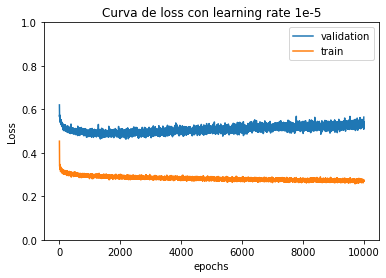

In [52]:
plt.plot(fitter.history['val_loss'], label='validation')
plt.plot(fitter.history['loss'], label='train')
plt.title('Curva de loss con learning rate 1e-5')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('Loss')
plt.ylim(0, 1)
plt.show()

# Si quieres probar con imágenes corre de acá para abajo:

In [70]:
model = load_model('best_model_final.h5')

# Acá puedes cambiar las imágenes:

In [71]:
test_young = face_detector(get_image('young_oprah.jpg', (224,224)))
test_normal = face_detector(get_image('Oprah.jpg', (224,224)))
test_old = face_detector(get_image('old_oprah.jpeg', (224,224)))

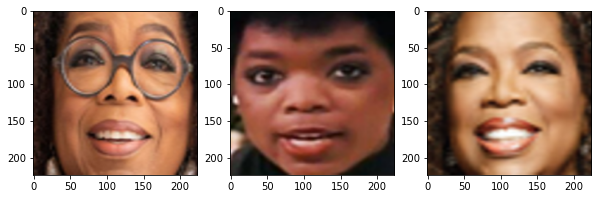

In [72]:
fig, ax = plt.subplots(1, 3, figsize=(10,10))
ax[0].imshow(test_old[0])
ax[1].imshow(test_young[0])
ax[2].imshow(test_normal[0])

In [73]:
from keras.applications.vgg16 import preprocess_input
test_old = base_model.predict(preprocess_input(test_old))
test_young = base_model.predict(preprocess_input(test_young))
test_normal = base_model.predict(preprocess_input(test_normal))

In [74]:
old_normal = model.predict([test_old, test_normal])

In [75]:
print(old_normal)

[[0.9827268]]


In [76]:
young_normal = model.predict([test_young, test_normal])

In [77]:
print(young_normal)

[[0.9938188]]


In [78]:
big_gap = model.predict([test_young, test_old])

In [79]:
print(big_gap)

[[0.9882052]]


In [80]:
test_michelle = face_detector(get_image('michelle_obama.jpg', (224, 224)))
test_michelle = base_model.predict(preprocess_input(test_michelle))
model.predict([test_normal, test_michelle])

array([[0.0163072]], dtype=float32)

In [81]:
test_biden = face_detector(get_image('biden.jpg', (224, 224)))
test_biden_young = face_detector(get_image('donald_old.jpg', (224, 224)))

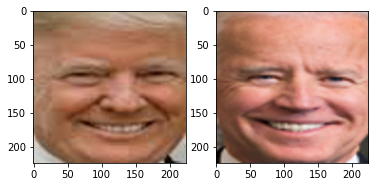

In [82]:
fig, ax = plt.subplots(1,2)
ax[0].imshow(test_biden_young[0])
ax[1].imshow(test_biden[0])

In [83]:
joe_biden_old = base_model.predict(preprocess_input(test_biden))
joe_biden_young = base_model.predict(preprocess_input(test_biden_young))


In [84]:
print(model.predict([joe_biden_old, joe_biden_young]))

[[0.9716329]]


In [102]:
test_1 = face_detector(get_image('Roberto_2.jpg', (224, 224)))
test_2 = face_detector(get_image('roberto_viejo.jpeg', (224, 224)))

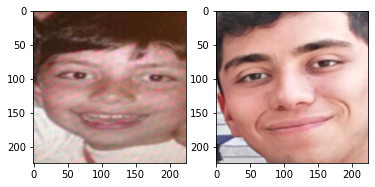

In [103]:
fig, ax = plt.subplots(1,2)
ax[0].imshow(test_1[0])
ax[1].imshow(test_2[0])

In [104]:
test_1 = base_model.predict(preprocess_input(test_1))
test_2 = base_model.predict(preprocess_input(test_2))

In [105]:
print(model.predict([test_1, test_2 ]))

[[0.913121]]


In [59]:
test_old = face_detector(get_image('roberto_viejo.jpeg', (224, 224)))
test_young = face_detector(get_image('nicolas3.jpg', (224, 224)))

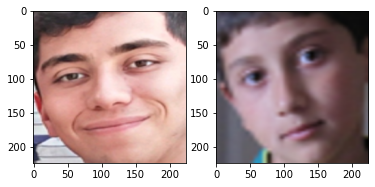

In [60]:
fig, ax = plt.subplots(1,2)
ax[0].imshow(test_old[0])
ax[1].imshow(test_young[0])

In [61]:
test_popi_young= base_model.predict(preprocess_input(test_old))
test_popi_bebe = base_model.predict(preprocess_input(test_young))


In [62]:
print(model.predict([test_popi_young, test_popi_bebe]))

[[0.70424587]]


# Resultados en test de entrenamiento, validación y testeo

# Entrenamiento

In [601]:
model.evaluate([reference, query], labels)

3560/3560 [==============================] - 0s 73us/sample - loss: 0.5510 - accuracy: 0.9879


[0.5510344428962536, 0.98792136]

# validación

In [599]:
model2.evaluate([val_reference, val_query], val_labels)

300/300 [==============================] - 0s 113us/sample - loss: 0.8128 - accuracy: 0.8967


[0.8128391520182292, 0.89666665]

# Testing

In [12]:
model.evaluate([test_reference, test_query], test_labels)

400/400 [==============================] - 1s 2ms/sample - loss: 0.9278 - accuracy: 0.8400


[0.9278114604949951, 0.84]